# AV02 - Previsão de retornos diários de ações do Ibovespa com LSTM e GRU

Respondendo duas perguntas de imediato:
- Por que retornos e não preços? Os preços de uma ação podem ser interpretados como um passeio aleatório, comportamento de dados em que geralmente o melhor modelo para prever o próximo passo é simplesmente repetir o anterior. Random walks tem alta correlação entre a série e a própria série atrasada, indicando que o passado seria útil para prever o futuro, mas a correlação tem mais a ver com a tendência entre pontos do que com poder preditivo real. Uma série de retornos, estacionária, tem correlação irrelevante com ela mesma, mas tem mais poder preditivo real na decisão de comprar ou vender uma ação baseando-se nos movimentos dela, e melhor ainda se for utilizada uma classificação dos movimentos em vez de uma previsão numérica dos retornos, o que nos leva à paóxima questão.
- Por que classificação e não regressão? Como indicado por (Enke, 2005) https://www.sciencedirect.com/science/article/abs/pii/S0957417405001156, uma estratégia baseada em classificação da direção dos retornos tem um melhor ganho ajustado ao risco. Uma classificação positiva ou negativa em relação a se uma ação terá retorno positivo ou negativo transforma a saída do modelo em uma informação acionável, além de que tentar prever um valor numérico em uma série altamente volátil é mais difícil do que apenas dizer a direção do retorno.

## Importando dados e libs

In [1]:
# system
import os
import pickle
from datetime import datetime

# data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

# math
import numpy as np
import random

# stats, metrics, model selection
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import kstest, shapiro, pearsonr, ks_2samp
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import BaseCrossValidator
from sklearn.preprocessing import MinMaxScaler

# models
# import pmdarima as pm
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Input, Dense, GRU, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 21

np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


In [2]:
abev3 = pd.read_csv("./stocks/ABEV3.csv")
bbdc3 = pd.read_csv("./stocks/BBDC3.csv")
itsa3 = pd.read_csv("./stocks/ITSA3.csv")
itub3 = pd.read_csv("./stocks/ITUB3.csv")
wege3 = pd.read_csv("./stocks/WEGE3.csv")

In [3]:
abev3.head()

Date  Price   Open   High    Low    Vol. Change %
0  10/04/2024  13.28  13.26  13.45  13.17  36.59M   -0.90%
1  10/03/2024  13.40  13.55  13.63  13.40  44.99M   -2.33%
2  10/02/2024  13.72  13.70  13.85  13.61  51.03M    0.88%
3  10/01/2024  13.60  13.20  13.72  13.13  65.79M    3.98%
4  09/30/2024  13.08  12.94  13.17  12.90  31.05M    1.24%

In [4]:
bbdc3.head()

Date  Price   Open   High    Low   Vol. Change %
0  10/04/2024  13.29  13.19  13.42  13.10  5.32M    0.30%
1  10/03/2024  13.25  13.28  13.42  13.14  5.28M   -0.97%
2  10/02/2024  13.38  13.30  13.54  13.27  8.59M    3.22%
3  10/01/2024  12.96  13.04  13.11  12.84  7.16M    0.54%
4  09/30/2024  12.89  13.05  13.08  12.87  5.90M   -1.13%

In [5]:
itsa3.head()

Date  Price   Open   High    Low     Vol. Change %
0  10/04/2024  10.63  10.57  10.68  10.55  114.10K    0.76%
1  10/03/2024  10.55  10.91  10.91  10.55  294.10K   -3.21%
2  10/02/2024  10.90  10.90  11.05  10.90  162.60K    0.46%
3  10/01/2024  10.85  11.07  11.07  10.79  432.30K   -2.08%
4  09/30/2024  11.08  11.12  11.16  11.00  122.70K   -0.63%

In [6]:
itub3.head()

Date  Price   Open   High    Low     Vol. Change %
0  10/04/2024  30.46  30.39  30.60  30.27  310.50K    0.20%
1  10/03/2024  30.40  31.01  31.02  30.30  386.90K   -2.22%
2  10/02/2024  31.09  30.90  31.43  30.90  343.80K    0.65%
3  10/01/2024  30.89  31.41  31.49  30.77  467.50K   -1.66%
4  09/30/2024  31.41  31.86  32.01  31.41  428.40K   -1.50%

In [7]:
wege3.head()

Date  Price   Open   High    Low   Vol. Change %
0  10/04/2024  54.50  54.36  54.98  54.26  4.82M   -0.18%
1  10/03/2024  54.60  54.76  55.00  53.95  4.47M   -1.36%
2  10/02/2024  55.35  56.13  56.37  55.14  5.12M   -0.95%
3  10/01/2024  55.88  55.00  56.22  54.80  8.03M    2.74%
4  09/30/2024  54.39  55.63  56.24  54.39  6.41M   -2.81%

Filtrando dataframes e convertendo data em Index. A data de início selecionada considera a data comum mais antiga entre todas as séries

In [8]:
START_DATE = "2007-10-04" # first register of price for WEGE3 -> earliest of series
END_DATE = "2024-10-04"

In [9]:
abev3 = abev3.filter(["Date", "Price"], axis=1)
bbdc3 = bbdc3.filter(["Date", "Price"], axis=1)
itsa3 = itsa3.filter(["Date", "Price"], axis=1)
itub3 = itub3.filter(["Date", "Price"], axis=1)
wege3 = wege3.filter(["Date", "Price"], axis=1)

abev3['Date'] = pd.to_datetime(abev3['Date'], format='%m/%d/%Y')
bbdc3['Date'] = pd.to_datetime(bbdc3['Date'], format='%m/%d/%Y')
itsa3['Date'] = pd.to_datetime(itsa3['Date'], format='%m/%d/%Y')
itub3['Date'] = pd.to_datetime(itub3['Date'], format='%m/%d/%Y')
wege3['Date'] = pd.to_datetime(wege3['Date'], format='%m/%d/%Y')

Verificando se está certo...

In [10]:
abev3.head()

Date  Price
0 2024-10-04  13.28
1 2024-10-03  13.40
2 2024-10-02  13.72
3 2024-10-01  13.60
4 2024-09-30  13.08

In [11]:
abev3 = abev3[(abev3["Date"] >= START_DATE) & (abev3["Date"] <= END_DATE)]
abev3.tail()

Date  Price
4210 2007-10-10   3.04
4211 2007-10-09   3.08
4212 2007-10-08   3.06
4213 2007-10-05   3.06
4214 2007-10-04   2.99

In [12]:
bbdc3 = bbdc3[(bbdc3["Date"] >= START_DATE) & (bbdc3["Date"] <= END_DATE)]
bbdc3.tail()

Date  Price
4211 2007-10-10   6.35
4212 2007-10-09   6.38
4213 2007-10-08   6.31
4214 2007-10-05   6.30
4215 2007-10-04   6.00

In [13]:
itsa3 = itsa3[(itsa3["Date"] >= START_DATE) & (itsa3["Date"] <= END_DATE)]
itsa3.tail()

Date  Price
4151 2007-10-10   3.43
4152 2007-10-09   3.44
4153 2007-10-08   3.43
4154 2007-10-05   3.52
4155 2007-10-04   3.48

In [14]:
itub3 = itub3[(itub3["Date"] >= START_DATE) & (itub3["Date"] <= END_DATE)]
itub3.tail()

Date  Price
4210 2007-10-10   8.15
4211 2007-10-09   8.30
4212 2007-10-08   7.95
4213 2007-10-05   7.86
4214 2007-10-04   7.44

In [15]:
wege3 = wege3[(wege3["Date"] >= START_DATE) & (wege3["Date"] <= END_DATE)]
wege3.tail()

Date  Price
4210 2007-10-10   2.43
4211 2007-10-09   2.44
4212 2007-10-08   2.45
4213 2007-10-05   2.43
4214 2007-10-04   2.40

In [16]:
abev3.set_index('Date', inplace=True)
bbdc3.set_index('Date', inplace=True)
itsa3.set_index('Date', inplace=True)
itub3.set_index('Date', inplace=True)
wege3.set_index('Date', inplace=True)

In [17]:
def print_line_series(df: pd.DataFrame, title: str = "Series"):
    plt.figure(figsize=(30, 10))
    plt.title(title)
    plt.plot(df.Price)

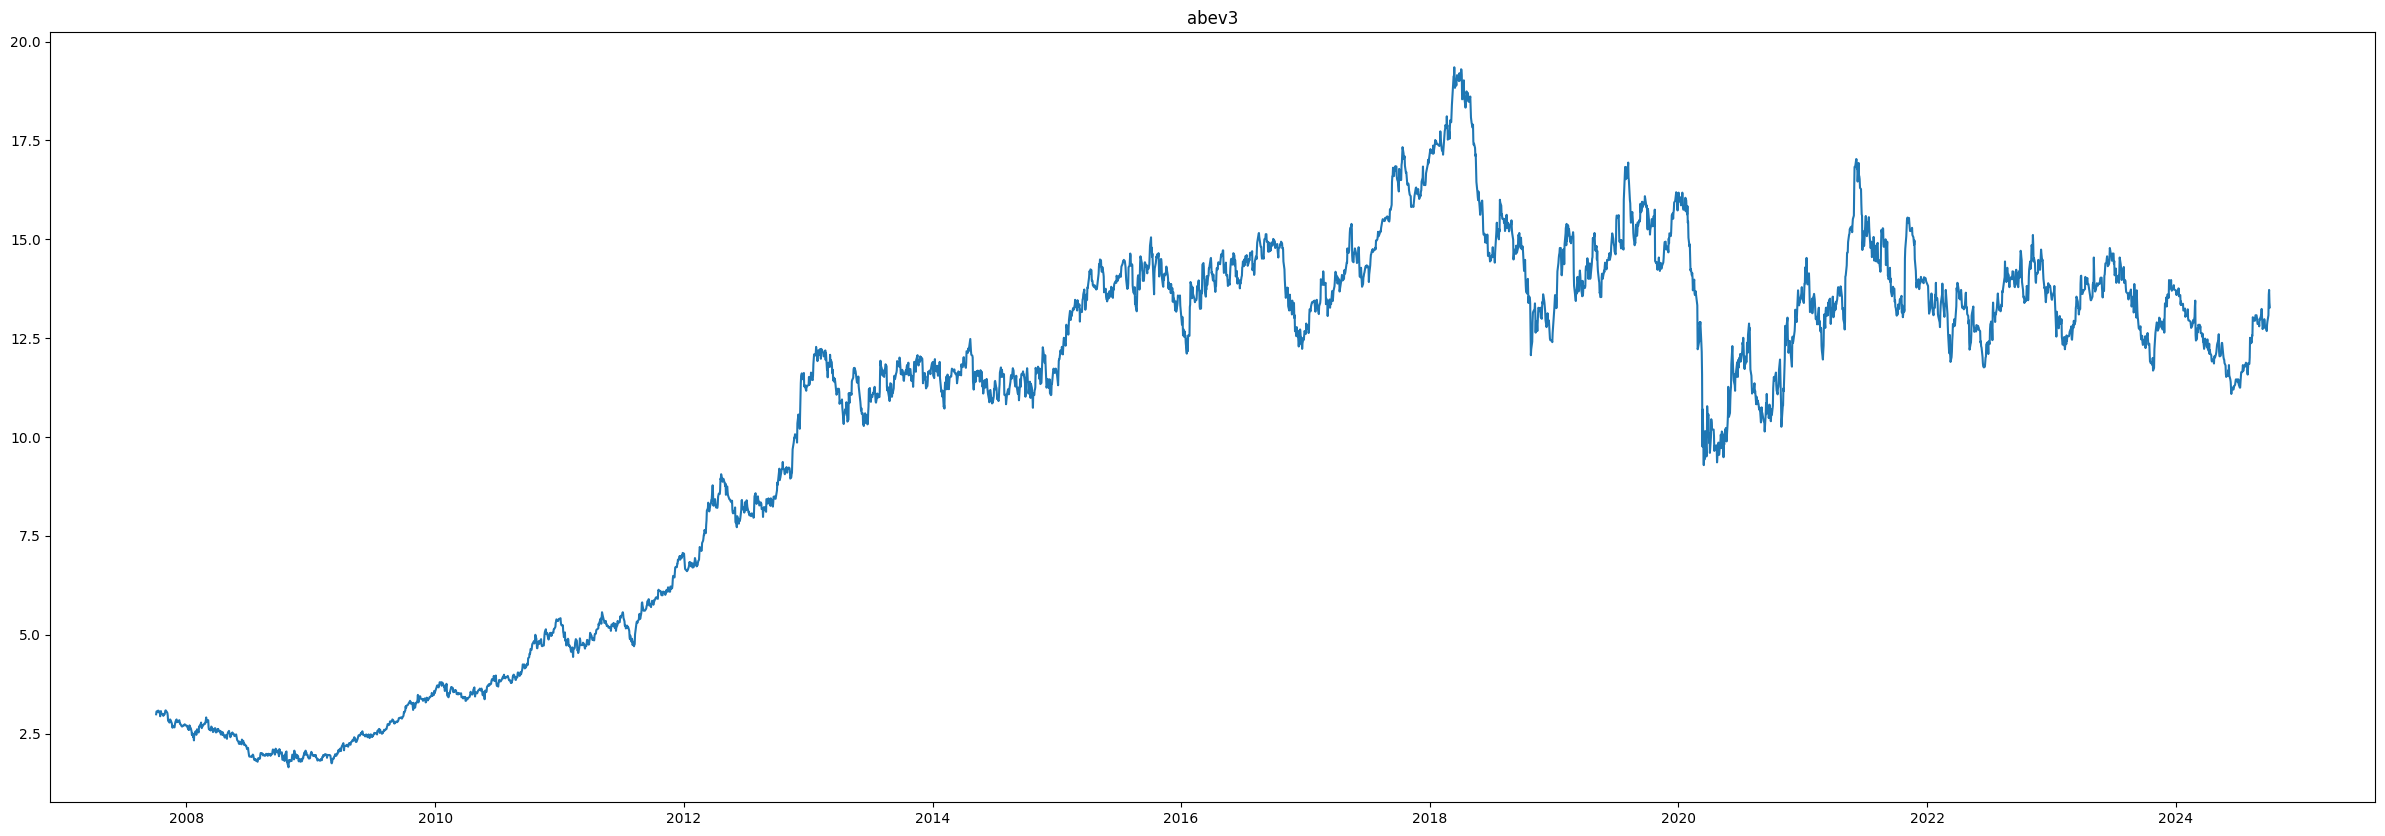

In [18]:
print_line_series(abev3, "abev3")

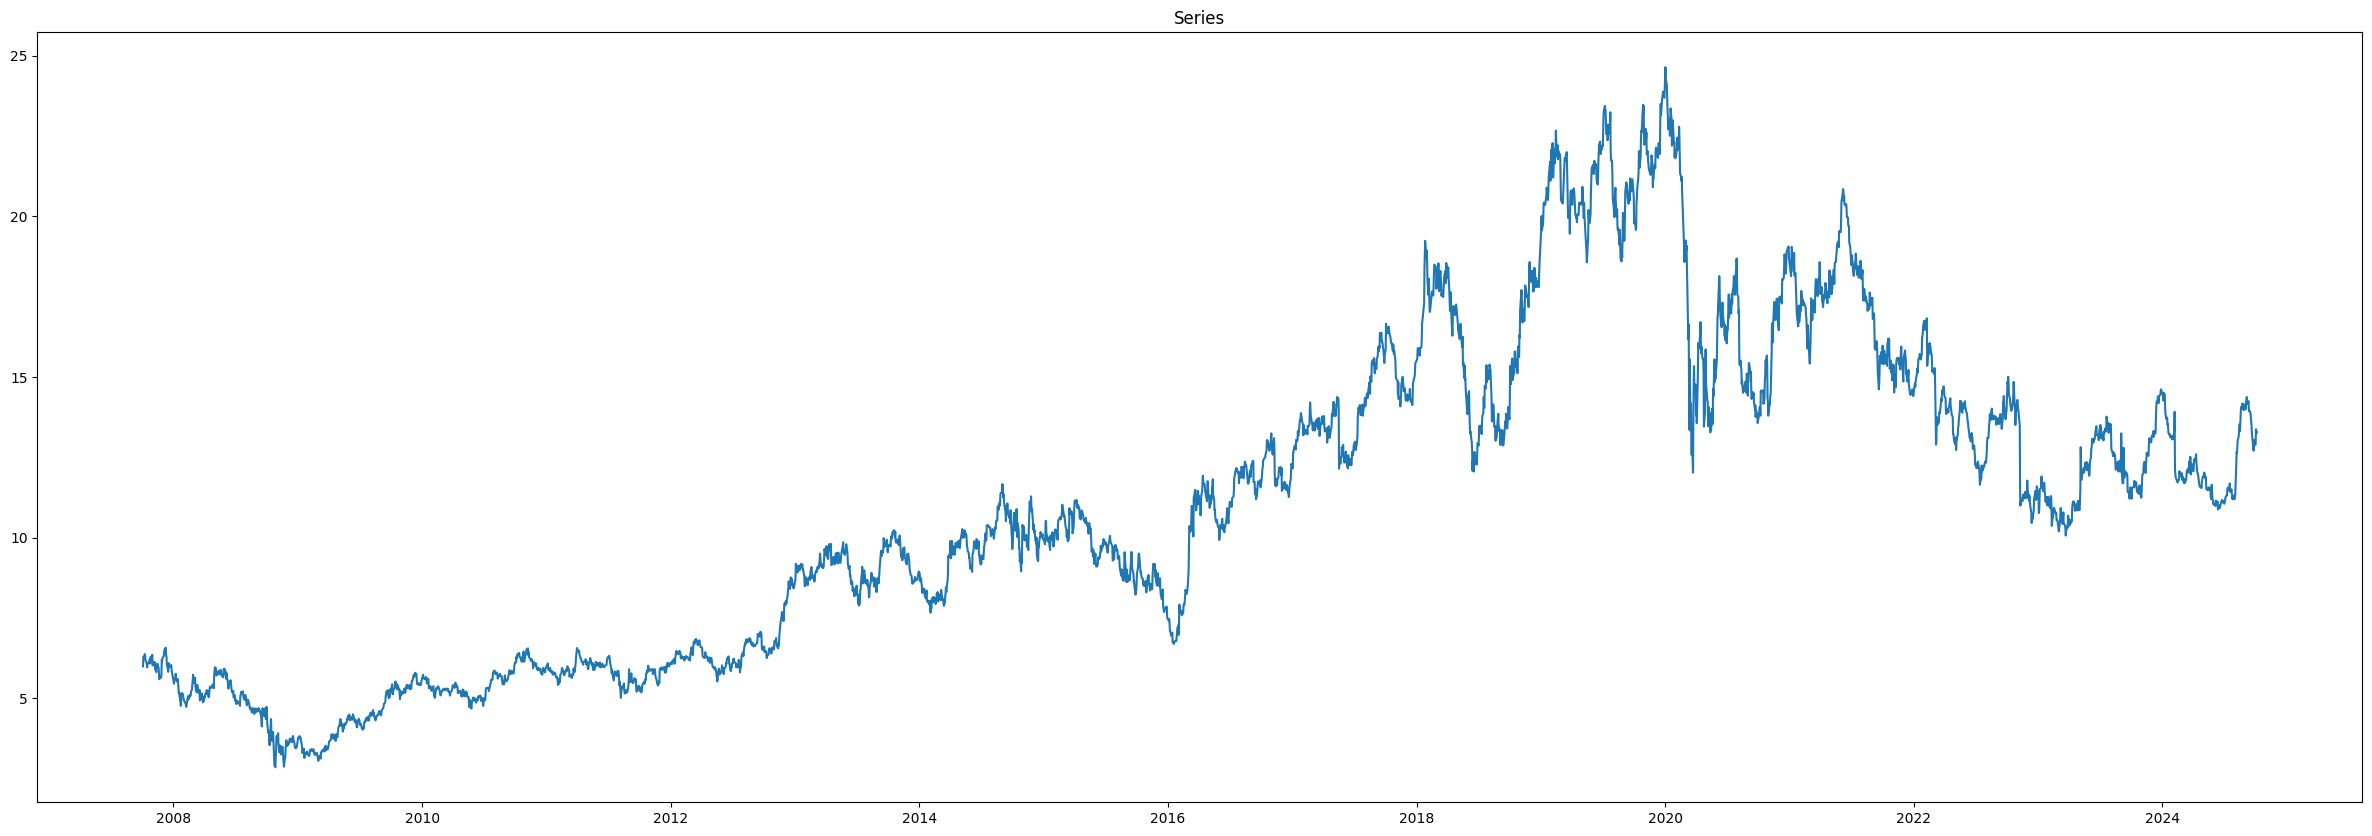

In [19]:
print_line_series(bbdc3)

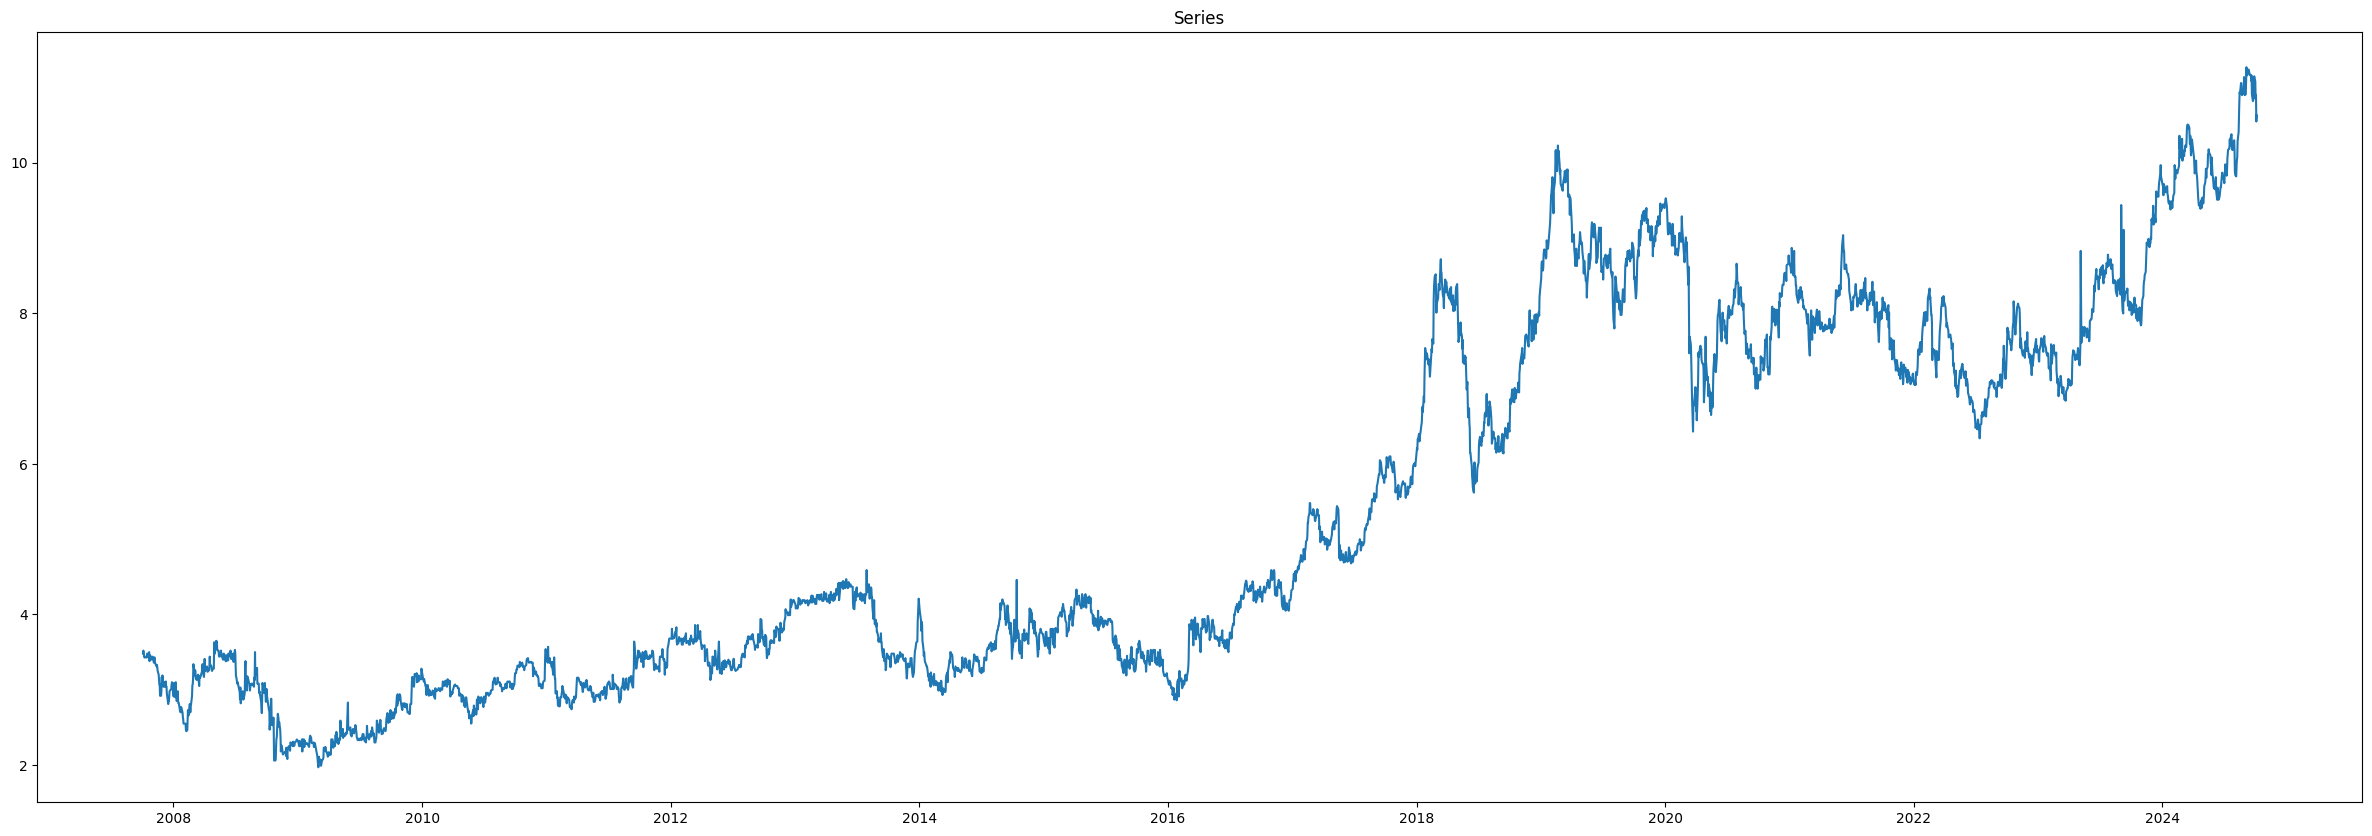

In [20]:
print_line_series(itsa3)

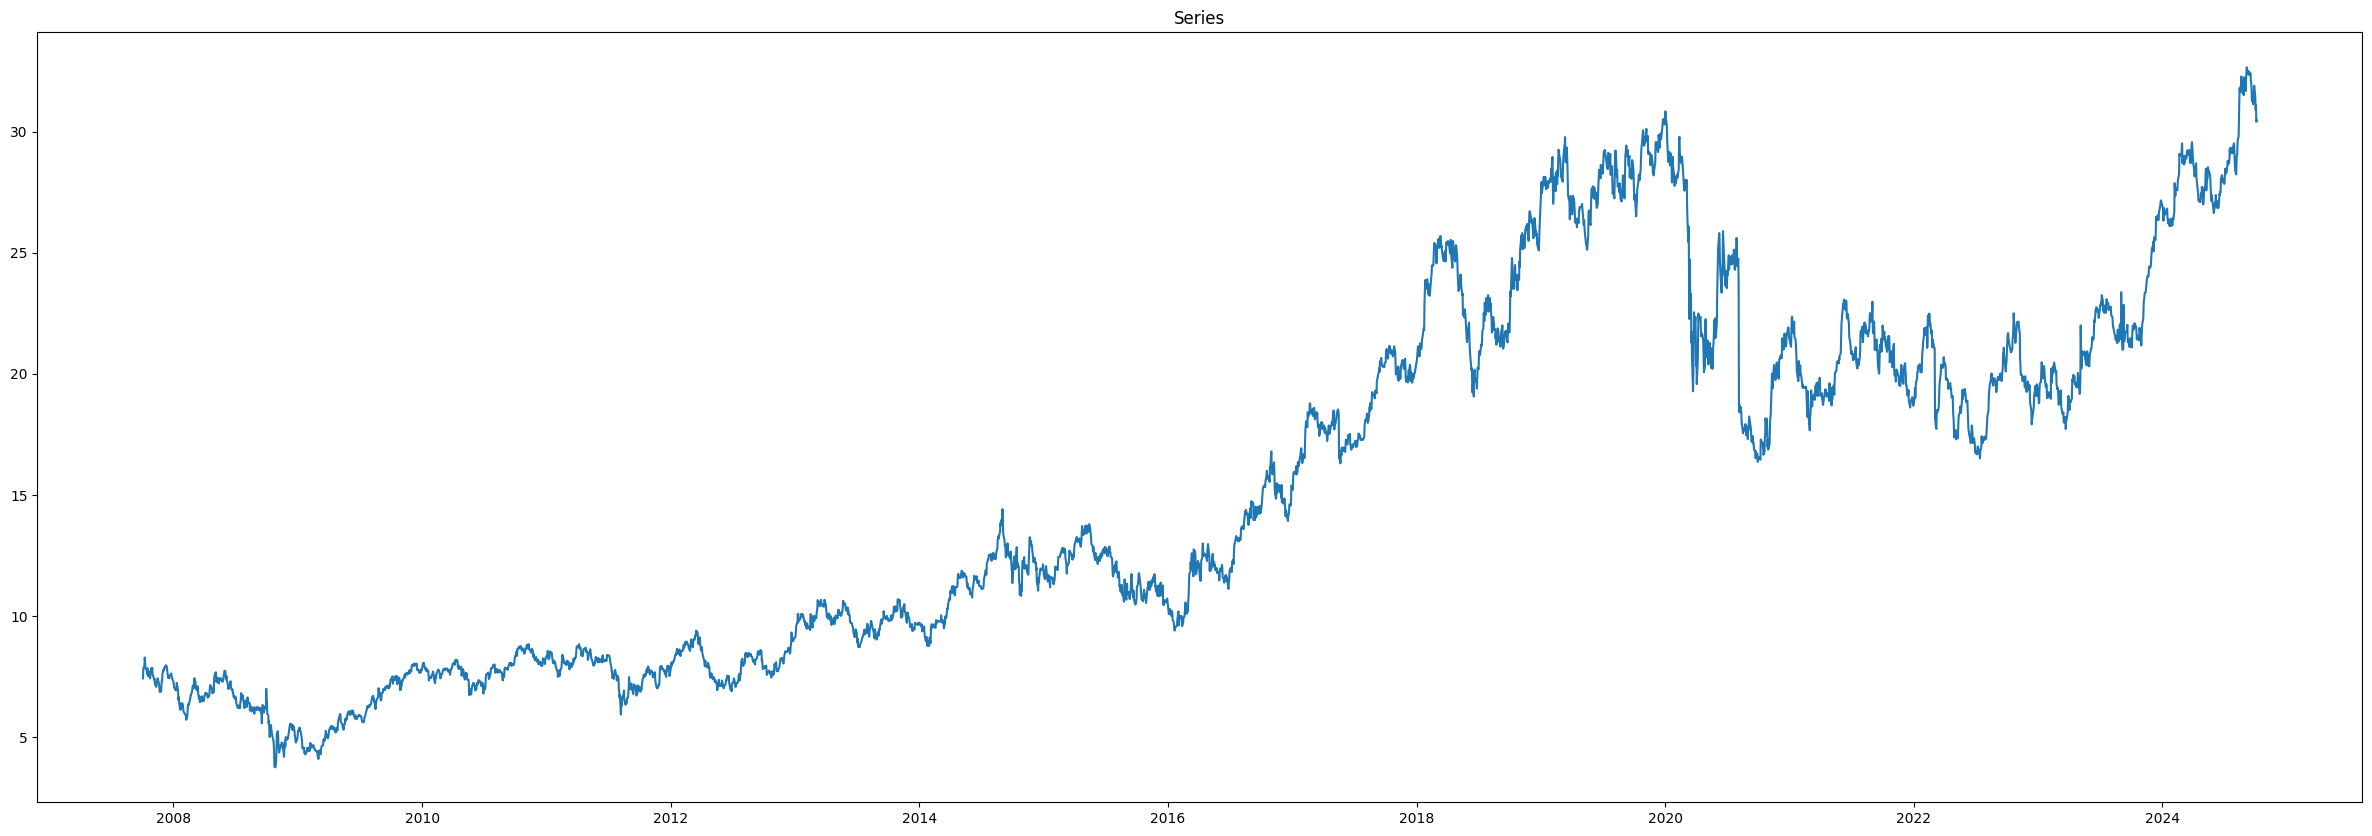

In [21]:
print_line_series(itub3)

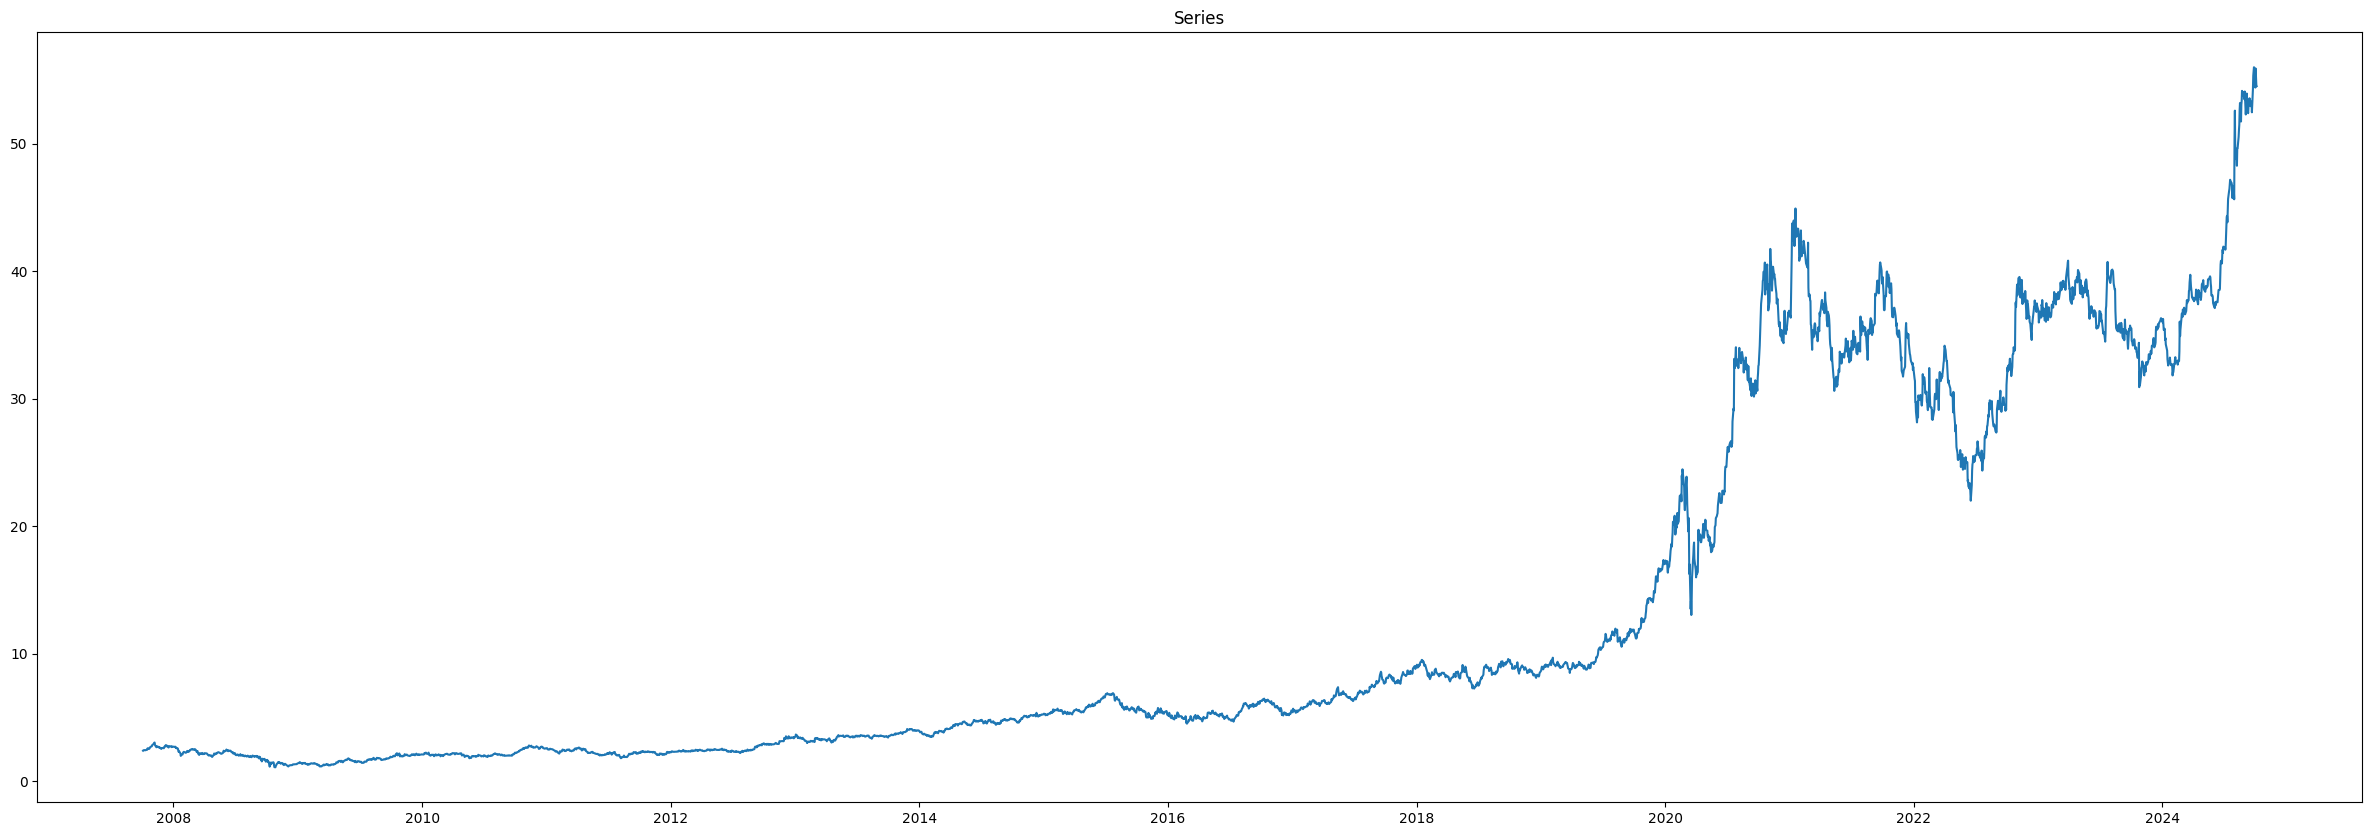

In [22]:
print_line_series(wege3)

## Lidando com dados faltantes

In [23]:
abev3.isna().sum()

Price    0
dtype: int64

In [24]:
bbdc3.isna().sum()

Price    0
dtype: int64

In [25]:
itsa3.isna().sum()

Price    0
dtype: int64

In [26]:
itub3.isna().sum()

Price    0
dtype: int64

In [27]:
wege3.isna().sum()

Price    0
dtype: int64

In [28]:
print(len(abev3))
print(len(bbdc3))
print(len(itub3))
print(len(itsa3))
print(len(wege3))

4215
4216
4215
4156
4215


Não há NaN nas séries, mas há discrepâncias no eixo temporal. Concatenando os DFs irá juntar o eixo temporal de todos eles, e as séries que não houverem registros de dias específicos passaram a ter NaN

In [29]:
stocks_df = pd.concat(
    [
        abev3.add_suffix("_abev3"), 
        bbdc3.add_suffix("_bbdc3"), 
        itub3.add_suffix("_itub3"), 
        itsa3.add_suffix("_itsa3"), 
        wege3.add_suffix("_wege3")
    ], 
    axis=1
)
stocks_df.head(10)

Price_abev3  Price_bbdc3  Price_itub3  Price_itsa3  Price_wege3
Date                                                                       
2007-10-04         2.99         6.00         7.44         3.48         2.40
2007-10-05         3.06         6.30         7.86         3.52         2.43
2007-10-08         3.06         6.31         7.95         3.43         2.45
2007-10-09         3.08         6.38         8.30         3.44         2.44
2007-10-10         3.04         6.35         8.15         3.43         2.43
2007-10-11         3.08         6.20         7.87         3.43         2.44
2007-10-15         3.02         6.09         7.75         3.43         2.47
2007-10-16         2.94         5.97         7.61         3.48         2.47
2007-10-17         3.06         6.09         7.86         3.48         2.57
2007-10-18         3.07         6.09          NaN         3.48         2.59

In [30]:
stocks_df.isna().sum()

Price_abev3     1
Price_bbdc3     0
Price_itub3     1
Price_itsa3    60
Price_wege3     1
dtype: int64

In [31]:
def count_largest_missing_interval(df: pd.DataFrame, column: str):
    # Step 1: Create a mask for missing values in the specified column.
    mask = df[column].isna()

    # Step 2: Identify consecutive groups of NaNs using cumsum on the inverted mask.
    # Use (~mask).cumsum() to create a unique group number for consecutive NaNs.
    groups = (~mask).cumsum()

    # Step 3: Filter only the groups corresponding to NaN values.
    nan_groups = stocks_df[mask].groupby(groups).size()

    # Step 4: Find the maximum size of consecutive NaNs.
    max_nan_sequence_length = nan_groups.max() if not nan_groups.empty else 0

    # Step 5: Get the index range for this sequence if it exists.
    if max_nan_sequence_length > 0:
        longest_nan_group = nan_groups.idxmax()
        start_date = df[mask & (groups == longest_nan_group)].index.min()
        end_date = df[mask & (groups == longest_nan_group)].index.max()
        print(f"The length of the largest consecutive sequence of missing values in {column} is: {max_nan_sequence_length}")
        print(f"The time range for this sequence is from {start_date} to {end_date}")
    else:
        print(f"No missing values found in the {column} time series.")
    print("\n")


In [32]:
for col in [col for col in stocks_df.columns.tolist() if "Price_" in col]:
    count_largest_missing_interval(stocks_df, col)

The length of the largest consecutive sequence of missing values in Price_abev3 is: 1
The time range for this sequence is from 2024-05-25 00:00:00 to 2024-05-25 00:00:00


No missing values found in the Price_bbdc3 time series.


The length of the largest consecutive sequence of missing values in Price_itub3 is: 1
The time range for this sequence is from 2007-10-18 00:00:00 to 2007-10-18 00:00:00


The length of the largest consecutive sequence of missing values in Price_itsa3 is: 3
The time range for this sequence is from 2008-10-03 00:00:00 to 2008-10-07 00:00:00


The length of the largest consecutive sequence of missing values in Price_wege3 is: 1
The time range for this sequence is from 2024-05-25 00:00:00 to 2024-05-25 00:00:00




Considerando que a série de preços de ações se comporta de forma visualmente semelhante a passeios aleatórios com inclinação positiva, a suposição de que o melhor modelo para prever o próximo passo é repetir o anterior não se aplica pois não contabiliza a tendência da série. Nesse caso, será aplicada uma interpolação linear, considerando que os valores ausentes não constituem intervalos maiores que 3 valores sequenciais. https://people.duke.edu/~rnau/Notes_on_the_random_walk_model--Robert_Nau.pdf


In [33]:
exploration_df = stocks_df.interpolate(method="linear")

In [34]:
exploration_df.isna().sum()

Price_abev3    0
Price_bbdc3    0
Price_itub3    0
Price_itsa3    0
Price_wege3    0
dtype: int64

## Exploração

TODO: 
- retornos acumulados por ano

In [35]:
def compute_returns_for_prices(df: pd.DataFrame, column_names: list[str]):
    df = df.copy()
    for column in column_names:
        new_name = column.split("_")[1] if "_" in column else column
        df[f"Return_{new_name}"] = (df[column] / df[column].shift(1)) - 1
        df.dropna(inplace=True)
    return df

Escolhido o teste de normalidade Shapiro-Wilk pois o tamanho das amostras é menor que 5000. De acordo com a propria documentação da função Shapiro: "For N > 5000 the W test statistic is accurate, but the p-value may not be". Pode-se esperar um p-value acurado

In [36]:
def shapiro_wilk_gaussian_test(array: np.ndarray):
    sw_stat, p_value = shapiro(array)

    alpha = 0.05

    print(f"Shapiro-Wilk Statistic: {sw_stat}")
    print(f"P-Value: {p_value}")

    if p_value < alpha:
        print(f"H0 rejected for an alpha of {alpha}, distribution can't be said Normal")
    else:
        print(f"Fail to reject H0 for an alpha of {alpha}, possibly normal distribution")
    
    return sw_stat, p_value

In [37]:
def adf_test(array: np.ndarray):
    alpha = 0.05
    result = adfuller(array)

    adf_stat = result[0]
    p_value = result[1]

    print('ADF Statistic:', adf_stat)
    print('p-value:', p_value)
    print('Critical Values:')

    if p_value < alpha:
        print(f"H0 rejected for an alpha of {alpha}. Series is possibly stationary")
    else:
        print(f"H0 not rejected for an alpha of {alpha}. Series is possibly non-stationary")

    return adf_stat, p_value

In [38]:
exploration_df = compute_returns_for_prices(exploration_df, exploration_df.columns.tolist())
exploration_df.tail()

Price_abev3  Price_bbdc3  Price_itub3  Price_itsa3  Price_wege3  \
Date                                                                          
2024-09-30        13.08        12.89        31.41        11.08        54.39   
2024-10-01        13.60        12.96        30.89        10.85        55.88   
2024-10-02        13.72        13.38        31.09        10.90        55.35   
2024-10-03        13.40        13.25        30.40        10.55        54.60   
2024-10-04        13.28        13.29        30.46        10.63        54.50   

            Return_abev3  Return_bbdc3  Return_itub3  Return_itsa3  \
Date                                                                 
2024-09-30      0.012384     -0.011503     -0.015052     -0.006278   
2024-10-01      0.039755      0.005431     -0.016555     -0.020758   
2024-10-02      0.008824      0.032407      0.006475      0.004608   
2024-10-03     -0.023324     -0.009716     -0.022194     -0.032110   
2024-10-04     -0.008955      0.003019      0.001974      0.007583   

            Return_wege3  
Date                      
2024-09-30     -0.028056  
2024-10-01      0.027395  
2024-10-02     -0.009485  
2024-10-03     -0.013550  
2024-10-04     -0.001832

### Estacionariedade

ADF Statistic: -11.426433608419808
p-value: 6.677842598959328e-21
Critical Values:
H0 rejected for an alpha of 0.05. Series is possibly stationary
ADF Statistic: -28.644695020965976
p-value: 0.0
Critical Values:
H0 rejected for an alpha of 0.05. Series is possibly stationary
ADF Statistic: -29.548670457689337
p-value: 0.0
Critical Values:
H0 rejected for an alpha of 0.05. Series is possibly stationary
ADF Statistic: -26.054275337285535
p-value: 0.0
Critical Values:
H0 rejected for an alpha of 0.05. Series is possibly stationary
ADF Statistic: -13.788318518029186
p-value: 9.024511198356839e-26
Critical Values:
H0 rejected for an alpha of 0.05. Series is possibly stationary


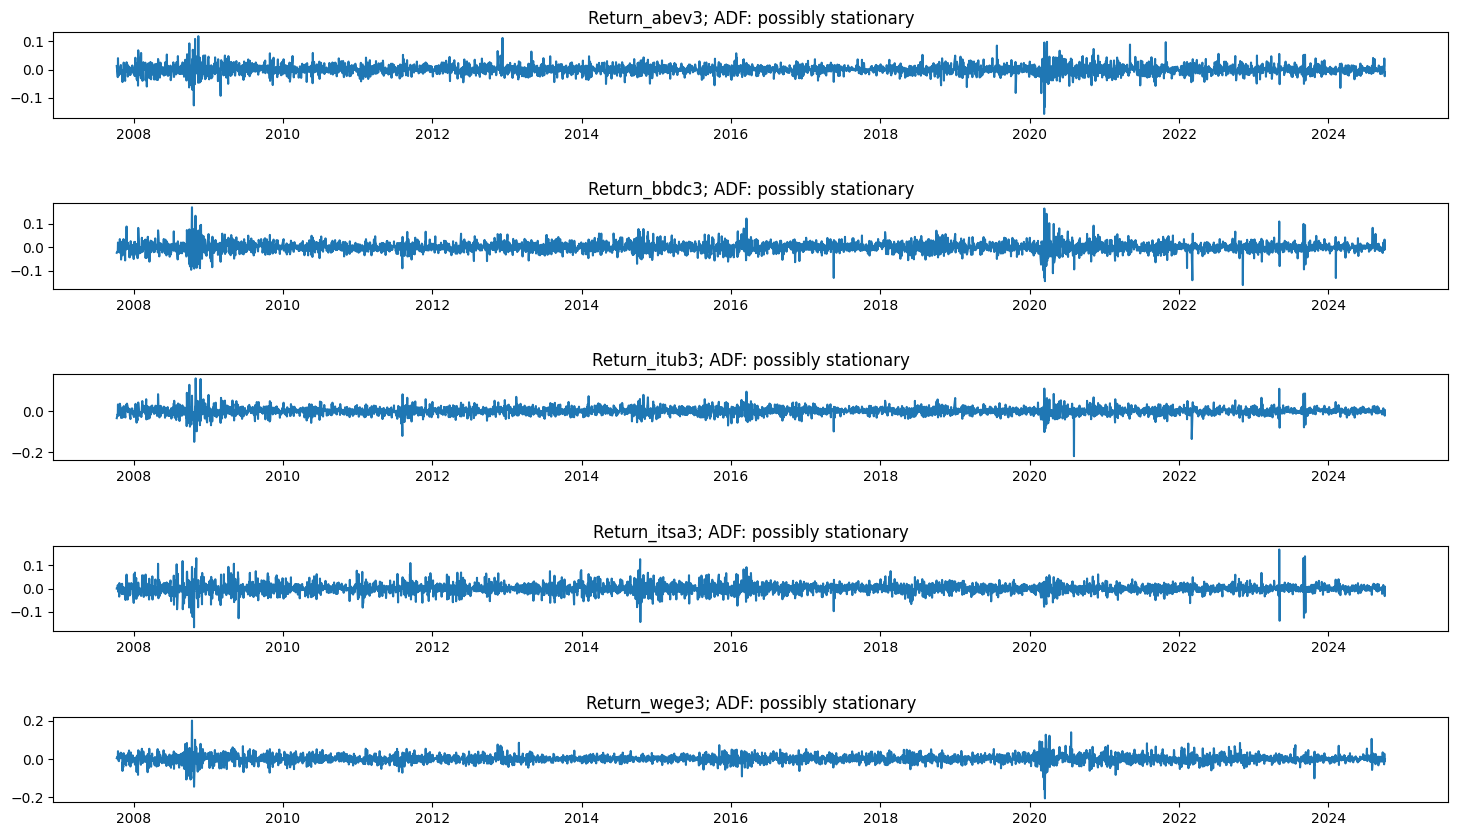

In [39]:
plt.figure(figsize=(18, 10))
for i, col in enumerate([col for col in exploration_df.columns.tolist() if "Return_" in col]):

    _, p_value = adf_test(exploration_df[col])

    plt.subplot(5, 1, i+1)
    plt.axis(True)
    plt.plot(exploration_df[col])
    plt.title(f"{col}; ADF: {'possibly stationary' if p_value < 0.05 else 'possibly non-stationary'}")
    plt.subplots_adjust(wspace=0.2, hspace=1.0)

O teste ADF com um alpha de 5% corrobora para todas as séries uma probabilidade próxima a 0 de que essas séries sejam não-estacionárias, portanto, rejeitamos a nula por uma provável estacionariedade.

### Autocorrelação

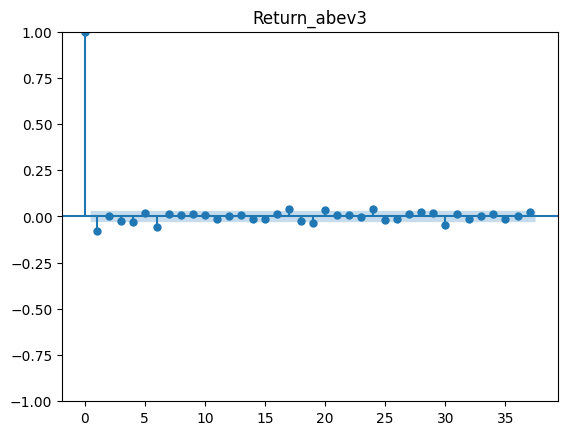

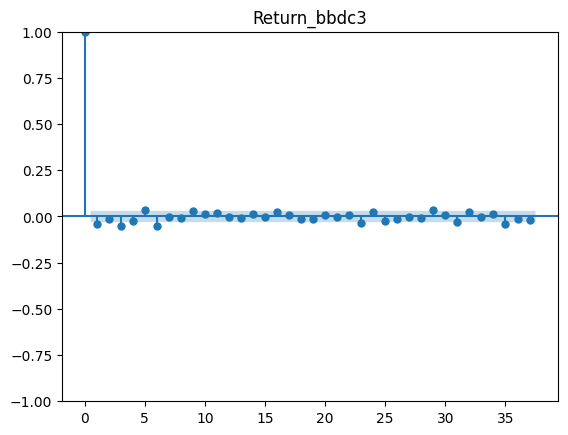

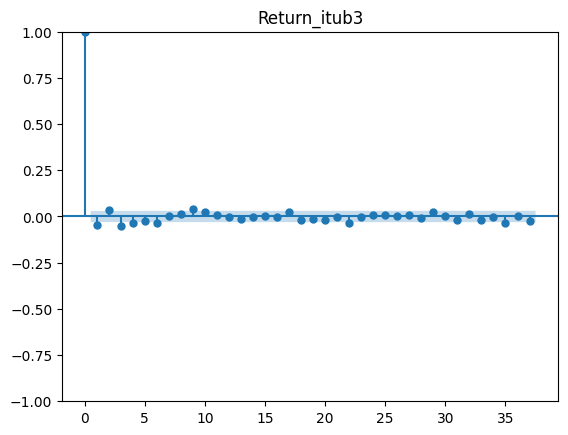

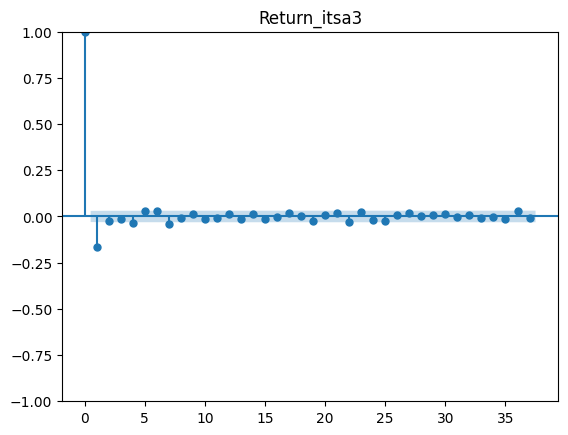

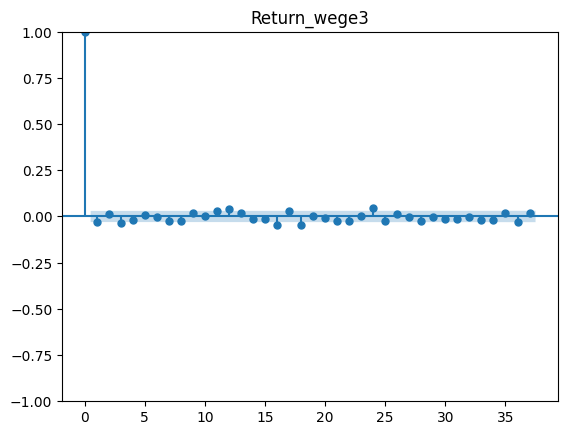

In [40]:
for i, col in enumerate([col for col in exploration_df.columns.tolist() if "Return_" in col]):

    # print(acf(stocks_df[col]))
    plot_acf(exploration_df[col], title=col)
    plt.subplots_adjust(wspace=0.2, hspace=1.0)

As séries de retornos no geral não apresentam autocorrelação, exceto pela ITSA3 que apresenta um valor um pouco acima do limiar para o lag 1. Isso indica que não seria possível ajustar um modelo MA a essas séries

In [41]:
return_cols_names = [col for col in exploration_df.columns.tolist() if "Return_" in col and "lag" not in col]

all_return_data = np.concatenate([exploration_df[col] for col in return_cols_names])
global_min_return = np.min(all_return_data)
global_max_return = np.max(all_return_data)

### Distribuições; Normalidade

Return_abev3
Shapiro-Wilk Statistic: 0.9404390537904097
P-Value: 3.464756370987934e-38
H0 rejected for an alpha of 0.05, distribution can't be said Normal

Return_bbdc3
Shapiro-Wilk Statistic: 0.9348584346672091
P-Value: 1.6368725473079503e-39
H0 rejected for an alpha of 0.05, distribution can't be said Normal

Return_itub3
Shapiro-Wilk Statistic: 0.928262637934504
P-Value: 5.755061300774139e-41
H0 rejected for an alpha of 0.05, distribution can't be said Normal

Return_itsa3
Shapiro-Wilk Statistic: 0.9314833558580566
P-Value: 2.8571418135972644e-40
H0 rejected for an alpha of 0.05, distribution can't be said Normal

Return_wege3
Shapiro-Wilk Statistic: 0.938757809286279
P-Value: 1.3495297286204005e-38
H0 rejected for an alpha of 0.05, distribution can't be said Normal



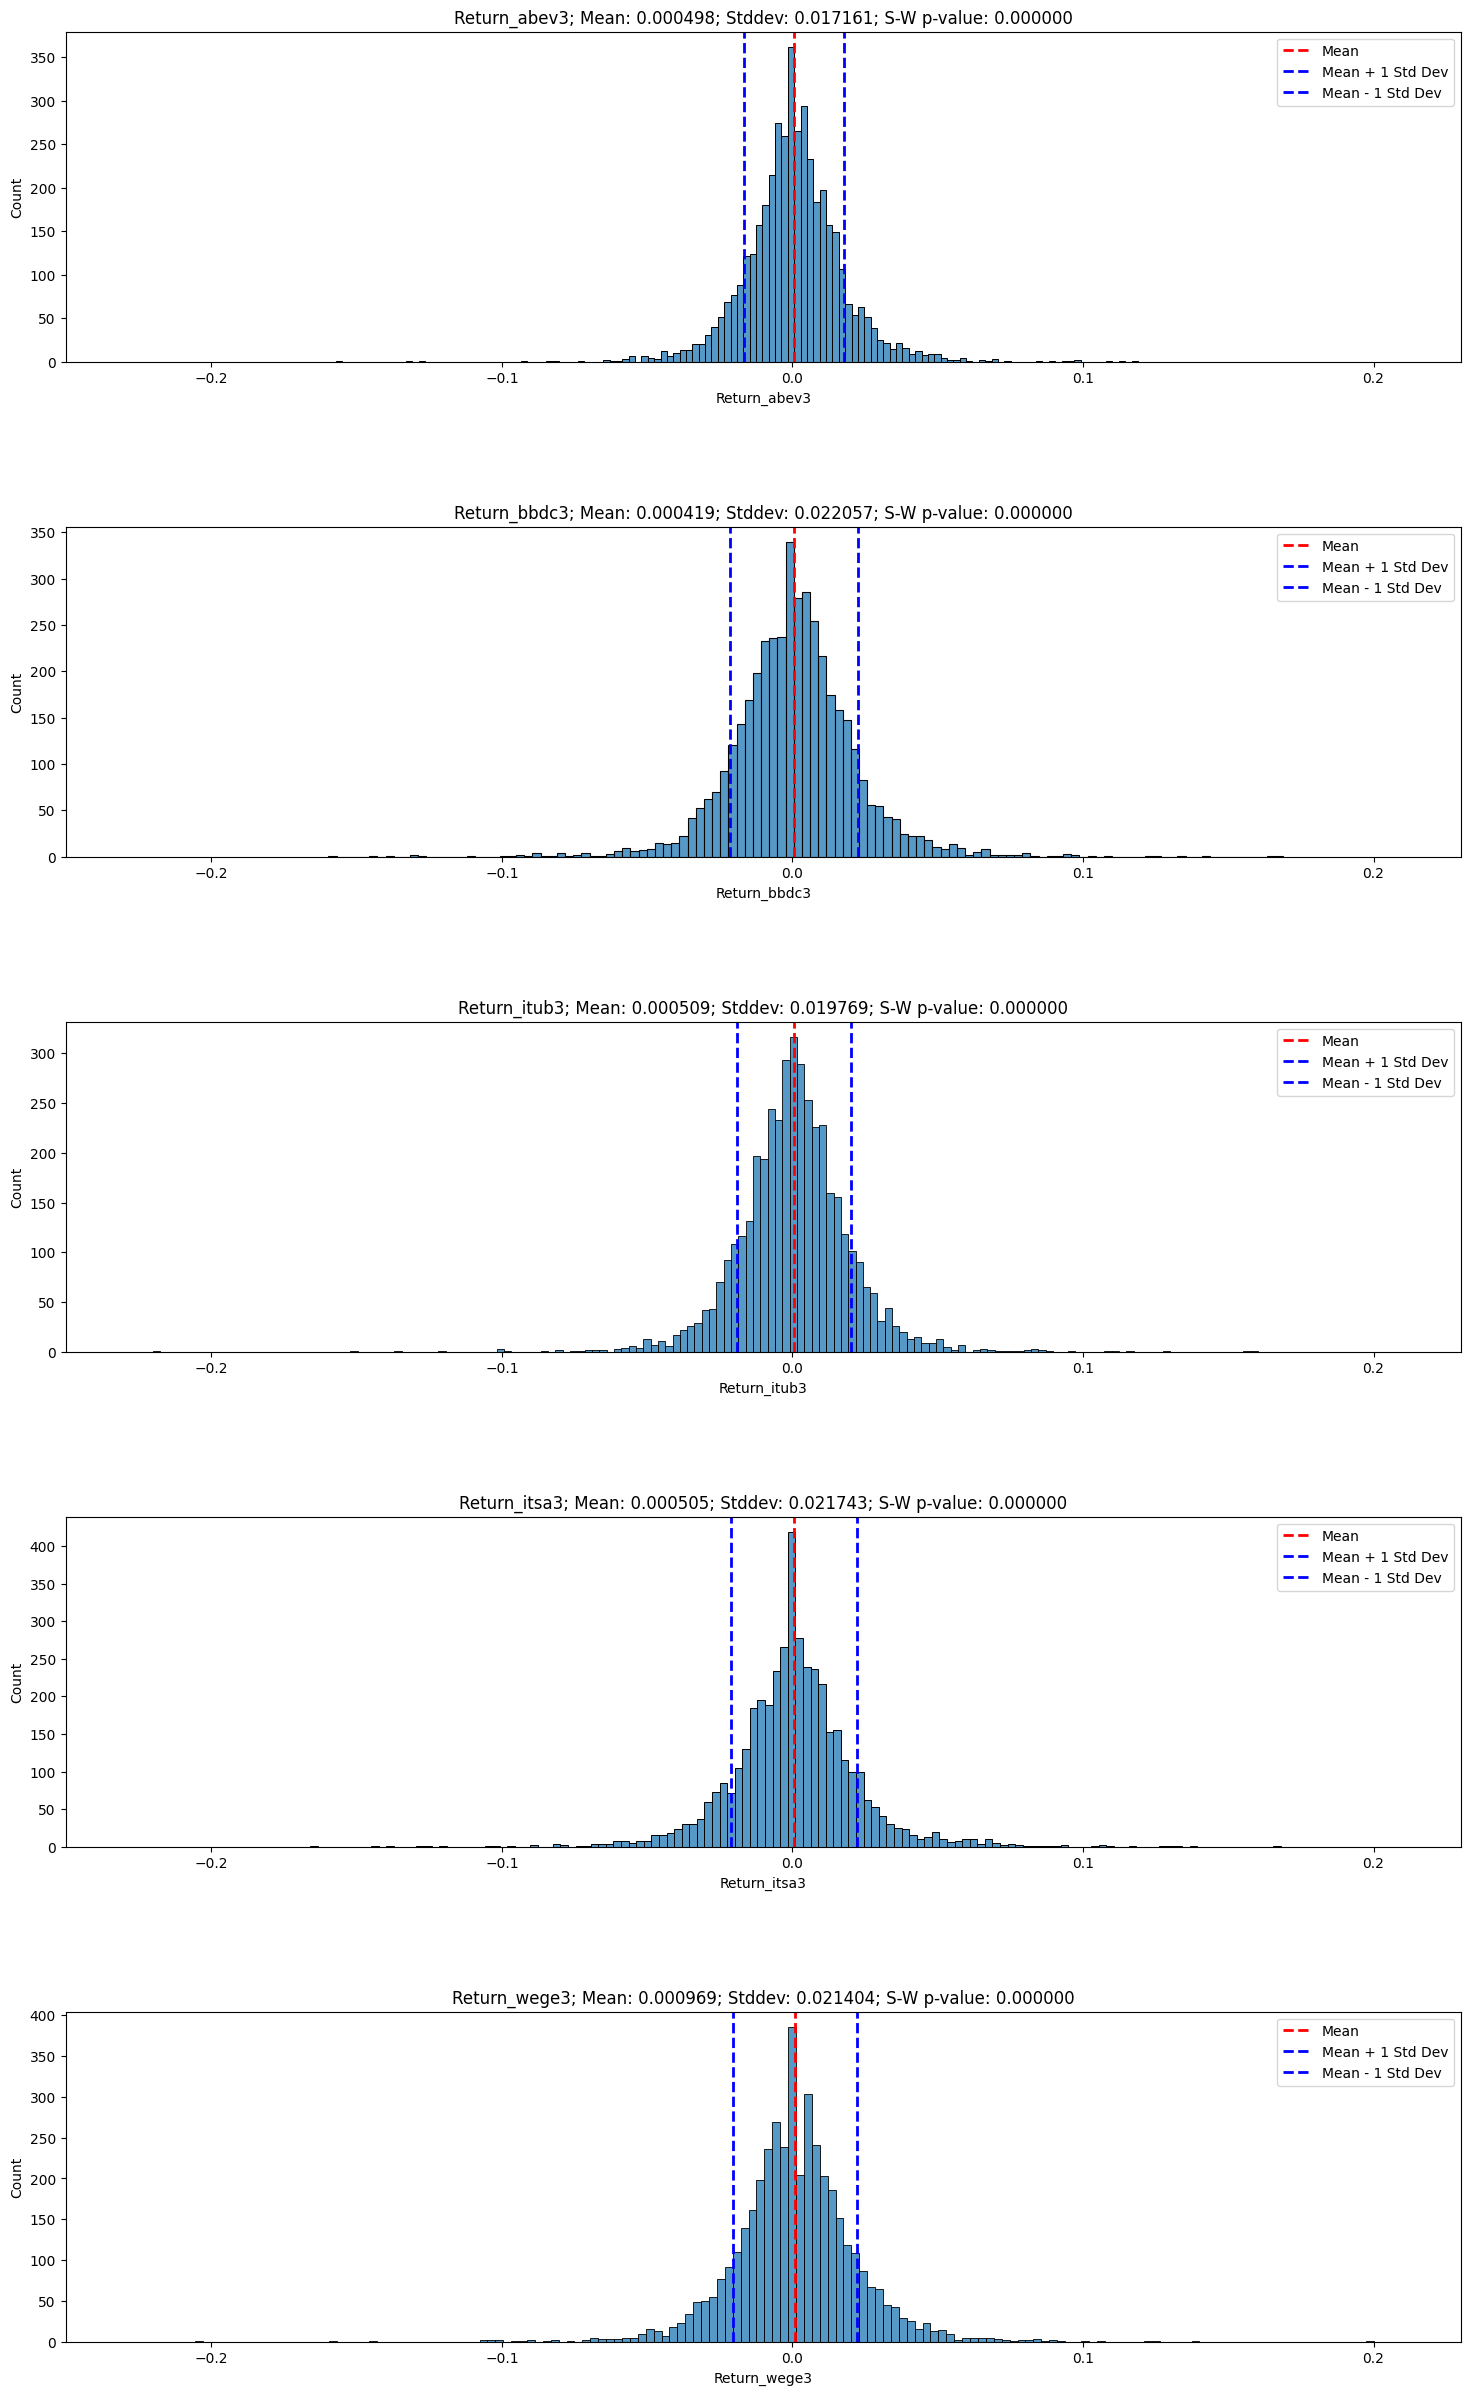

In [42]:
plt.figure(figsize=(18, 30))
for i, col in enumerate(return_cols_names):

    print(col)
    _, p_value = shapiro_wilk_gaussian_test(exploration_df[col])
    print("")

    mean = np.array(exploration_df[col]).mean()
    std = np.array(exploration_df[col]).std()

    plt.subplot(5, 1, i+1)
    plt.axis(True)
    sns.histplot(data=exploration_df, x=col, kde=False)
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean')
    plt.axvline(mean + std, color='blue', linestyle='dashed', linewidth=2, label=f'Mean + 1 Std Dev')
    plt.axvline(mean - std, color='blue', linestyle='dashed', linewidth=2, label=f'Mean - 1 Std Dev')
    plt.title(f"{col}; Mean: {mean:.6f}; Stddev: {std:.6f}; S-W p-value: {p_value:.6f}")
    plt.legend(frameon=True)
    plt.xlim(global_min_return - 0.03, global_max_return + 0.03)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)

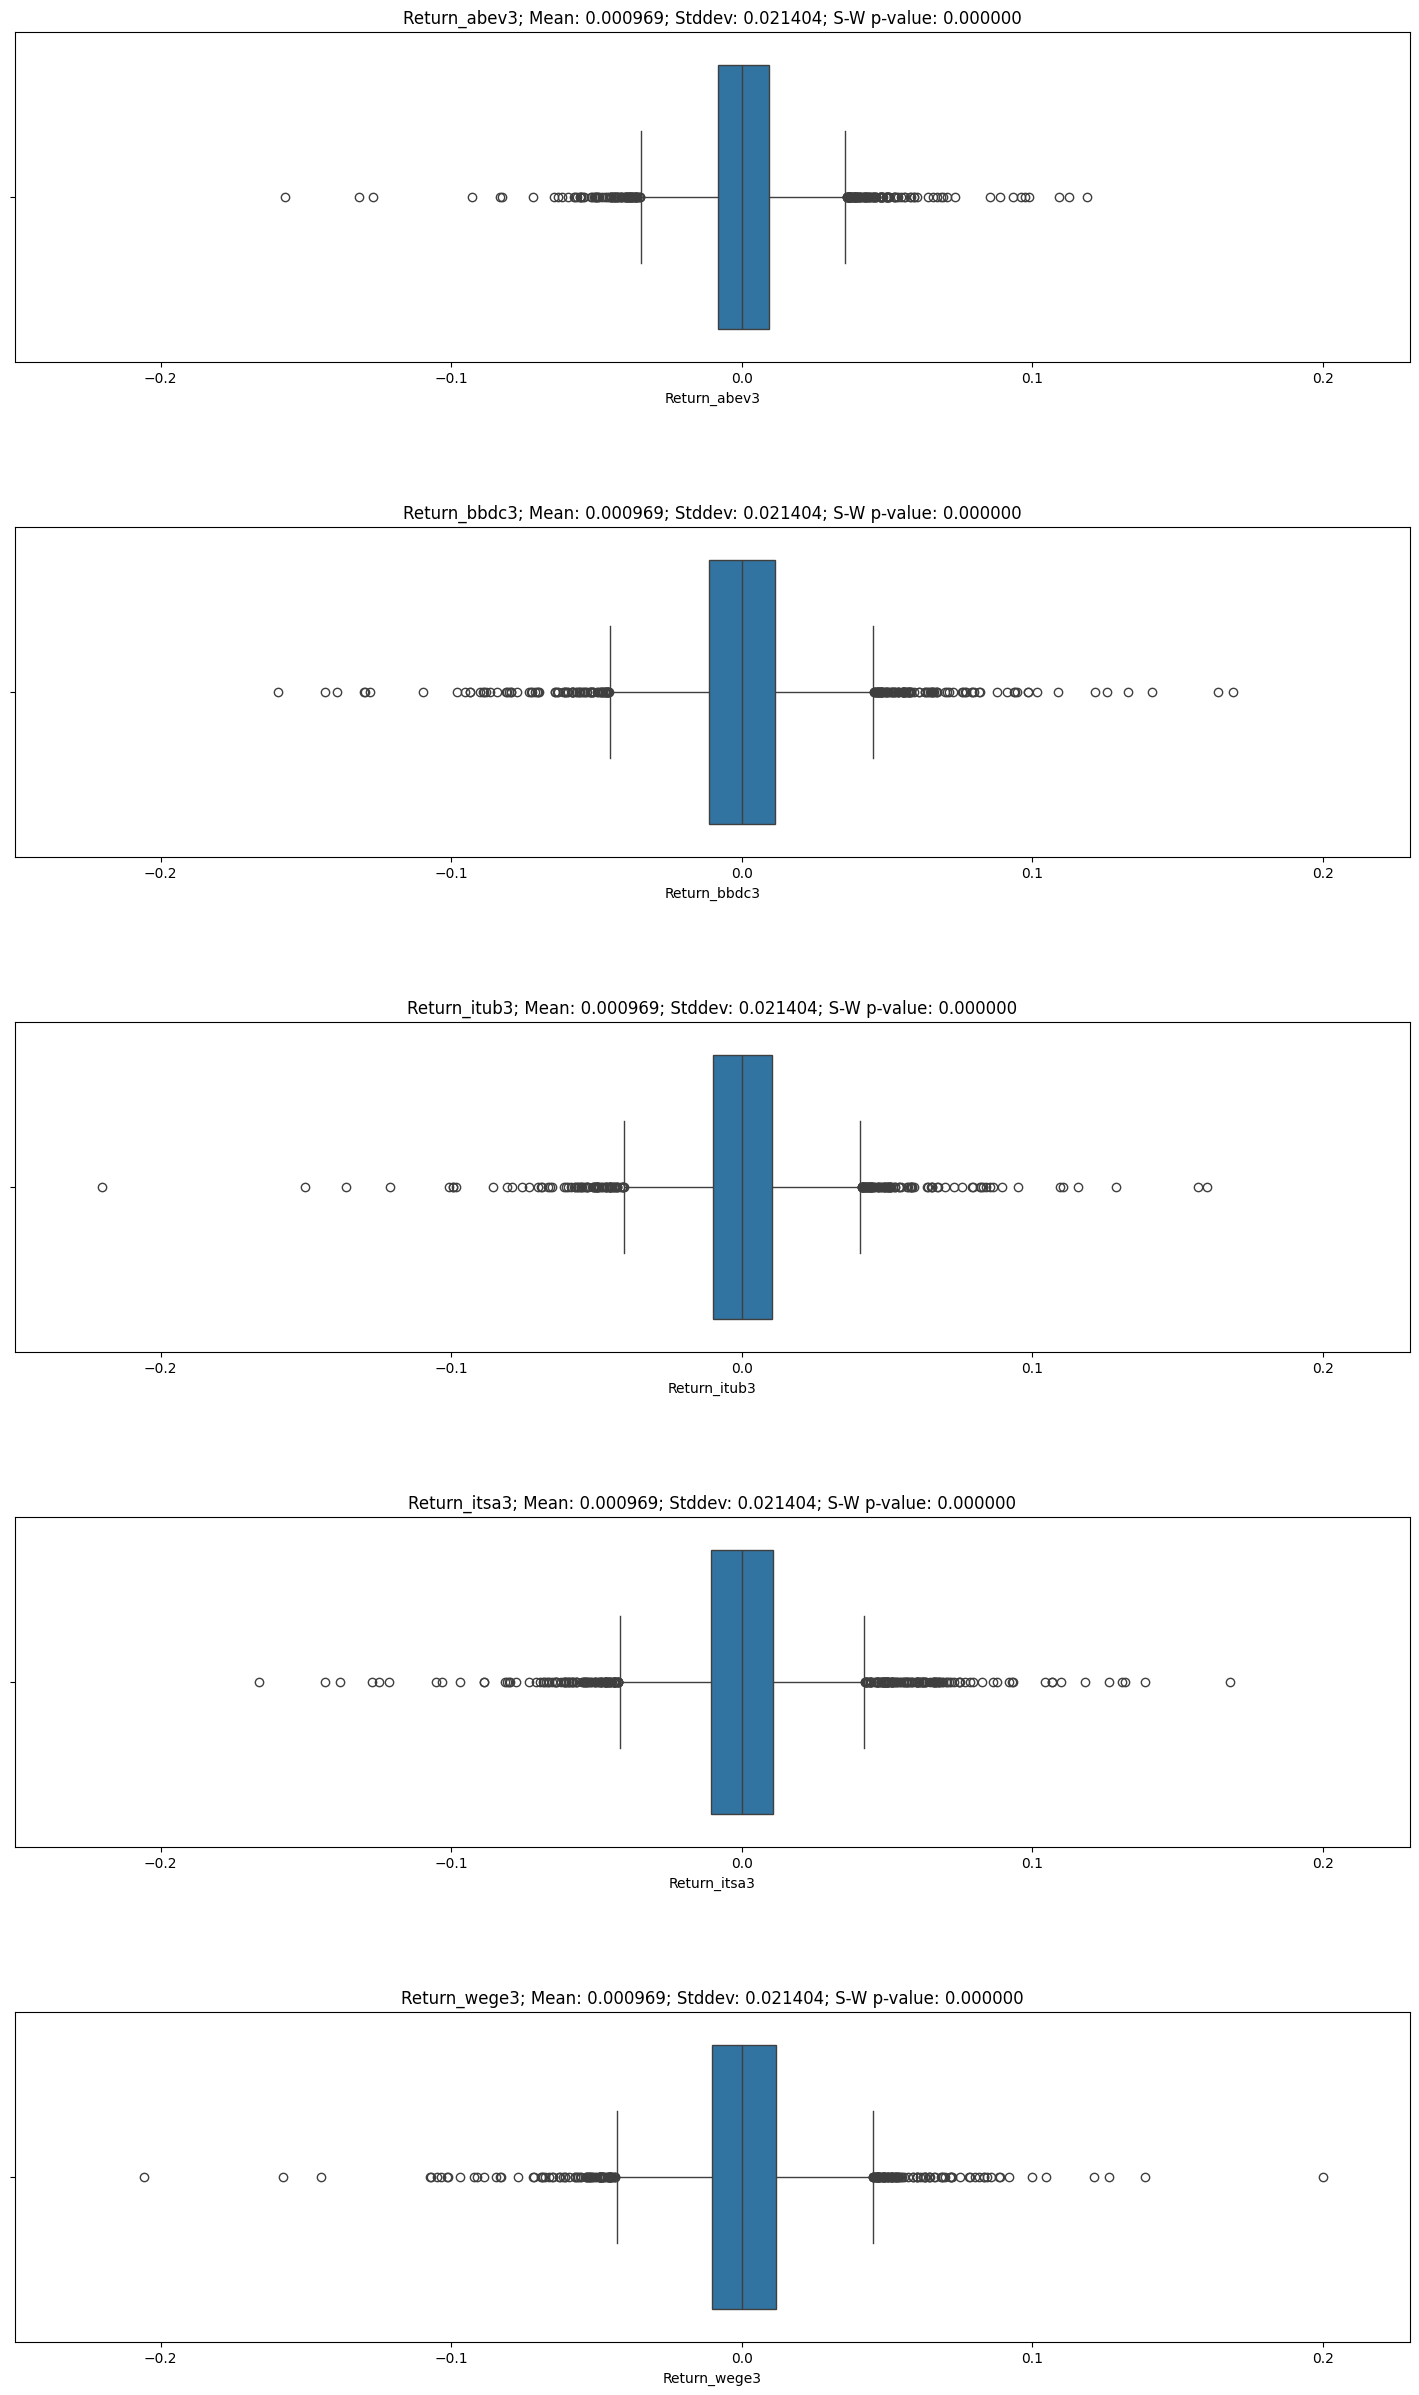

In [43]:
plt.figure(figsize=(18, 30))
for i, col in enumerate([col for col in exploration_df.columns.tolist() if "Return_" in col and "lag" not in col]):
    plt.subplot(5, 1, i+1)
    plt.axis(True)
    sns.boxplot(data=exploration_df, x=col)
    plt.title(f"{col}; Mean: {mean:.6f}; Stddev: {std:.6f}; S-W p-value: {p_value:.6f}")
    plt.xlim(global_min_return - 0.03, global_max_return + 0.03)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)

Análise dos histogramas e boxplots corrobora com a observação de que os dados não seguem uma distribuição normal de acordo com o teste de Shapiro-Wilk, possivelmente por causa da grande quantidade de outliers que puxam a distribuição para ambos os lados

### Correlações entre séries

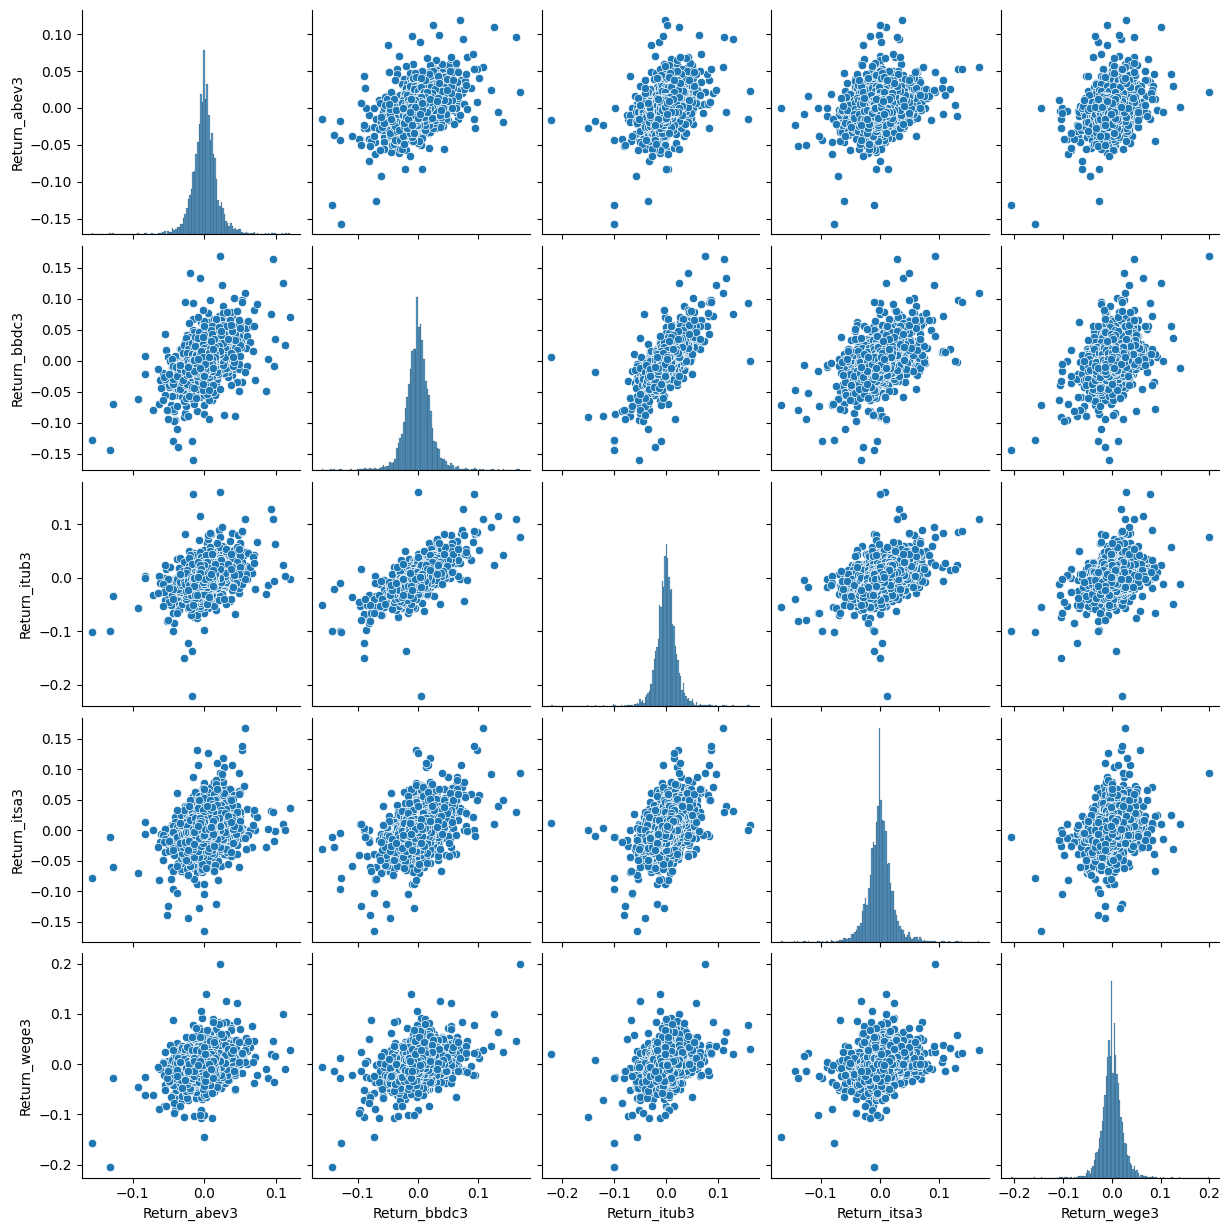

In [44]:
sns.pairplot(exploration_df[[col for col in exploration_df.columns.tolist() if "Return" in col]])

<Axes: >

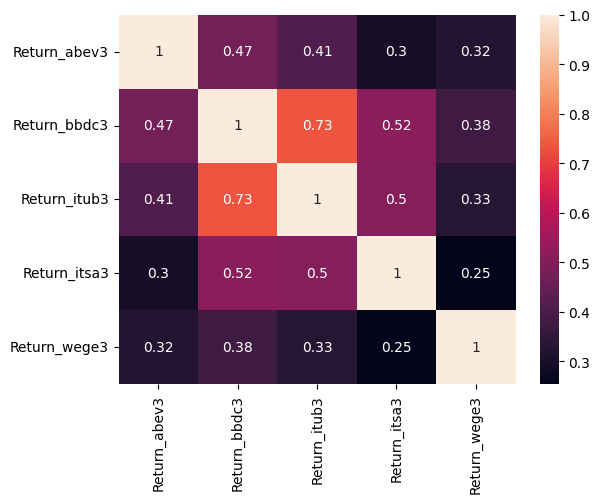

In [45]:
sns.heatmap(exploration_df[[col for col in exploration_df.columns.tolist() if "Return" in col]].corr(), annot=True)

O pairplot e o heatmap de correlação apontam que dificilmente qualquer uma série de retornos teria poder preditivo linear sobre as outras por não apresentarem uma correlação de Pearson significativa, exceto itub3 e bbdc3, o que faz sentido pois são duas ações do mesmo setor bancário, então movimentos de mercado que podem afetar uma delas também pode afetar a outra.

In [46]:
# return_cols_names = filter(lambda x: "Return_" in x, stocks_df.columns.tolist())
exploration_df[return_cols_names].describe()

Return_abev3  Return_bbdc3  Return_itub3  Return_itsa3  Return_wege3
count   4211.000000   4211.000000   4211.000000   4211.000000   4211.000000
mean       0.000498      0.000419      0.000509      0.000505      0.000969
std        0.017163      0.022060      0.019771      0.021746      0.021406
min       -0.157168     -0.159763     -0.220203     -0.165992     -0.205761
25%       -0.008318     -0.011242     -0.009860     -0.010506     -0.010100
50%        0.000000      0.000000      0.000000      0.000000      0.000000
75%        0.009434      0.011498      0.010580      0.010674      0.011955
max        0.118919      0.169014      0.160271      0.167989      0.200000

As séries de retornos são todas estacionárias e não seguem uma distribuição normal, de acordo com o teste ADF e o teste de Shapiro-Wilk, com uma média ligeiramente inclinada para o lado positivo. A média positiva indica que essas séries geraram retornos positivos com mais frequência do que negativos, e comprar e manter essas ações durante esse período resultaria, ao final, em um resultado financeiro positivo. Todas as séries têm outliers bem acima e abaixo dos limites, o que pode estar influenciando o teste de Shapiro-Wilk a rejeitar a nula

### Correlação da série de preços vs Série de retornos

corr between Price_abev3 and itself lagged: PearsonRResult(statistic=np.float64(0.9992001497341811), pvalue=np.float64(0.0))
corr between Price_bbdc3 and itself lagged: PearsonRResult(statistic=np.float64(0.9986171801430164), pvalue=np.float64(0.0))
corr between Price_itub3 and itself lagged: PearsonRResult(statistic=np.float64(0.9991605419974832), pvalue=np.float64(0.0))
corr between Price_itsa3 and itself lagged: PearsonRResult(statistic=np.float64(0.9989795140583534), pvalue=np.float64(0.0))
corr between Price_wege3 and itself lagged: PearsonRResult(statistic=np.float64(0.9995852267480806), pvalue=np.float64(0.0))


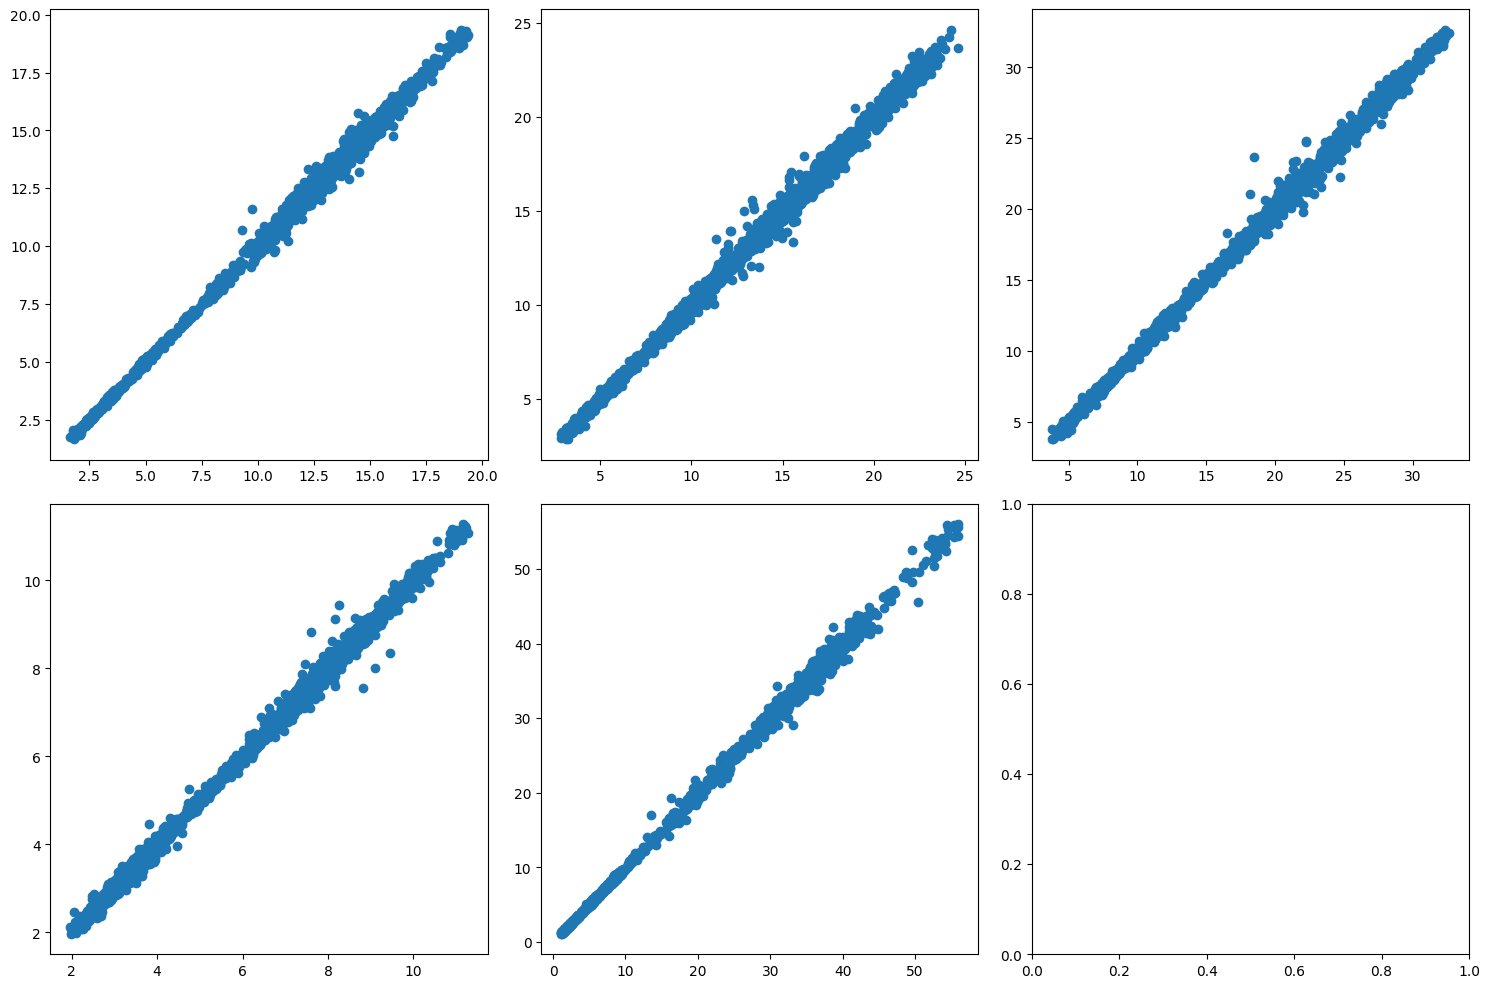

In [47]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

price_cols = [col for col in exploration_df.columns.tolist() if "Price" in col]
for i, col in enumerate(price_cols):
    new_df = pd.DataFrame()
    new_df[col] = exploration_df[col]
    new_df[f"{col}_shifted"] = exploration_df[col].shift(1)
    new_df.dropna(axis=0, inplace=True)
    print(f"corr between {col} and itself lagged: {pearsonr(new_df[col], new_df[f'{col}_shifted'])}")

    axes[i].scatter(new_df[col], new_df[f'{col}_shifted'])

plt.tight_layout()
plt.show()

corr between Return_abev3 and itself lagged: PearsonRResult(statistic=np.float64(-0.079302813446892), pvalue=np.float64(2.5756935676892496e-07))
corr between Return_bbdc3 and itself lagged: PearsonRResult(statistic=np.float64(-0.04024680613016281), pvalue=np.float64(0.00900993160863788))
corr between Return_itub3 and itself lagged: PearsonRResult(statistic=np.float64(-0.0474502749054975), pvalue=np.float64(0.002072729652719228))
corr between Return_itsa3 and itself lagged: PearsonRResult(statistic=np.float64(-0.16604608061470366), pvalue=np.float64(2.0836543654236445e-27))
corr between Return_wege3 and itself lagged: PearsonRResult(statistic=np.float64(-0.03180728561731851), pvalue=np.float64(0.03904526719195663))


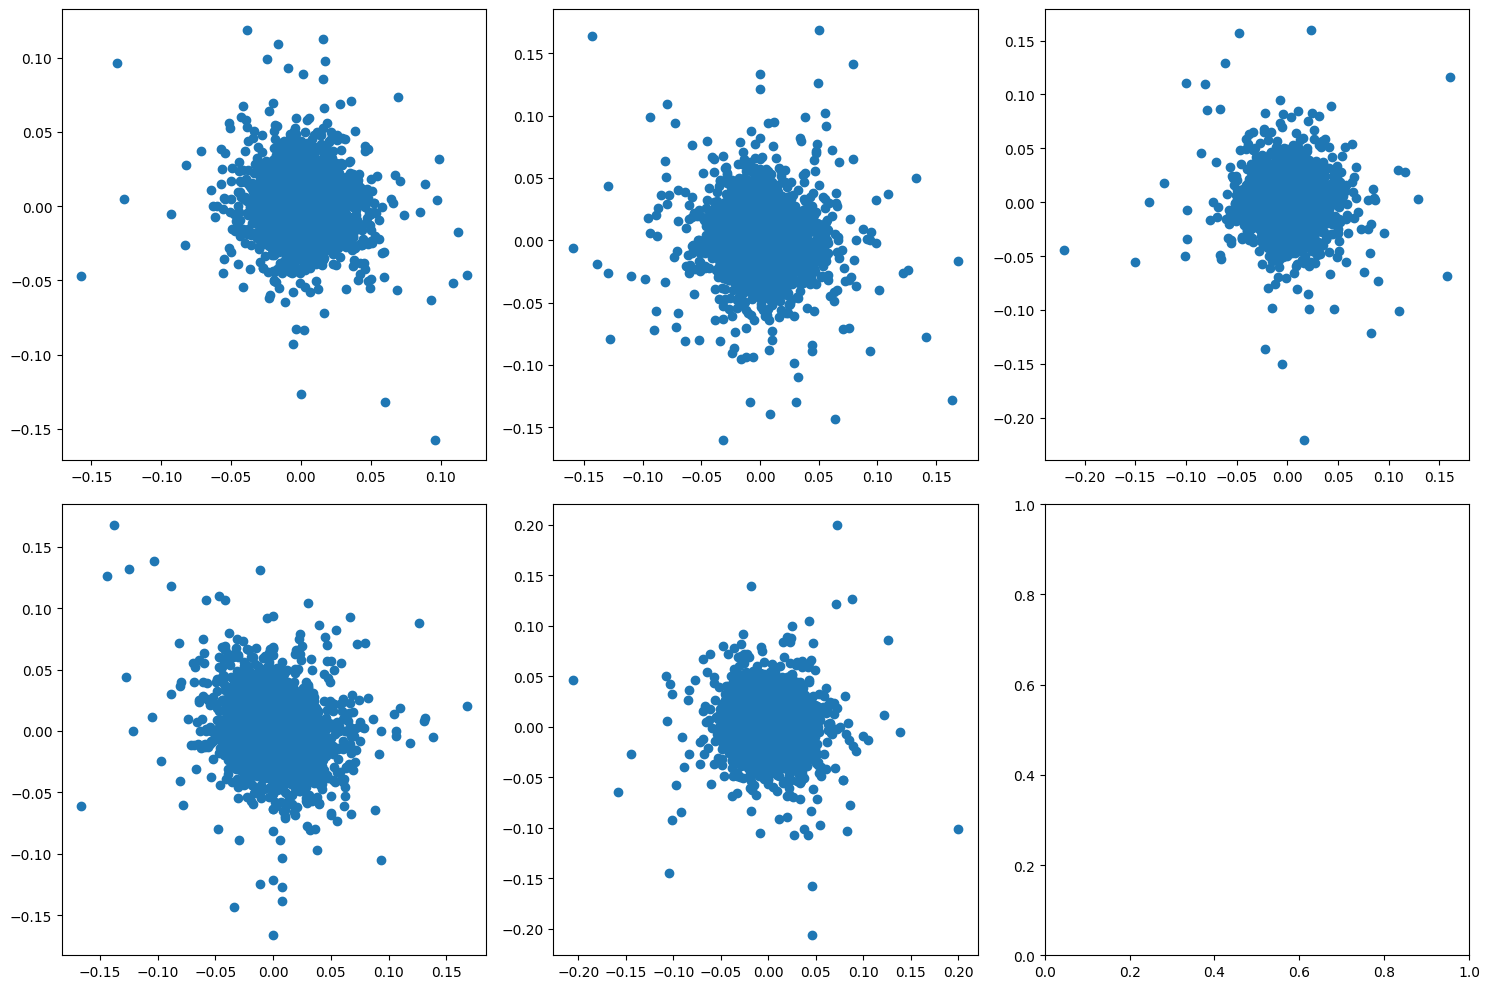

In [48]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

return_cols = [col for col in exploration_df.columns.tolist() if "Return" in col and "lag" not in col]
for i, col in enumerate(return_cols):
    new_df = pd.DataFrame()
    new_df[col] = exploration_df[col]
    new_df[f"{col}_shifted"] = exploration_df[col].shift(1)
    new_df.dropna(axis=0, inplace=True)
    print(f"corr between {col} and itself lagged: {pearsonr(new_df[col], new_df[f'{col}_shifted'])}")

    axes[i].scatter(new_df[col], new_df[f'{col}_shifted'])

plt.tight_layout()
plt.show()

Reforçando o argumento pró-retornos. As séries de preços tem alta correlação entre a série e a série atrasada, enquanto a série de retornos diferenciada não, mas a alta correlação é devido a tendência linear e não devido a poder preditivo real.

## Montando o dataframe

In [49]:
def compute_lags(df: pd.DataFrame, column_names: list[str], lags: int = 5):
    df = df.copy()
    
    for col in column_names:
        if "Return" in col:
            for i in range(lags - 1):
                df[f"{col}_lag_{i+1}"] = df[f"{col}"].shift(i+1)
    return df

In [50]:
stocks_df.head()

Price_abev3  Price_bbdc3  Price_itub3  Price_itsa3  Price_wege3
Date                                                                       
2007-10-04         2.99         6.00         7.44         3.48         2.40
2007-10-05         3.06         6.30         7.86         3.52         2.43
2007-10-08         3.06         6.31         7.95         3.43         2.45
2007-10-09         3.08         6.38         8.30         3.44         2.44
2007-10-10         3.04         6.35         8.15         3.43         2.43

In [51]:
exploration_df.head()

Price_abev3  Price_bbdc3  Price_itub3  Price_itsa3  Price_wege3  \
Date                                                                          
2007-10-11         3.08         6.20         7.87         3.43         2.44   
2007-10-15         3.02         6.09         7.75         3.43         2.47   
2007-10-16         2.94         5.97         7.61         3.48         2.47   
2007-10-17         3.06         6.09         7.86         3.48         2.57   
2007-10-18         3.07         6.09         7.69         3.48         2.59   

            Return_abev3  Return_bbdc3  Return_itub3  Return_itsa3  \
Date                                                                 
2007-10-11      0.013158     -0.023622     -0.034356      0.000000   
2007-10-15     -0.019481     -0.017742     -0.015248      0.000000   
2007-10-16     -0.026490     -0.019704     -0.018065      0.014577   
2007-10-17      0.040816      0.020101      0.032852      0.000000   
2007-10-18      0.003268      0.000000     -0.021628      0.000000   

            Return_wege3  
Date                      
2007-10-11      0.004115  
2007-10-15      0.012295  
2007-10-16      0.000000  
2007-10-17      0.040486  
2007-10-18      0.007782

In [52]:
def compute_targets(df: pd.DataFrame, stock_names: list[str]):
    df = df.copy()

    for col in stock_names:
        df[f"{col}_y"] = df[f"Return_{col}"].shift(-1) > 0
    return df

In [53]:
stocks = ["abev3", "bbdc3", "itsa3", "itub3", "wege3"]

In [54]:
exploration_df = compute_targets(exploration_df, stocks)
exploration_df.head(15)

Price_abev3  Price_bbdc3  Price_itub3  Price_itsa3  Price_wege3  \
Date                                                                          
2007-10-11         3.08         6.20         7.87         3.43         2.44   
2007-10-15         3.02         6.09         7.75         3.43         2.47   
2007-10-16         2.94         5.97         7.61         3.48         2.47   
2007-10-17         3.06         6.09         7.86         3.48         2.57   
2007-10-18         3.07         6.09         7.69         3.48         2.59   
2007-10-19         3.00         6.09         7.52         3.43         2.57   
2007-10-22         3.00         6.13         7.57         3.50         2.54   
2007-10-23         3.00         6.19         7.70         3.38         2.58   
2007-10-24         3.00         6.23         7.59         3.46         2.65   
2007-10-25         2.95         6.09         7.44         3.45         2.66   
2007-10-26         2.97         6.30         7.71         3.45         2.70   
2007-10-29         2.99         6.29         7.87         3.40         2.74   
2007-10-30         3.03         6.21         7.76         3.43         2.75   
2007-10-31         3.08         6.36         7.87         3.43         2.84   
2007-11-01         3.09         6.03         7.61         3.44         2.87   

            Return_abev3  Return_bbdc3  Return_itub3  Return_itsa3  \
Date                                                                 
2007-10-11      0.013158     -0.023622     -0.034356      0.000000   
2007-10-15     -0.019481     -0.017742     -0.015248      0.000000   
2007-10-16     -0.026490     -0.019704     -0.018065      0.014577   
2007-10-17      0.040816      0.020101      0.032852      0.000000   
2007-10-18      0.003268      0.000000     -0.021628      0.000000   
2007-10-19     -0.022801      0.000000     -0.022107     -0.014368   
2007-10-22      0.000000      0.006568      0.006649      0.020408   
2007-10-23      0.000000      0.009788      0.017173     -0.034286   
2007-10-24      0.000000      0.006462     -0.014286      0.023669   
2007-10-25     -0.016667     -0.022472     -0.019763     -0.002890   
2007-10-26      0.006780      0.034483      0.036290      0.000000   
2007-10-29      0.006734     -0.001587      0.020752     -0.014493   
2007-10-30      0.013378     -0.012719     -0.013977      0.008824   
2007-10-31      0.016502      0.024155      0.014175      0.000000   
2007-11-01      0.003247     -0.051887     -0.033037      0.002915   

            Return_wege3  abev3_y  bbdc3_y  itsa3_y  itub3_y  wege3_y  
Date                                                                   
2007-10-11      0.004115    False    False    False    False     True  
2007-10-15      0.012295    False    False     True    False    False  
2007-10-16      0.000000     True     True    False     True     True  
2007-10-17      0.040486     True    False    False    False     True  
2007-10-18      0.007782    False    False    False    False    False  
2007-10-19     -0.007722    False     True     True     True    False  
2007-10-22     -0.011673    False     True    False     True     True  
2007-10-23      0.015748    False     True     True    False     True  
2007-10-24      0.027132    False    False    False    False     True  
2007-10-25      0.003774     True     True    False     True     True  
2007-10-26      0.015038     True    False    False     True     True  
2007-10-29      0.014815     True    False     True    False     True  
2007-10-30      0.003650     True     True    False     True     True  
2007-10-31      0.032727     True    False     True    False     True  
2007-11-01      0.010563    False     True    False    False     True

In [55]:
exploration_df = compute_lags(exploration_df, exploration_df.columns.tolist())

exploration_df.head()

Price_abev3  Price_bbdc3  Price_itub3  Price_itsa3  Price_wege3  \
Date                                                                          
2007-10-11         3.08         6.20         7.87         3.43         2.44   
2007-10-15         3.02         6.09         7.75         3.43         2.47   
2007-10-16         2.94         5.97         7.61         3.48         2.47   
2007-10-17         3.06         6.09         7.86         3.48         2.57   
2007-10-18         3.07         6.09         7.69         3.48         2.59   

            Return_abev3  Return_bbdc3  Return_itub3  Return_itsa3  \
Date                                                                 
2007-10-11      0.013158     -0.023622     -0.034356      0.000000   
2007-10-15     -0.019481     -0.017742     -0.015248      0.000000   
2007-10-16     -0.026490     -0.019704     -0.018065      0.014577   
2007-10-17      0.040816      0.020101      0.032852      0.000000   
2007-10-18      0.003268      0.000000     -0.021628      0.000000   

            Return_wege3  ...  Return_itub3_lag_3  Return_itub3_lag_4  \
Date                      ...                                           
2007-10-11      0.004115  ...                 NaN                 NaN   
2007-10-15      0.012295  ...                 NaN                 NaN   
2007-10-16      0.000000  ...                 NaN                 NaN   
2007-10-17      0.040486  ...           -0.034356                 NaN   
2007-10-18      0.007782  ...           -0.015248           -0.034356   

            Return_itsa3_lag_1  Return_itsa3_lag_2  Return_itsa3_lag_3  \
Date                                                                     
2007-10-11                 NaN                 NaN                 NaN   
2007-10-15            0.000000                 NaN                 NaN   
2007-10-16            0.000000            0.000000                 NaN   
2007-10-17            0.014577            0.000000                 0.0   
2007-10-18            0.000000            0.014577                 0.0   

            Return_itsa3_lag_4  Return_wege3_lag_1  Return_wege3_lag_2  \
Date                                                                     
2007-10-11                 NaN                 NaN                 NaN   
2007-10-15                 NaN            0.004115                 NaN   
2007-10-16                 NaN            0.012295            0.004115   
2007-10-17                 NaN            0.000000            0.012295   
2007-10-18                 0.0            0.040486            0.000000   

            Return_wege3_lag_3  Return_wege3_lag_4  
Date                                                
2007-10-11                 NaN                 NaN  
2007-10-15                 NaN                 NaN  
2007-10-16                 NaN                 NaN  
2007-10-17            0.004115                 NaN  
2007-10-18            0.012295            0.004115  

[5 rows x 35 columns]

In [56]:
exploration_df[[col for col in exploration_df.columns.tolist() if "abev3" in col]].head()

Price_abev3  Return_abev3  abev3_y  Return_abev3_lag_1  \
Date                                                                 
2007-10-11         3.08      0.013158    False                 NaN   
2007-10-15         3.02     -0.019481    False            0.013158   
2007-10-16         2.94     -0.026490     True           -0.019481   
2007-10-17         3.06      0.040816     True           -0.026490   
2007-10-18         3.07      0.003268    False            0.040816   

            Return_abev3_lag_2  Return_abev3_lag_3  Return_abev3_lag_4  
Date                                                                    
2007-10-11                 NaN                 NaN                 NaN  
2007-10-15                 NaN                 NaN                 NaN  
2007-10-16            0.013158                 NaN                 NaN  
2007-10-17           -0.019481            0.013158                 NaN  
2007-10-18           -0.026490           -0.019481            0.013158

In [57]:
exploration_df[[col for col in exploration_df.columns.tolist() if "abev3" in col or "median" in col]].head(10)

Price_abev3  Return_abev3  abev3_y  Return_abev3_lag_1  \
Date                                                                 
2007-10-11         3.08      0.013158    False                 NaN   
2007-10-15         3.02     -0.019481    False            0.013158   
2007-10-16         2.94     -0.026490     True           -0.019481   
2007-10-17         3.06      0.040816     True           -0.026490   
2007-10-18         3.07      0.003268    False            0.040816   
2007-10-19         3.00     -0.022801    False            0.003268   
2007-10-22         3.00      0.000000    False           -0.022801   
2007-10-23         3.00      0.000000    False            0.000000   
2007-10-24         3.00      0.000000    False            0.000000   
2007-10-25         2.95     -0.016667     True            0.000000   

            Return_abev3_lag_2  Return_abev3_lag_3  Return_abev3_lag_4  
Date                                                                    
2007-10-11                 NaN                 NaN                 NaN  
2007-10-15                 NaN                 NaN                 NaN  
2007-10-16            0.013158                 NaN                 NaN  
2007-10-17           -0.019481            0.013158                 NaN  
2007-10-18           -0.026490           -0.019481            0.013158  
2007-10-19            0.040816           -0.026490           -0.019481  
2007-10-22            0.003268            0.040816           -0.026490  
2007-10-23           -0.022801            0.003268            0.040816  
2007-10-24            0.000000           -0.022801            0.003268  
2007-10-25            0.000000            0.000000           -0.022801

In [ ]:
exploration_df.head()

Price_abev3  Price_bbdc3  Price_itub3  Price_itsa3  Price_wege3  \
Date                                                                          
2007-10-11         3.08         6.20         7.87         3.43         2.44   
2007-10-15         3.02         6.09         7.75         3.43         2.47   
2007-10-16         2.94         5.97         7.61         3.48         2.47   
2007-10-17         3.06         6.09         7.86         3.48         2.57   
2007-10-18         3.07         6.09         7.69         3.48         2.59   

            Return_abev3  Return_bbdc3  Return_itub3  Return_itsa3  \
Date                                                                 
2007-10-11      0.013158     -0.023622     -0.034356      0.000000   
2007-10-15     -0.019481     -0.017742     -0.015248      0.000000   
2007-10-16     -0.026490     -0.019704     -0.018065      0.014577   
2007-10-17      0.040816      0.020101      0.032852      0.000000   
2007-10-18      0.003268      0.000000     -0.021628      0.000000   

            Return_wege3  ...  Return_itub3_lag_3  Return_itub3_lag_4  \
Date                      ...                                           
2007-10-11      0.004115  ...                 NaN                 NaN   
2007-10-15      0.012295  ...                 NaN                 NaN   
2007-10-16      0.000000  ...                 NaN                 NaN   
2007-10-17      0.040486  ...           -0.034356                 NaN   
2007-10-18      0.007782  ...           -0.015248           -0.034356   

            Return_itsa3_lag_1  Return_itsa3_lag_2  Return_itsa3_lag_3  \
Date                                                                     
2007-10-11                 NaN                 NaN                 NaN   
2007-10-15            0.000000                 NaN                 NaN   
2007-10-16            0.000000            0.000000                 NaN   
2007-10-17            0.014577            0.000000                 0.0   
2007-10-18            0.000000            0.014577                 0.0   

            Return_itsa3_lag_4  Return_wege3_lag_1  Return_wege3_lag_2  \
Date                                                                     
2007-10-11                 NaN                 NaN                 NaN   
2007-10-15                 NaN            0.004115                 NaN   
2007-10-16                 NaN            0.012295            0.004115   
2007-10-17                 NaN            0.000000            0.012295   
2007-10-18                 0.0            0.040486            0.000000   

            Return_wege3_lag_3  Return_wege3_lag_4  
Date                                                
2007-10-11                 NaN                 NaN  
2007-10-15                 NaN                 NaN  
2007-10-16                 NaN                 NaN  
2007-10-17            0.004115                 NaN  
2007-10-18            0.012295            0.004115  

[5 rows x 35 columns]

In [59]:
stocks_df.head()

Price_abev3  Price_bbdc3  Price_itub3  Price_itsa3  Price_wege3
Date                                                                       
2007-10-04         2.99         6.00         7.44         3.48         2.40
2007-10-05         3.06         6.30         7.86         3.52         2.43
2007-10-08         3.06         6.31         7.95         3.43         2.45
2007-10-09         3.08         6.38         8.30         3.44         2.44
2007-10-10         3.04         6.35         8.15         3.43         2.43

### Agregando todas as transformações necessárias em uma função

In [60]:
def preprocess_data(data: pd.DataFrame, stock_name: str) -> pd.DataFrame:
    data = data.copy()
    data = data.interpolate(method="linear")
    data = compute_returns_for_prices(data, [f"Price_{stock_name}"])
    data = compute_lags(data, [f"Return_{stock_name}"])
    data = compute_targets(data, [stock_name])
    data = data[[col for col in data.columns.tolist() if stock_name in col or "median" in col]].copy()
    data = data.drop(f"Price_{stock_name}", axis=1)
    data = data.dropna(axis=0)
    return data

preprocess_data(stocks_df.copy(), "abev3").head(10)

Return_abev3  Return_abev3_lag_1  Return_abev3_lag_2  \
Date                                                               
2007-10-11      0.013158           -0.012987            0.006536   
2007-10-15     -0.019481            0.013158           -0.012987   
2007-10-16     -0.026490           -0.019481            0.013158   
2007-10-17      0.040816           -0.026490           -0.019481   
2007-10-18      0.003268            0.040816           -0.026490   
2007-10-19     -0.022801            0.003268            0.040816   
2007-10-22      0.000000           -0.022801            0.003268   
2007-10-23      0.000000            0.000000           -0.022801   
2007-10-24      0.000000            0.000000            0.000000   
2007-10-25     -0.016667            0.000000            0.000000   

            Return_abev3_lag_3  Return_abev3_lag_4  abev3_y  
Date                                                         
2007-10-11            0.000000            0.023411    False  
2007-10-15            0.006536            0.000000    False  
2007-10-16           -0.012987            0.006536     True  
2007-10-17            0.013158           -0.012987     True  
2007-10-18           -0.019481            0.013158    False  
2007-10-19           -0.026490           -0.019481    False  
2007-10-22            0.040816           -0.026490    False  
2007-10-23            0.003268            0.040816    False  
2007-10-24           -0.022801            0.003268    False  
2007-10-25            0.000000           -0.022801     True

## Definindo o Sliding Window CV

In [61]:
# class SlidingWindowExclusiveTestCV(BaseCrossValidator):
#     def __init__(self, train_size: int, val_size: int):
#         self.train_size = train_size
#         self.val_size = val_size

#     def get_n_splits(self, X=None, y=None, groups=None):
#         """
#         On a CV splitter (not an estimator), returns the number of elements one would get if iterating through 
#         the return value of split given the same parameters. Takes the same parameters as split.
#         """
#         n_samples = len(X)
#         count = 0
#         for _ in range(0, n_samples - self.train_size - self.val_size + 1, self.val_size):
#             count += 1
#         return count

#     def split(self, X=None, y=None, groups=None):
#         """
#         On a CV splitter (not an estimator), this method accepts parameters (X, y, groups), where all may be optional, 
#         and returns an iterator over (train_idx, test_idx) pairs. Each of {train,test}_idx is a 1d integer array, 
#         with values from 0 from X.shape[0] - 1 of any length, such that no values appear in both some train_idx and 
#         its corresponding test_idx.
#         """
#         n_samples = len(X)
#         for start in range(0 + 5, n_samples - self.train_size - self.val_size + 1 + 5, self.val_size):
#             # print(start)
#             train_indices = np.arange(start, start + self.train_size)
#             test_indices = np.arange(start + self.train_size + 1, start + self.train_size + self.val_size + 1) # skip 1 day because last entry on training data would contain information from test set (whether next day goes up or down)
#             yield train_indices, test_indices


class SlidingWindowExclusiveTestCV(BaseCrossValidator):
    def __init__(self, train_size: int, val_size: int):
        self.train_size = train_size
        self.val_size = val_size

    def get_n_splits(self, X=None, y=None, groups=None):
        """
        On a CV splitter (not an estimator), returns the number of elements one would get if iterating through 
        the return value of split given the same parameters. Takes the same parameters as split.
        """
        n_samples = len(X)
        count = 0
        for _ in range(0, n_samples - self.train_size - self.val_size + 1, self.val_size):
            count += 1
        return count

    def split(self, X=None, y=None, groups=None):
        """
        On a CV splitter (not an estimator), this method accepts parameters (X, y, groups), where all may be optional, 
        and returns an iterator over (train_idx, test_idx) pairs. Each of {train,test}_idx is a 1d integer array, 
        with values from 0 from X.shape[0] - 1 of any length, such that no values appear in both some train_idx and 
        its corresponding test_idx.
        """
        n_samples = len(X)
        for start in range(0, n_samples - self.train_size - self.val_size + 1, self.val_size):
            # print(start)
            train_indices = np.arange(start, start + self.train_size)
            test_indices = np.arange(start + self.train_size, start + self.train_size + self.val_size)
            yield train_indices, test_indices

In [62]:
def check_time_index_overlap(dataframes):
    # Convert each DataFrame's index to a set for faster intersection checking
    index_sets = [set(df.index) for df in dataframes]
    
    # Check each pair of DataFrames for overlap
    for i in range(len(index_sets)):
        for j in range(i + 1, len(index_sets)):
            if index_sets[i].intersection(index_sets[j]):
                print(f"Overlap found between DataFrame {i} and DataFrame {j}")
                return True

    print("No overlap found; all time indices are mutually exclusive.")
    return False

### Visualizando o Cross Validator em ação

No overlap found; all time indices are mutually exclusive.


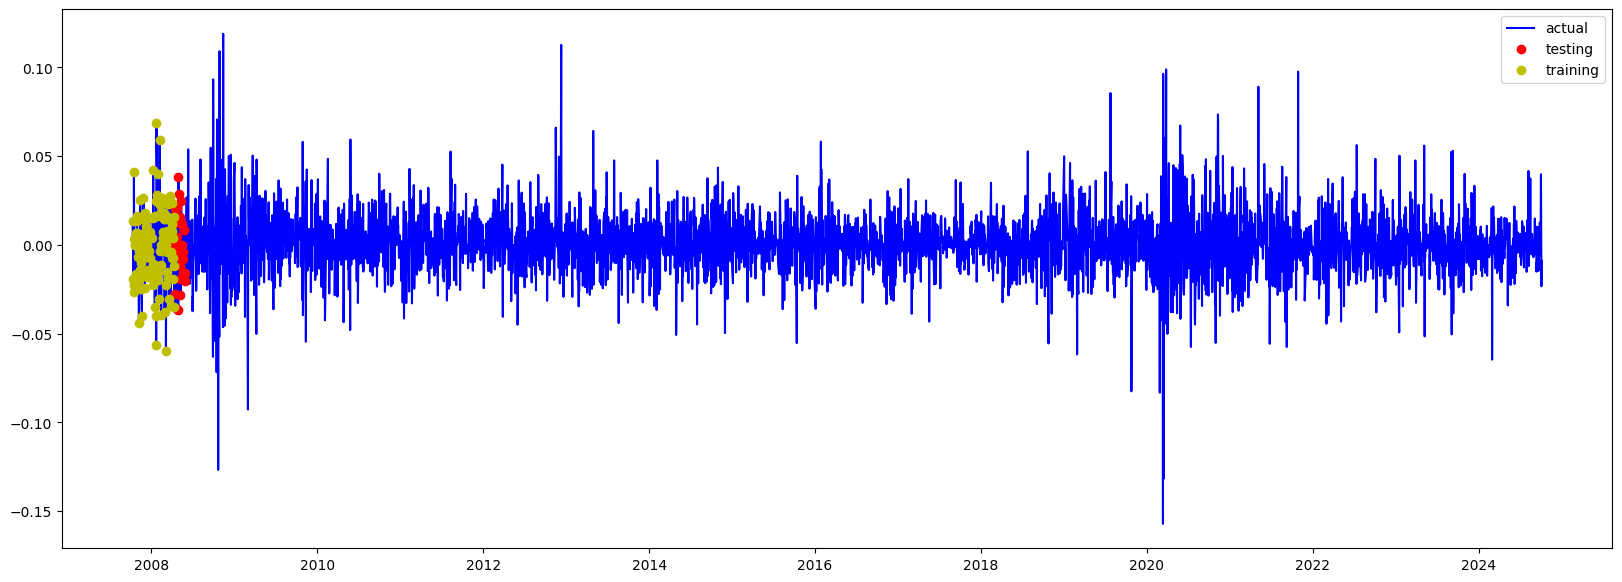

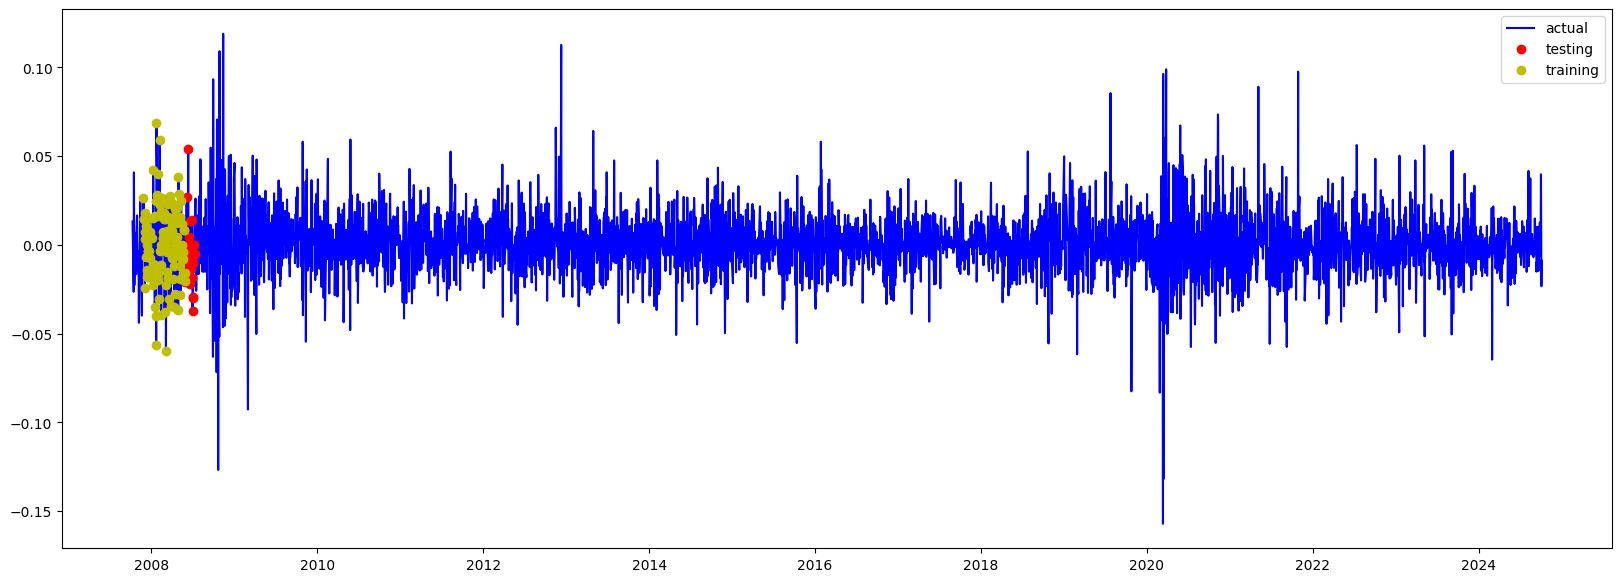

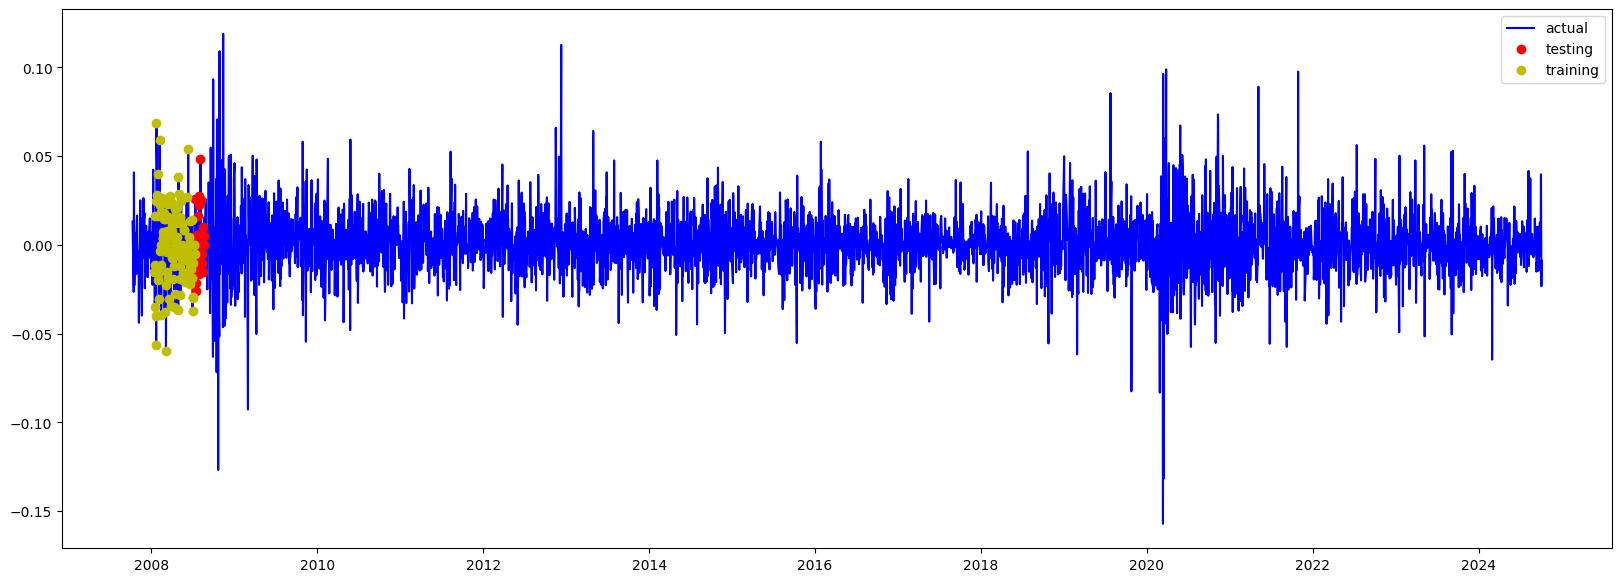

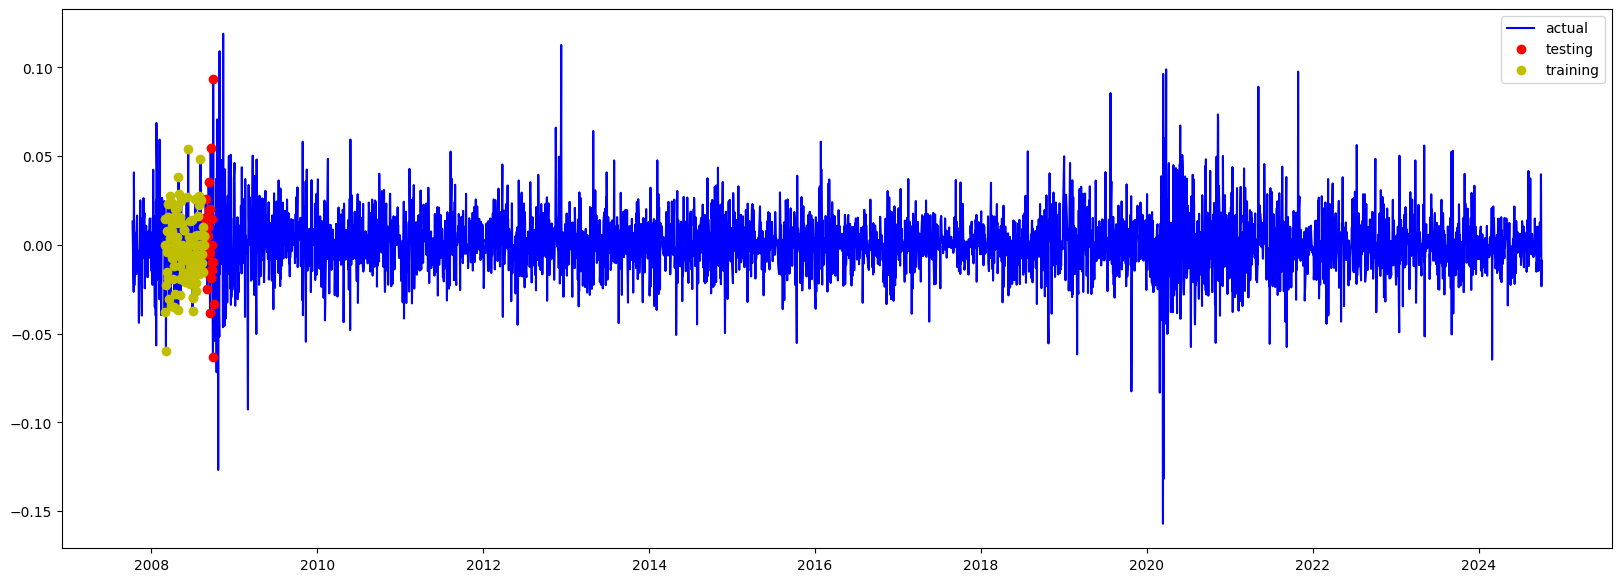

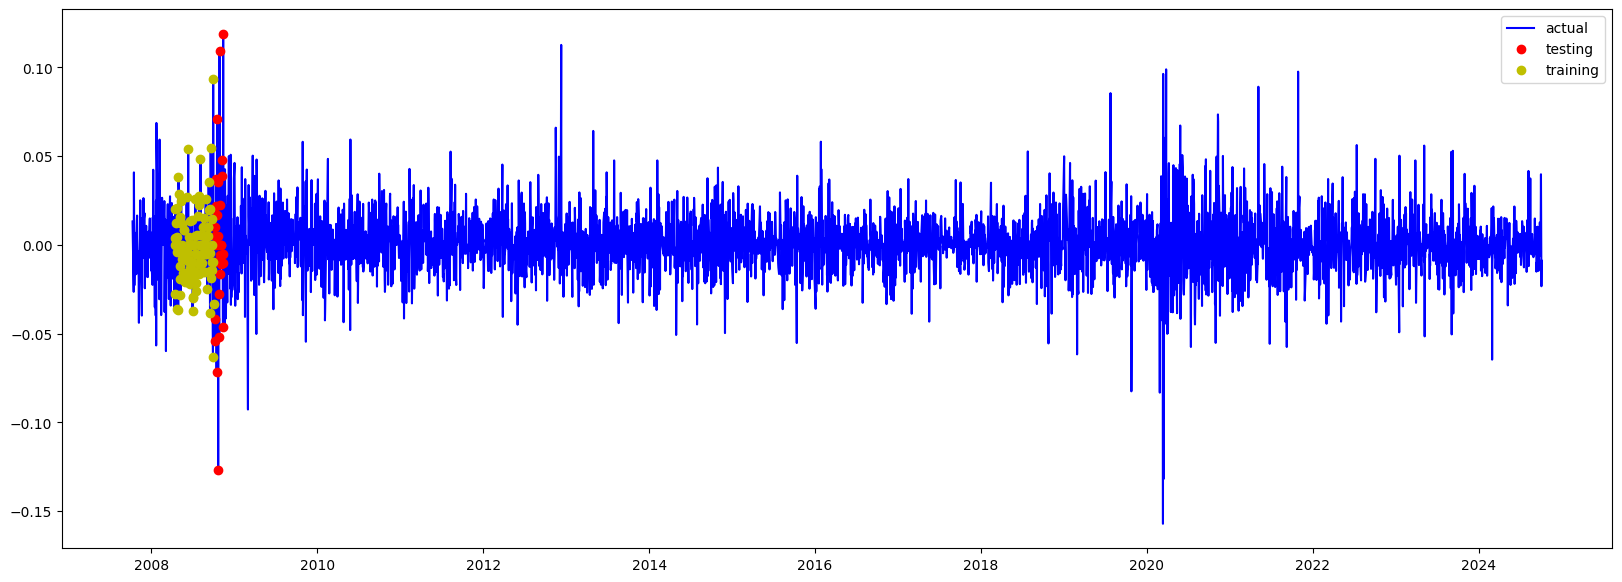

In [63]:
cv = SlidingWindowExclusiveTestCV(120, 30)

count = 0

tests = []
trains = []

df = preprocess_data(stocks_df, "abev3")

for train_index, test_index in cv.split(df["Return_abev3"]):
    X_train, X_test = df["Return_abev3"].iloc[train_index], df["Return_abev3"].iloc[test_index]
    # if count == 0:
    #     print(X_test)

    tests.append(X_test)
    trains.append(X_train)

    # if count == 0 or count % 10 == 0:
    if count in range(5):
        plt.figure(figsize=(20, 7))
        # plt.title(regression_metrics(y_test, y_test_pred))
        plt.plot(df.index, df["Return_abev3"], 'b-', label = 'actual')
        plt.plot(X_test.index, X_test, 'ro', label = 'testing')
        plt.plot(X_train.index, X_train, 'yo', label = 'training')
        plt.legend()
        plt.plot()

    count += 1

assert check_time_index_overlap(tests) == False
assert type(tests[0]) == pd.Series
assert trains[0].index[0] == df["Return_abev3"].index[0]
# print(count)

In [64]:
tests[0].index[-1], tests[1].index[0], tests[1].index[-1], tests[2].index[0], tests[2].index[-1], tests[3].index[0]

(Timestamp('2008-05-28 00:00:00'),
 Timestamp('2008-05-29 00:00:00'),
 Timestamp('2008-07-10 00:00:00'),
 Timestamp('2008-07-11 00:00:00'),
 Timestamp('2008-08-21 00:00:00'),
 Timestamp('2008-08-22 00:00:00'))

In [65]:
trains[1].index[-1], tests[1].index[0], trains[2].index[-1], tests[2].index[0], trains[3].index[-1], tests[3].index[0]

(Timestamp('2008-05-28 00:00:00'),
 Timestamp('2008-05-29 00:00:00'),
 Timestamp('2008-07-10 00:00:00'),
 Timestamp('2008-07-11 00:00:00'),
 Timestamp('2008-08-21 00:00:00'),
 Timestamp('2008-08-22 00:00:00'))

Treino e teste não aparentam estar vazando um no outro, e foi adicionado um gap de 1 data point entre cada treino e teste pois fundamentalmente, sem esse gap, o último dia de treino conteria informação referente ao primeiro dia de teste, constituindo data leakage

# LSTM

In [86]:
TRAINING_EPOCHS = 500
PATIENCE = int(TRAINING_EPOCHS * 0.1)

BATCH_SIZE = 64
NUM_EXPERIMENTS = 30

TRAIN_SIZE = 120
VAL_SIZE = 30

In [87]:
NN_HIDDEN_UNITS = 2
NN_HIDDEN_LAYERS = 2

In [88]:
def define_lstm(data_shape, num_units):
    lstm = Sequential()

    lstm.add(Input(shape=data_shape))
    # for _ in range(NN_HIDDEN_LAYERS):
    lstm.add(LSTM(num_units, return_sequences=True))
    lstm.add(LSTM(num_units))
    lstm.add(Dense(1, activation="sigmoid"))

    lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    return lstm

In [89]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=PATIENCE,
    restore_best_weights=True,
	mode='max'
)

In [90]:
def run_lstm_experiment(train_size: int, val_size: int, stock: str, num_units: int, random_seed: int):
    print(stock)
    np.random.seed(random_seed)
    random.seed(random_seed)
    tf.random.set_seed(random_seed)

    model = define_lstm((5, 1), num_units) # 5 time steps, 1 feature (return)
    cv_splitter = SlidingWindowExclusiveTestCV(train_size, val_size)

    tests = []
    results = {}
    ground_y = []

    start_time = datetime.now()
    for train_index, test_index in cv_splitter.split(stocks_df):
        preprocessed_train_data = preprocess_data(stocks_df.iloc[train_index], stock)
        preprocessed_test_data = preprocess_data(stocks_df.iloc[test_index], stock)
        
        train_features = preprocessed_train_data.drop([f"{stock}_y"], axis=1)
        train_targets = preprocessed_train_data[f"{stock}_y"]

        test_features = preprocessed_test_data.drop([f"{stock}_y"], axis=1)
        test_targets = preprocessed_test_data[f"{stock}_y"]

        # just so I can rename variables
        X_train, X_test = train_features, test_features
        y_train, y_test = train_targets, test_targets

        scaler = MinMaxScaler(feature_range=(-1, 1))
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(
            X_train, y_train,
            epochs = TRAINING_EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.2,
            callbacks=[early_stopping],
            shuffle=False,
            verbose=False,
        )

        y_hat = model.predict(X_test, verbose=False)

        # turn probas into labels
        y_hat = np.array(y_hat)
        for i in range(len(y_hat)):
            if y_hat[i] > 0.5:
                y_hat[i] = True
            else:
                y_hat[i] = False

        # append preds and grounds into array
        for i, y_pred in enumerate(y_hat):
            tests.append({y_test.index[i]: y_pred.astype(int)[0]})
        
        for i, y_true in enumerate(y_hat):
            ground_y.append({y_test.index[i]: y_test.iloc[i].astype(int)})
            
    end_time = datetime.now()
    
    # extract values from result data structure
    preds_to_compute = [list(i.values())[0] for i in tests]
    grounds_to_compute = [list(i.values())[0] for i in ground_y]
    
    results = {
        "accuracy": accuracy_score(grounds_to_compute, preds_to_compute),
        "f1": f1_score(grounds_to_compute, preds_to_compute),
        "precision": precision_score(grounds_to_compute, preds_to_compute, zero_division=0),
        "recall": recall_score(grounds_to_compute, preds_to_compute),
        "auc": roc_auc_score(grounds_to_compute, preds_to_compute),
        "dataset_fit_predict_time": (end_time - start_time).total_seconds()
    }

    # all_accs.append(np.array(accs).mean())
    np.random.seed(RANDOM_STATE)
    random.seed(RANDOM_STATE)
    tf.random.set_seed(RANDOM_STATE)

    return results, tests

In [91]:
results_lstm_1_path = "./results/lstm_01"

if not os.path.isfile(results_lstm_1_path):
    results_lstm_1 = []

    for i in range(NUM_EXPERIMENTS):
        print(f"EXECUTION NUMBER {i+1}")
        abev3_lstm_res, abev3_preds = run_lstm_experiment( 
            TRAIN_SIZE, 
            VAL_SIZE, 
            "abev3", 
            NN_HIDDEN_UNITS,
            i
        )

        bbdc3_lstm_res, bbdc3_preds = run_lstm_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "bbdc3", 
            NN_HIDDEN_UNITS,
            i
        )

        itsa3_lstm_res, itsa3_preds = run_lstm_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itsa3", 
            NN_HIDDEN_UNITS,
            i
        )

        itub3_lstm_res, itub3_preds = run_lstm_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itub3", 
            NN_HIDDEN_UNITS,
            i
        )

        wege3_lstm_res, wege3_preds = run_lstm_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "wege3", 
            NN_HIDDEN_UNITS,
            i
        )

        results_lstm_1.append({
            "abev3": (abev3_lstm_res, abev3_preds),
            "bbdc3": (bbdc3_lstm_res, bbdc3_preds),
            "itsa3": (itsa3_lstm_res, itsa3_preds),
            "itub3": (itub3_lstm_res, itub3_preds),
            "wege3": (wege3_lstm_res, wege3_preds)
        })

    !mkdir "./results/"
    with open(results_lstm_1_path, "wb") as f:
        pickle.dump(results_lstm_1, f)

else:
    with open(results_lstm_1_path, "rb") as f:
        results_lstm_1 = pickle.load(f)

EXECUTION NUMBER 1
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 2
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 3
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 4
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 5
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 6
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 7
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 8
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 9
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 10
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 11
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 12
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 13
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 14
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 15
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 16
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 17
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 18
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 19
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 20
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION

In [92]:
for i in results_lstm_1:
    print(i["abev3"][0])

{'accuracy': 0.508235294117647, 'f1': np.float64(0.3661865049279757), 'precision': np.float64(0.45956232159847765), 'recall': np.float64(0.30434782608695654), 'auc': np.float64(0.4955274706827501), 'dataset_fit_predict_time': 285.106788}
{'accuracy': 0.5223529411764706, 'f1': np.float64(0.24535315985130113), 'precision': np.float64(0.4672566371681416), 'recall': np.float64(0.166351606805293), 'auc': np.float64(0.5001642203910635), 'dataset_fit_predict_time': 289.014506}
{'accuracy': 0.5329411764705883, 'f1': np.float64(0.0), 'precision': np.float64(0.0), 'recall': np.float64(0.0), 'auc': np.float64(0.4997242140099283), 'dataset_fit_predict_time': 297.115488}
{'accuracy': 0.51, 'f1': np.float64(0.43905723905723903), 'precision': np.float64(0.47143890093998553), 'recall': np.float64(0.41083805923125394), 'auc': np.float64(0.5038194708732111), 'dataset_fit_predict_time': 291.545437}
{'accuracy': 0.5320588235294118, 'f1': np.float64(0.19848866498740556), 'precision': np.float64(0.494974874

In [93]:
return_cols = [col for col in exploration_df.columns.tolist() if "Return" in col and "lag" not in col]
return_cols

['Return_abev3',
 'Return_bbdc3',
 'Return_itub3',
 'Return_itsa3',
 'Return_wege3']

In [94]:
list(results_lstm_1[0]["abev3"][1][0].keys())[0], list(results_lstm_1[0]["bbdc3"][1][0].keys())[0], list(results_lstm_1[0]["itsa3"][1][0].keys())[0], list(results_lstm_1[0]["wege3"][1][0].keys())[0]

(Timestamp('2008-04-14 00:00:00'),
 Timestamp('2008-04-14 00:00:00'),
 Timestamp('2008-04-14 00:00:00'),
 Timestamp('2008-04-14 00:00:00'))

In [95]:
results_lstm_1[0]["abev3"][1][0].keys()

dict_keys([Timestamp('2008-04-14 00:00:00')])

In [96]:
list(results_lstm_1[0]["abev3"][1][-1].keys())[0], list(results_lstm_1[0]["bbdc3"][1][-1].keys())[0], list(results_lstm_1[0]["itsa3"][1][-1].keys())[0], list(results_lstm_1[0]["wege3"][1][-1].keys())[0]

(Timestamp('2024-09-12 00:00:00'),
 Timestamp('2024-09-12 00:00:00'),
 Timestamp('2024-09-12 00:00:00'),
 Timestamp('2024-09-12 00:00:00'))

Séries começam e terminam no mesmo ponto

In [97]:
start_date1 = list(results_lstm_1[0]["abev3"][1][0].keys())[0]
end_date1 = list(results_lstm_1[0]["abev3"][1][-1].keys())[0]

In [98]:
daily_returns = exploration_df[return_cols].loc[start_date1 : end_date1]
daily_returns

Return_abev3  Return_bbdc3  Return_itub3  Return_itsa3  \
Date                                                                 
2008-04-14      0.000000     -0.019455      0.013554      0.003086   
2008-04-15      0.004032      0.005952     -0.004458      0.003077   
2008-04-16      0.020080      0.037475      0.014925      0.015337   
2008-04-17     -0.027559      0.013308      0.026471      0.039275   
2008-04-18      0.012146      0.007505      0.025788     -0.029070   
...                  ...           ...           ...           ...   
2024-09-06      0.001542     -0.014604     -0.008576      0.001792   
2024-09-09      0.009238      0.002823      0.002162      0.000894   
2024-09-10      0.009916      0.002815      0.001850      0.004468   
2024-09-11     -0.015106     -0.015439     -0.002154     -0.002669   
2024-09-12     -0.009969     -0.006415     -0.003084      0.000000   

            Return_wege3  
Date                      
2008-04-14     -0.033493  
2008-04-15      0.009901  
2008-04-16      0.004902  
2008-04-17      0.000000  
2008-04-18     -0.014634  
...                  ...  
2024-09-06     -0.020586  
2024-09-09     -0.008142  
2024-09-10      0.008400  
2024-09-11      0.011549  
2024-09-12     -0.003556  

[4075 rows x 5 columns]

TODO: validar computação do sharpe ratio

In [99]:
def compute_sharpe_ratio(portfolio_daily_returns):
    risk_free_daily_rate = ((1 + 0.10) ** (1 / 252)) - 1  # considering SELIC at an arbitrary avg of 10% year over 252 trading days

    avg_return = portfolio_daily_returns.mean()
    std_dev_return = portfolio_daily_returns.std()

    return (avg_return - risk_free_daily_rate) / std_dev_return

In [100]:
def compute_buyandhold_cumulative_returns(returns_series):
    # Define portfolio weights (example: equal weights for each stock)
    weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

    # Calculate daily portfolio returns
    portfolio_returns = returns_series.dot(weights)

    # Calculate cumulative returns
    cumulative_returns = (1 + portfolio_returns).cumprod()

    # Convert to DataFrame for plotting
    cumulative_returns_df = pd.DataFrame({'Cumulative Return': cumulative_returns}, index=returns_series.index)

    return cumulative_returns_df, portfolio_returns

In [101]:
def plot_cumulative_returns_line_chart(series, title = "Cumulative Returns over time"):
    plt.figure(figsize=(20, 7))
    plt.plot(series.index, series, 'b-')
    plt.title(title)

    max_idx = np.nanargmax(series)
    min_idx = np.nanargmin(series)

    print(series.to_numpy()[min_idx])

    plt.annotate(
        f"Max: {series.to_numpy()[max_idx]}",
        (series.index[max_idx], series.to_numpy()[max_idx]),
        xytext=(series.index[max_idx], series.to_numpy()[max_idx] + 0.5),
        arrowprops=dict(facecolor='green', arrowstyle='->'),
        color='green',
    )

    plt.annotate(
        f"Min: {series.to_numpy()[min_idx]}",
        (series.index[min_idx], series.to_numpy()[min_idx]),
        xytext=(series.index[min_idx], series.to_numpy()[min_idx] - 2),
        arrowprops=dict(facecolor='red', arrowstyle='->'),
        color='red',
    )
    plt.plot()

[0.60909923]


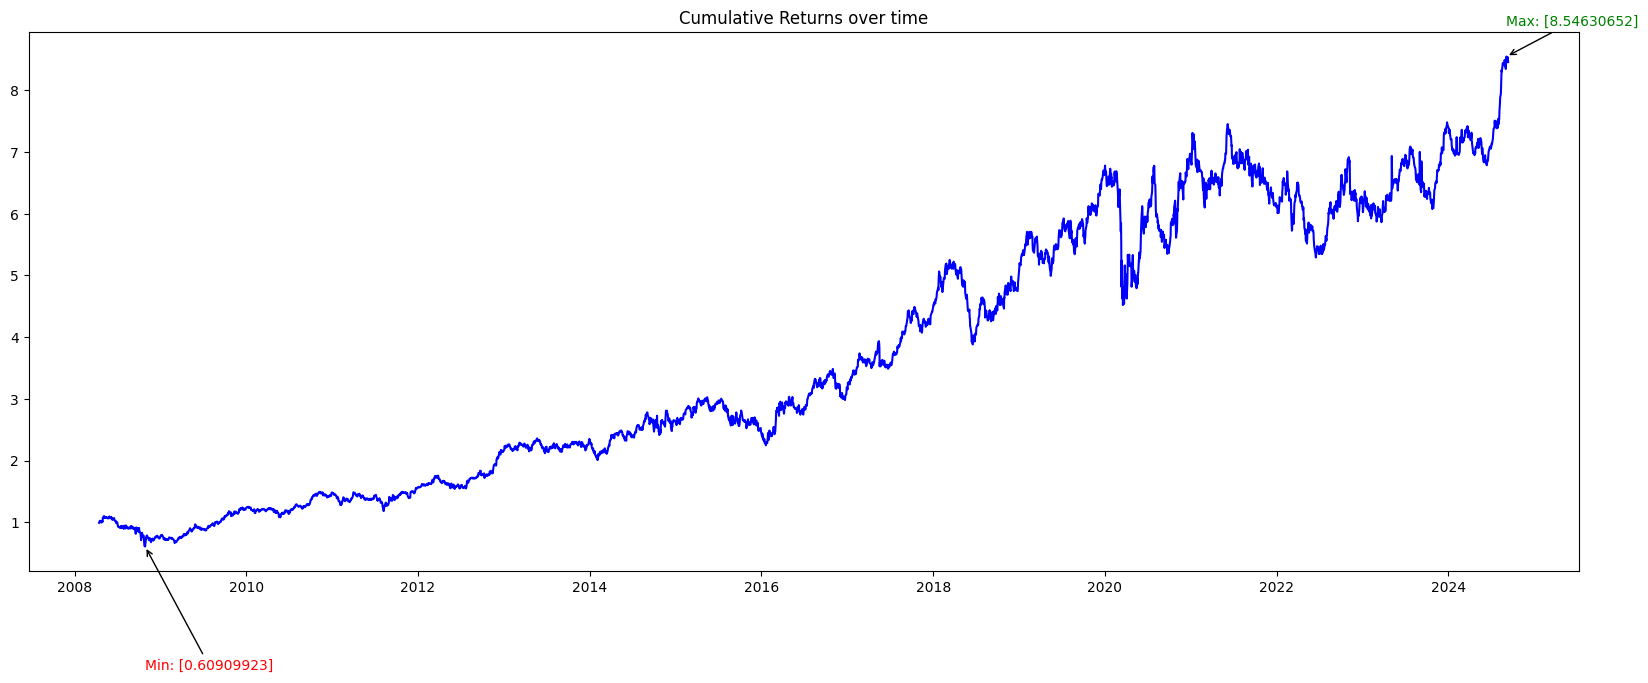

In [102]:
buy_and_hold_cuml_returns, portfolio_returns = compute_buyandhold_cumulative_returns(daily_returns)
plot_cumulative_returns_line_chart(buy_and_hold_cuml_returns)

In [103]:
buy_and_hold_sharpe = compute_sharpe_ratio(portfolio_returns)
buy_and_hold_sharpe

np.float64(0.017230075011876338)

In [104]:
def compute_cumulative_returns_pred(abev3_preds, bbdc3_preds, itsa3_preds, itub3_preds, wege3_preds):
    inclusion_mask = pd.DataFrame({
    'Return_abev3': pd.Series([list(val.values())[0] for val in abev3_preds], index=[list(val.keys())[0] for val in abev3_preds]),
    'Return_bbdc3': pd.Series([list(val.values())[0] for val in bbdc3_preds], index=[list(val.keys())[0] for val in bbdc3_preds]),
    'Return_itsa3': pd.Series([list(val.values())[0] for val in itsa3_preds], index=[list(val.keys())[0] for val in itsa3_preds]),
    'Return_itub3': pd.Series([list(val.values())[0] for val in itub3_preds], index=[list(val.keys())[0] for val in itub3_preds]),
    'Return_wege3': pd.Series([list(val.values())[0] for val in wege3_preds], index=[list(val.keys())[0] for val in wege3_preds]),
    })

    # Apply mask to daily returns
    adjusted_returns = daily_returns * inclusion_mask.shift(1)
    adjusted_returns = adjusted_returns.dropna(axis=0)

    weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
    # Adjust weights based on inclusion mask
    effective_weights = inclusion_mask * weights  # Set weight to 0 for excluded stocks

    # # Normalize weights so they sum up to 1 for each day
    normalized_weights = effective_weights.div(effective_weights.sum(axis=1), axis=0).fillna(0)

    # Calculate daily portfolio returns with adjusted weights
    portfolio_returns = (adjusted_returns * normalized_weights).sum(axis=1)

    # # Step 6: Calculate cumulative returns
    cumulative_returns_pred = (1 + portfolio_returns).cumprod()

    # # Convert to DataFrame for plotting
    cumulative_returns_pred_df = pd.DataFrame({'Cumulative Return': cumulative_returns_pred}, index=daily_returns.index)

    return cumulative_returns_pred_df, portfolio_returns

In [105]:
def find_best_experiment(experiments):
    max_sharpe = float("-inf")
    best_results = None
    best_cuml_performance = None
    best_idx = -1

    for i, experiment in enumerate(experiments):
        cuml_pred_df, exp_portfolio_returns = compute_cumulative_returns_pred(
            experiment["abev3"][1],
            experiment["bbdc3"][1],
            experiment["itsa3"][1],
            experiment["itub3"][1],
            experiment["wege3"][1]
        )

        sharpe = compute_sharpe_ratio(exp_portfolio_returns)
        if sharpe > max_sharpe:
            max_sharpe = sharpe
            best_results = experiment
            best_cuml_performance = cuml_pred_df
            best_idx = i

    print(f"Selected exp number {best_idx+1}")

    return best_results, best_cuml_performance, max_sharpe

In [106]:
def find_worst_experiment(experiments):
    min_sharpe = float("inf")
    worst_results = None
    worst_cuml_performance = None
    worst_idx = -1

    for i, experiment in enumerate(experiments):
        cuml_pred_df, exp_portfolio_returns = compute_cumulative_returns_pred(
            experiment["abev3"][1],
            experiment["bbdc3"][1],
            experiment["itsa3"][1],
            experiment["itub3"][1],
            experiment["wege3"][1]
        )

        sharpe = compute_sharpe_ratio(exp_portfolio_returns)
        if sharpe < min_sharpe:
            min_sharpe = sharpe
            worst_results = experiment
            worst_cuml_performance = cuml_pred_df
            worst_idx = i

    print(f"Selected exp number {worst_idx+1}")

    return worst_results, worst_cuml_performance, min_sharpe

In [107]:
best_results_lstm_01, cuml_perf_lstm_01, max_sharpe_lstm_01 = find_best_experiment(results_lstm_1)

Selected exp number 9


In [108]:
# plot_cumulative_returns_line_chart(cuml_perf_lstm_01)

In [109]:
def plot_two_returns_series(series1, series2, label1, label2, index, title="Portfolio Comparison between Buy & Hold and Model"):
    plt.figure(figsize=(20, 7))
    plt.plot(index, series1, 'b-', label = label1)
    plt.plot(index, series2, 'r-', label = label2)
    plt.title(title)
    plt.legend()

    for i_pos, series in enumerate([series1, series2]):
        max_idx = np.nanargmax(series)
        min_idx = np.nanargmin(series)

        print(series.to_numpy()[min_idx])

        plt.annotate(
            f"Max: {series.to_numpy()[max_idx]}",
            (series.index[max_idx], series.to_numpy()[max_idx]),
            xytext=(series.index[max_idx], series.to_numpy()[max_idx] + 0.5),
            arrowprops=dict(facecolor='green', arrowstyle='->'),
            color='green',
        )

        plt.annotate(
            f"Min: {series.to_numpy()[min_idx]}",
            (series.index[min_idx], series.to_numpy()[min_idx]),
            xytext=(series.index[min_idx], series.to_numpy()[min_idx] - (i_pos+1)*2),
            arrowprops=dict(facecolor='red', arrowstyle='->'),
            color='red',
        )

    plt.plot()

[0.9641627]
[0.60909923]


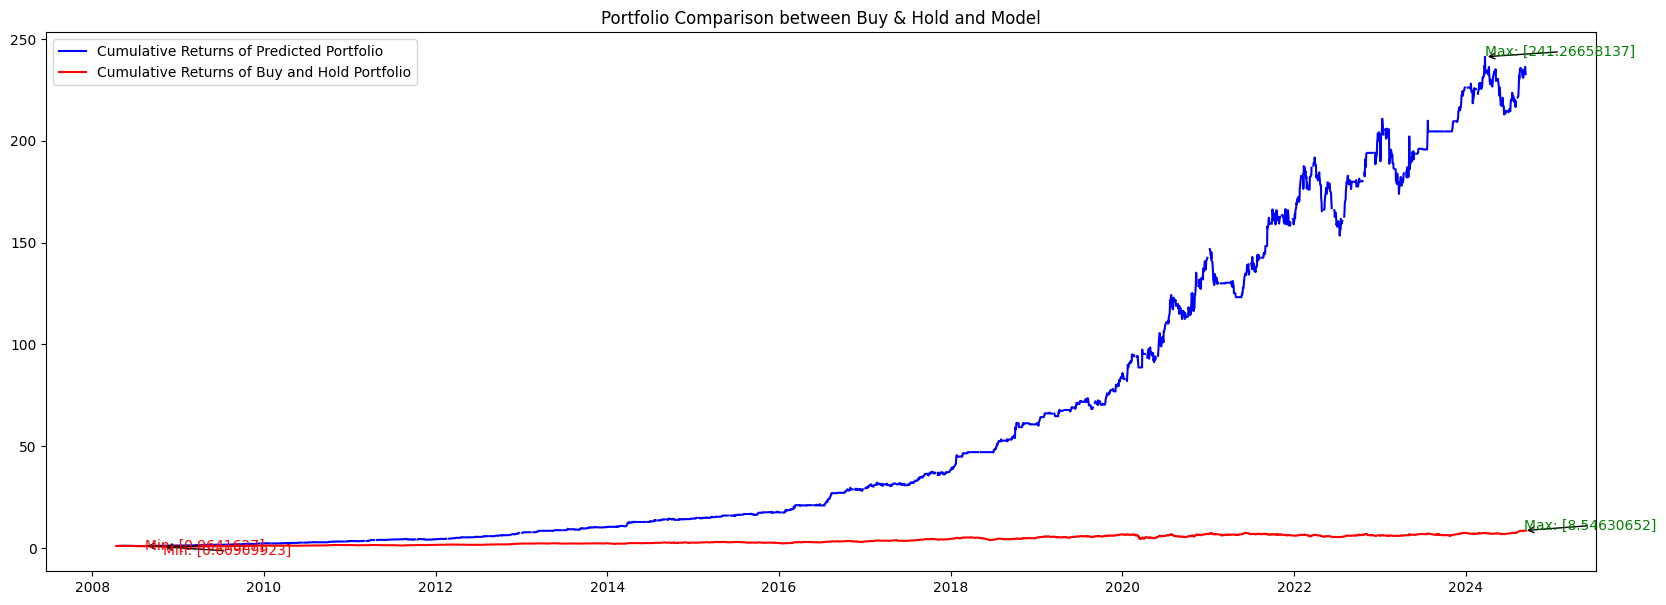

In [110]:
buy_and_hold1, _ = compute_buyandhold_cumulative_returns(exploration_df[return_cols].loc[start_date1 : end_date1])

plot_two_returns_series(
    cuml_perf_lstm_01, 
    buy_and_hold1,
    "Cumulative Returns of Predicted Portfolio", 
    "Cumulative Returns of Buy and Hold Portfolio", 
    daily_returns.index
)

In [111]:
max_sharpe_lstm_01, buy_and_hold_sharpe

(np.float64(0.11022945621521726), np.float64(0.017230075011876338))

# GRU

In [112]:
def define_gru(data_shape, num_units):
    gru = Sequential()

    gru.add(Input(shape=data_shape))
    gru.add(GRU(num_units, return_sequences=True))
    gru.add(GRU(num_units))
    gru.add(Dense(1, activation="sigmoid"))

    gru.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    return gru

In [113]:
def run_gru_experiment(train_size: int, val_size: int, stock: str, num_units: int, random_seed: int):
    print(stock)
    np.random.seed(random_seed)
    random.seed(random_seed)
    tf.random.set_seed(random_seed)

    model = define_gru((5, 1), num_units) # 5 time steps, 1 feature (return)
    cv_splitter = SlidingWindowExclusiveTestCV(train_size, val_size)

    tests = []
    results = {}
    ground_y = []

    start_time = datetime.now()
    for train_index, test_index in cv_splitter.split(stocks_df):
        preprocessed_train_data = preprocess_data(stocks_df.iloc[train_index], stock)
        preprocessed_test_data = preprocess_data(stocks_df.iloc[test_index], stock)
        
        train_features = preprocessed_train_data.drop([f"{stock}_y"], axis=1)
        train_targets = preprocessed_train_data[f"{stock}_y"]

        test_features = preprocessed_test_data.drop([f"{stock}_y"], axis=1)
        test_targets = preprocessed_test_data[f"{stock}_y"]

        # just so I can rename variables
        X_train, X_test = train_features, test_features
        y_train, y_test = train_targets, test_targets

        scaler = MinMaxScaler(feature_range=(-1, 1))
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(
            X_train, y_train,
            epochs = TRAINING_EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.2,
            callbacks=[early_stopping],
            shuffle=False,
            verbose=False,
        )

        y_hat = model.predict(X_test, verbose=False)

        # turn probas into labels
        y_hat = np.array(y_hat)
        for i in range(len(y_hat)):
            if y_hat[i] > 0.5:
                y_hat[i] = True
            else:
                y_hat[i] = False

        # append preds and grounds into array
        for i, y_pred in enumerate(y_hat):
            tests.append({y_test.index[i]: y_pred.astype(int)[0]})
        
        for i, y_true in enumerate(y_hat):
            ground_y.append({y_test.index[i]: y_test.iloc[i].astype(int)})
            
    end_time = datetime.now()
    
    # extract values from result data structure
    preds_to_compute = [list(i.values())[0] for i in tests]
    grounds_to_compute = [list(i.values())[0] for i in ground_y]
    
    results = {
        "accuracy": accuracy_score(grounds_to_compute, preds_to_compute),
        "f1": f1_score(grounds_to_compute, preds_to_compute),
        "precision": precision_score(grounds_to_compute, preds_to_compute, zero_division=0),
        "recall": recall_score(grounds_to_compute, preds_to_compute),
        "auc": roc_auc_score(grounds_to_compute, preds_to_compute),
        "dataset_fit_predict_time": (end_time - start_time).total_seconds()
    }

    # all_accs.append(np.array(accs).mean())
    np.random.seed(RANDOM_STATE)
    random.seed(RANDOM_STATE)
    tf.random.set_seed(RANDOM_STATE)

    return results, tests

In [114]:
results_gru_1_path = "./results/gru_01"

if not os.path.isfile(results_gru_1_path):
    results_gru_1 = []

    for i in range(NUM_EXPERIMENTS):
        print(f"Experiment {i+1}")
        abev3_gru_res, abev3_gru_preds = run_gru_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "abev3",
            NN_HIDDEN_UNITS,
            i
        )

        bbdc3_gru_res, bbdc3_gru_preds = run_gru_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "bbdc3", 
            NN_HIDDEN_UNITS,
            i
        )

        itsa3_gru_res, itsa3_gru_preds = run_gru_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itsa3", 
            NN_HIDDEN_UNITS,
            i
        )

        itub3_gru_res, itub3_gru_preds = run_gru_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itub3", 
            NN_HIDDEN_UNITS,
            i
        )

        wege3_gru_res, wege3_gru_preds = run_gru_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "wege3", 
            NN_HIDDEN_UNITS,
            i
        )

        results_gru_1.append({
            "abev3": (abev3_gru_res, abev3_gru_preds),
            "bbdc3": (bbdc3_gru_res, bbdc3_gru_preds),
            "itsa3": (itsa3_gru_res, itsa3_gru_preds),
            "itub3": (itub3_gru_res, itub3_gru_preds),
            "wege3": (wege3_gru_res, wege3_gru_preds)
        })

    !mkdir "./results/"
    with open(results_gru_1_path, "wb") as f:
        pickle.dump(results_gru_1, f)

else:
    with open(results_gru_1_path, "rb") as f:
        results_gru_1 = pickle.load(f)

Experiment 1
abev3
bbdc3
itsa3
itub3
wege3
Experiment 2
abev3
bbdc3
itsa3
itub3
wege3
Experiment 3
abev3
bbdc3
itsa3
itub3
wege3
Experiment 4
abev3
bbdc3
itsa3
itub3
wege3
Experiment 5
abev3
bbdc3
itsa3
itub3
wege3
Experiment 6
abev3
bbdc3
itsa3
itub3
wege3
Experiment 7
abev3
bbdc3
itsa3
itub3
wege3
Experiment 8
abev3
bbdc3
itsa3
itub3
wege3
Experiment 9
abev3
bbdc3
itsa3
itub3
wege3
Experiment 10
abev3
bbdc3
itsa3
itub3
wege3
Experiment 11
abev3
bbdc3
itsa3
itub3
wege3
Experiment 12
abev3
bbdc3
itsa3
itub3
wege3
Experiment 13
abev3
bbdc3
itsa3
itub3
wege3
Experiment 14
abev3
bbdc3
itsa3
itub3
wege3
Experiment 15
abev3
bbdc3
itsa3
itub3
wege3
Experiment 16
abev3
bbdc3
itsa3
itub3
wege3
Experiment 17
abev3
bbdc3
itsa3
itub3
wege3
Experiment 18
abev3
bbdc3
itsa3
itub3
wege3
Experiment 19
abev3
bbdc3
itsa3
itub3
wege3
Experiment 20
abev3
bbdc3
itsa3
itub3
wege3
Experiment 21
abev3
bbdc3
itsa3
itub3
wege3
Experiment 22
abev3
bbdc3
itsa3
itub3
wege3
Experiment 23
abev3
bbdc3
itsa3
itub3
weg

A subdirectory or file ./results/ already exists.


In [115]:
best_results_gru_1, cuml_perf_gru_1, max_sharpe_gru_1 = find_best_experiment(results_gru_1)
# plot_cumulative_returns_line_chart(cuml_perf_gru_1)

Selected exp number 27


[0.91450844]
[0.60909923]


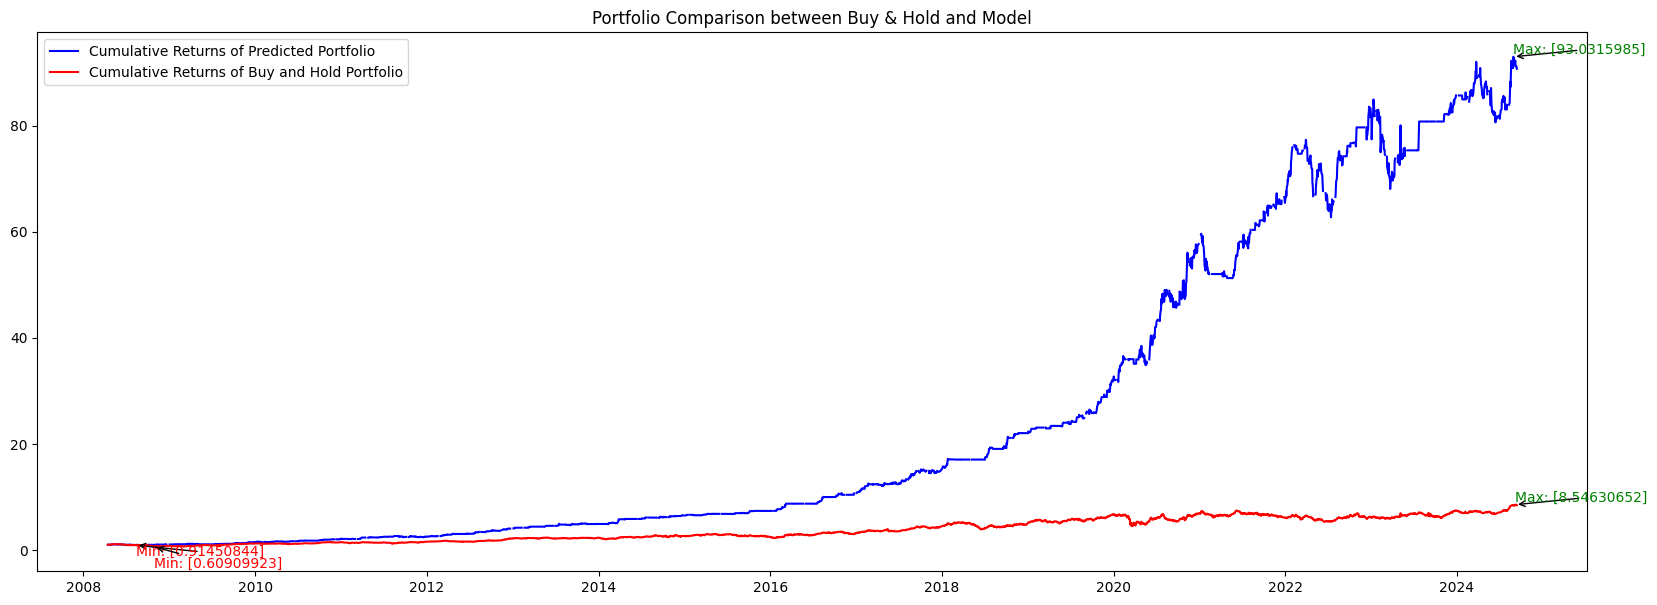

In [116]:
plot_two_returns_series(
    cuml_perf_gru_1, 
    buy_and_hold1,
    "Cumulative Returns of Predicted Portfolio", 
    "Cumulative Returns of Buy and Hold Portfolio", 
    daily_returns.index
)

In [117]:
max_sharpe_gru_1, buy_and_hold_sharpe

(np.float64(0.09523692350595893), np.float64(0.017230075011876338))

# RNN Simples

In [118]:
def define_rnn(data_shape, num_units):
    rnn = Sequential()

    rnn.add(Input(shape=data_shape))
    rnn.add(SimpleRNN(num_units, return_sequences=True))
    rnn.add(SimpleRNN(num_units))
    rnn.add(Dense(1, activation="sigmoid"))

    rnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    return rnn

In [119]:
def run_rnn_experiment(train_size: int, val_size: int, stock: str, num_units: int, random_seed: int):
    print(stock)
    np.random.seed(random_seed)
    random.seed(random_seed)
    tf.random.set_seed(random_seed)

    model = define_rnn((5, 1), num_units) # 5 time steps, 1 feature (return)
    cv_splitter = SlidingWindowExclusiveTestCV(train_size, val_size)

    tests = []
    results = {}
    ground_y = []

    start_time = datetime.now()
    for train_index, test_index in cv_splitter.split(stocks_df):
        preprocessed_train_data = preprocess_data(stocks_df.iloc[train_index], stock)
        preprocessed_test_data = preprocess_data(stocks_df.iloc[test_index], stock)
        
        train_features = preprocessed_train_data.drop([f"{stock}_y"], axis=1)
        train_targets = preprocessed_train_data[f"{stock}_y"]

        test_features = preprocessed_test_data.drop([f"{stock}_y"], axis=1)
        test_targets = preprocessed_test_data[f"{stock}_y"]

        # just so I can rename variables
        X_train, X_test = train_features, test_features
        y_train, y_test = train_targets, test_targets

        scaler = MinMaxScaler(feature_range=(-1, 1))
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(
            X_train, y_train,
            epochs = TRAINING_EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.2,
            callbacks=[early_stopping],
            shuffle=False,
            verbose=False,
        )

        y_hat = model.predict(X_test, verbose=False)

        # turn probas into labels
        y_hat = np.array(y_hat)
        for i in range(len(y_hat)):
            if y_hat[i] > 0.5:
                y_hat[i] = True
            else:
                y_hat[i] = False

        # append preds and grounds into array
        for i, y_pred in enumerate(y_hat):
            tests.append({y_test.index[i]: y_pred.astype(int)[0]})
        
        for i, y_true in enumerate(y_hat):
            ground_y.append({y_test.index[i]: y_test.iloc[i].astype(int)})
            
    end_time = datetime.now()
    
    # extract values from result data structure
    preds_to_compute = [list(i.values())[0] for i in tests]
    grounds_to_compute = [list(i.values())[0] for i in ground_y]
    
    results = {
        "accuracy": accuracy_score(grounds_to_compute, preds_to_compute),
        "f1": f1_score(grounds_to_compute, preds_to_compute),
        "precision": precision_score(grounds_to_compute, preds_to_compute, zero_division=0),
        "recall": recall_score(grounds_to_compute, preds_to_compute),
        "auc": roc_auc_score(grounds_to_compute, preds_to_compute),
        "dataset_fit_predict_time": (end_time - start_time).total_seconds()
    }

    # all_accs.append(np.array(accs).mean())
    np.random.seed(RANDOM_STATE)
    random.seed(RANDOM_STATE)
    tf.random.set_seed(RANDOM_STATE)

    return results, tests

In [120]:
results_rnn_1_path = "./results/rnn_01"

if not os.path.isfile(results_rnn_1_path):
    results_rnn_1 = []

    for i in range(NUM_EXPERIMENTS):
        print(f"EXECUTION NUMBER {i+1}")
        abev3_rnn_res, abev3_preds_rnn = run_rnn_experiment( 
            TRAIN_SIZE, 
            VAL_SIZE, 
            "abev3", 
            NN_HIDDEN_UNITS,
            i
        )

        bbdc3_rnn_res, bbdc3_preds_rnn = run_rnn_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "bbdc3", 
            NN_HIDDEN_UNITS,
            i
        )

        itsa3_rnn_res, itsa3_preds_rnn = run_rnn_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itsa3", 
            NN_HIDDEN_UNITS,
            i
        )

        itub3_rnn_res, itub3_preds_rnn = run_rnn_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itub3", 
            NN_HIDDEN_UNITS,
            i
        )

        wege3_rnn_res, wege3_preds_rnn = run_rnn_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "wege3", 
            NN_HIDDEN_UNITS,
            i
        )

        results_rnn_1.append({
            "abev3": (abev3_rnn_res, abev3_preds_rnn),
            "bbdc3": (bbdc3_rnn_res, bbdc3_preds_rnn),
            "itsa3": (itsa3_rnn_res, itsa3_preds_rnn),
            "itub3": (itub3_rnn_res, itub3_preds_rnn),
            "wege3": (wege3_rnn_res, wege3_preds_rnn)
        })

    !mkdir "./results/"
    with open(results_rnn_1_path, "wb") as f:
        pickle.dump(results_rnn_1, f)

else:
    with open(results_rnn_1_path, "rb") as f:
        results_rnn_1 = pickle.load(f)

EXECUTION NUMBER 1
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 2
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 3
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 4
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 5
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 6
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 7
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 8
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 9
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 10
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 11
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 12
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 13
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 14
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 15
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 16
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 17
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 18
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 19
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 20
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION

A subdirectory or file ./results/ already exists.


Selected exp number 25
[1.]
[0.60909923]


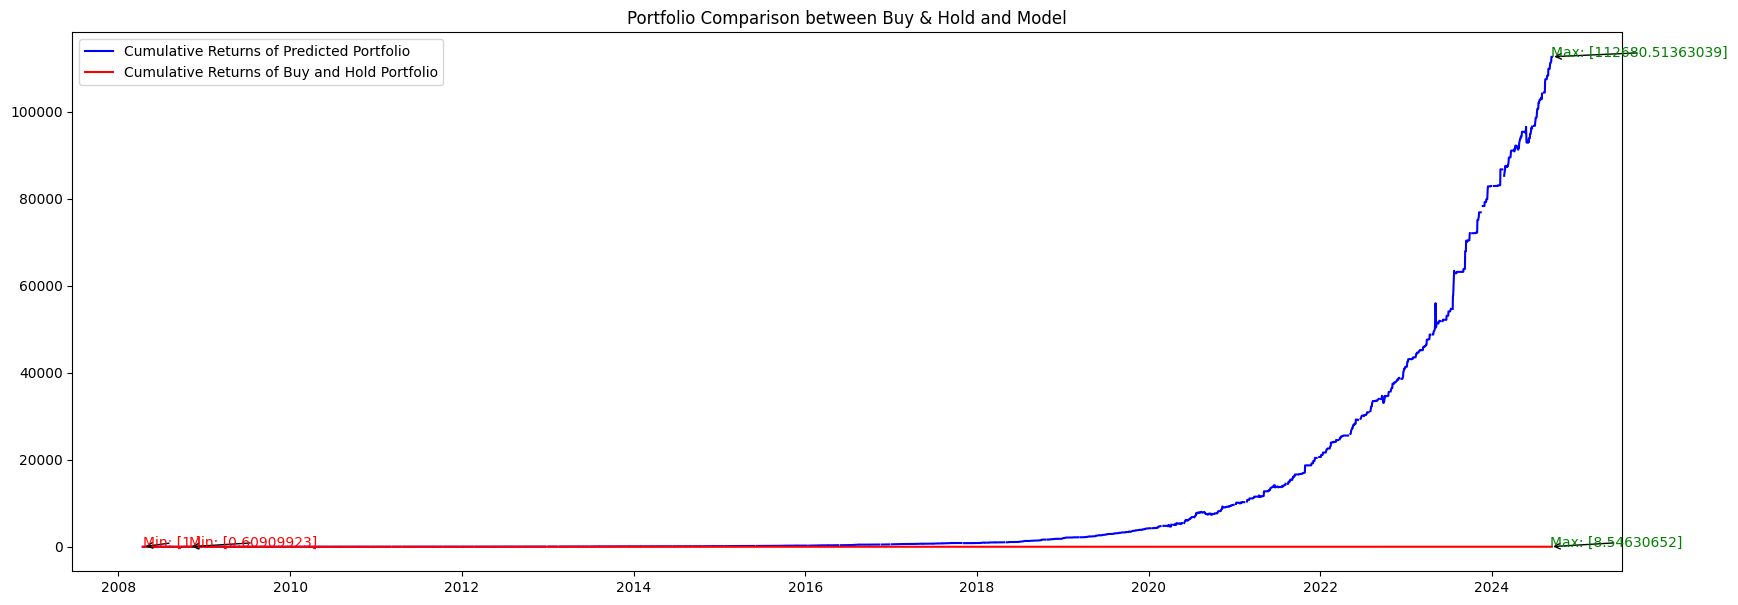

In [121]:
best_results_rnn_1, cuml_perf_rnn_1, max_sharpe_rnn_1 = find_best_experiment(results_rnn_1)

plot_two_returns_series(
    cuml_perf_rnn_1, 
    buy_and_hold1,
    "Cumulative Returns of Predicted Portfolio", 
    "Cumulative Returns of Buy and Hold Portfolio", 
    daily_returns.index
)

# Random Forest

In [122]:
def define_rf(random_seed: int):
    rf = RandomForestClassifier(verbose=False, random_state=random_seed, n_jobs=-1)

    return rf

In [125]:
def run_rf_experiment(train_size: int, val_size: int, stock: str, random_seed: int):
    print(stock)
    np.random.seed(random_seed)
    random.seed(random_seed)
    tf.random.set_seed(random_seed)

    model = define_rf(random_seed)
    cv_splitter = SlidingWindowExclusiveTestCV(train_size, val_size)

    tests = []
    results = {}
    ground_y = []

    start_time = datetime.now()
    for train_index, test_index in cv_splitter.split(stocks_df):
        preprocessed_train_data = preprocess_data(stocks_df.iloc[train_index], stock)
        preprocessed_test_data = preprocess_data(stocks_df.iloc[test_index], stock)
        
        train_features = preprocessed_train_data.drop([f"{stock}_y"], axis=1)
        train_targets = preprocessed_train_data[f"{stock}_y"]

        test_features = preprocessed_test_data.drop([f"{stock}_y"], axis=1)
        test_targets = preprocessed_test_data[f"{stock}_y"]

        # just so I can rename variables
        X_train, X_test = train_features, test_features
        y_train, y_test = train_targets, test_targets

        model.fit(
            X_train, y_train
        )
        y_hat = model.predict(X_test)

        y_hat = np.array(y_hat)

        # append preds and grounds into array
        for i, y_pred in enumerate(y_hat):
            tests.append({y_test.index[i]: y_pred.astype(int)})
        
        for i, y_true in enumerate(y_hat):
            ground_y.append({y_test.index[i]: y_test.iloc[i].astype(int)})
            
    end_time = datetime.now()
    
    # extract values from result data structure
    preds_to_compute = [list(i.values())[0] for i in tests]
    grounds_to_compute = [list(i.values())[0] for i in ground_y]
    
    results = {
        "accuracy": accuracy_score(grounds_to_compute, preds_to_compute),
        "f1": f1_score(grounds_to_compute, preds_to_compute),
        "precision": precision_score(grounds_to_compute, preds_to_compute, zero_division=0),
        "recall": recall_score(grounds_to_compute, preds_to_compute),
        "auc": roc_auc_score(grounds_to_compute, preds_to_compute),
        "dataset_fit_predict_time": (end_time - start_time).total_seconds()
    }

    # all_accs.append(np.array(accs).mean())
    np.random.seed(RANDOM_STATE)
    random.seed(RANDOM_STATE)
    tf.random.set_seed(RANDOM_STATE)

    return results, tests

In [126]:
results_rf_1_path = "./results/rf_01"

if not os.path.isfile(results_rf_1_path):
    results_rf_1 = []

    for i in range(NUM_EXPERIMENTS):
        print(f"EXECUTION NUMBER {i+1}")
        abev3_rf_res, abev3_preds_rf = run_rf_experiment( 
            TRAIN_SIZE, 
            VAL_SIZE, 
            "abev3", 
            i
        )

        bbdc3_rf_res, bbdc3_preds_rf = run_rf_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "bbdc3", 
            i
        )

        itsa3_rf_res, itsa3_preds_rf = run_rf_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itsa3", 
            i
        )

        itub3_rf_res, itub3_preds_rf = run_rf_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itub3", 
            i
        )

        wege3_rf_res, wege3_preds_rf = run_rf_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "wege3", 
            i
        )

        results_rf_1.append({
            "abev3": (abev3_rf_res, abev3_preds_rf),
            "bbdc3": (bbdc3_rf_res, bbdc3_preds_rf),
            "itsa3": (itsa3_rf_res, itsa3_preds_rf),
            "itub3": (itub3_rf_res, itub3_preds_rf),
            "wege3": (wege3_rf_res, wege3_preds_rf)
        })

    !mkdir "./results/"
    with open(results_rf_1_path, "wb") as f:
        pickle.dump(results_rf_1, f)

else:
    with open(results_rf_1_path, "rb") as f:
        results_rf_1 = pickle.load(f)

EXECUTION NUMBER 1
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 2
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 3
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 4
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 5
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 6
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 7
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 8
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 9
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 10
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 11
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 12
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 13
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 14
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 15
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 16
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 17
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 18
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 19
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 20
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION

A subdirectory or file ./results/ already exists.


Selected exp number 5
[0.76877428]
[0.60909923]


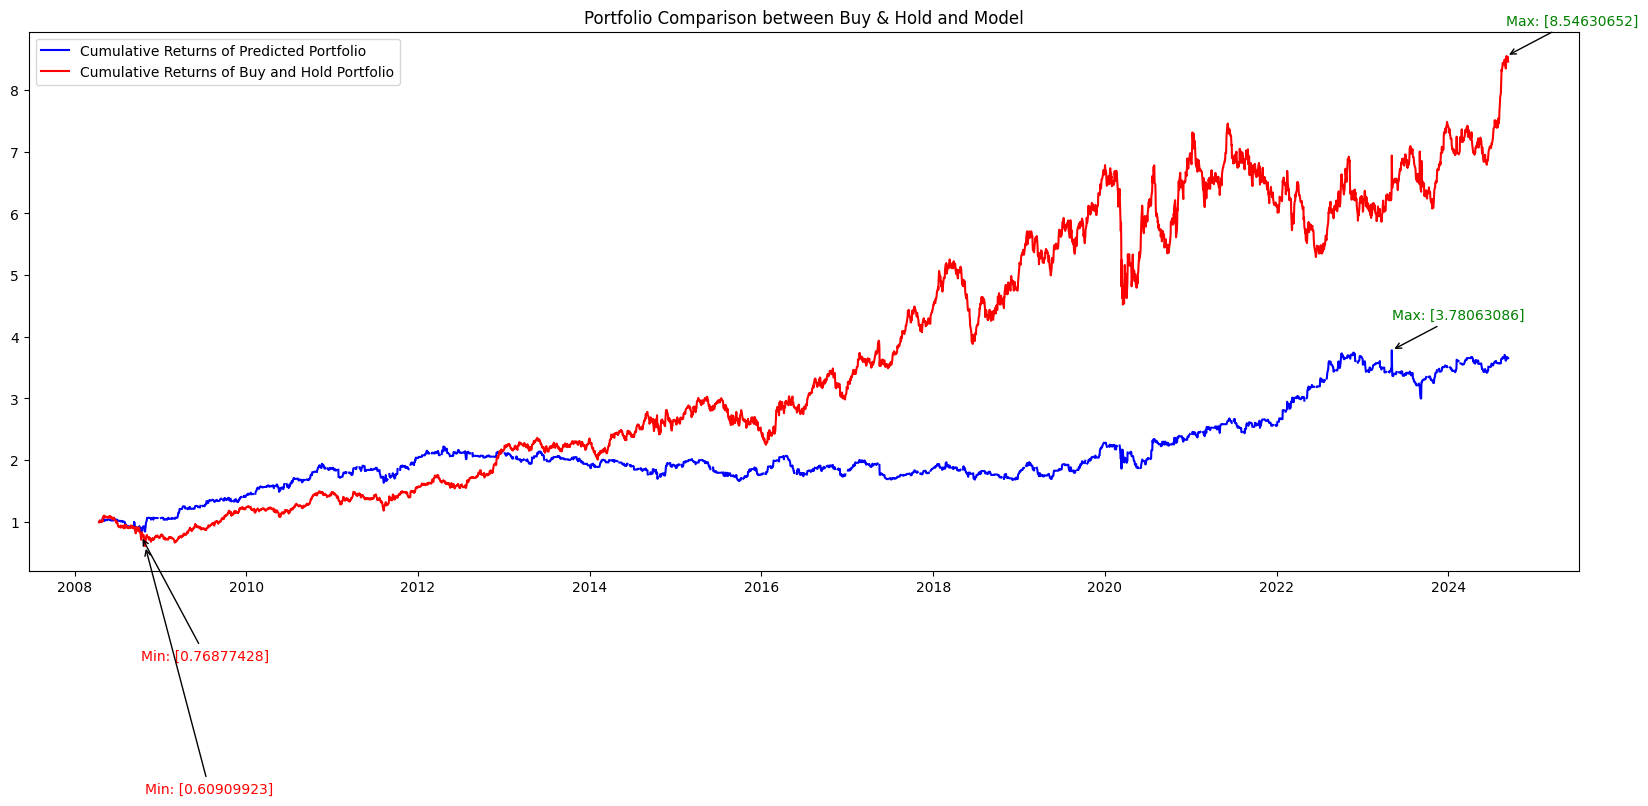

In [127]:
best_results_rf_1, cuml_perf_rf_1, max_sharpe_rf_1 = find_best_experiment(results_rf_1)

plot_two_returns_series(
    cuml_perf_rf_1, 
    buy_and_hold1,
    "Cumulative Returns of Predicted Portfolio", 
    "Cumulative Returns of Buy and Hold Portfolio", 
    daily_returns.index
)

# Random Guessing

TODO: definir random guessing

In [128]:
def run_random_guessing_experiment(train_size: int, val_size: int, stock: str, random_seed: int):
    print(stock)
    np.random.seed(random_seed)
    random.seed(random_seed)
    tf.random.set_seed(random_seed)

    data = preprocess_data(stocks_df, stock)

    X = data.drop([f"{stock}_y"], axis=1)
    y_ground = data[f"{stock}_y"]

    cv_splitter = SlidingWindowExclusiveTestCV(train_size, val_size)

    tests = []
    results = {}
    ground_y = []

    for train_index, test_index in cv_splitter.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_ground.iloc[train_index], y_ground.iloc[test_index]

        # y_hat = model.predict(X_test)
        y_hat = np.random.choice([True, False], size=len(X_test))

        y_hat = np.array(y_hat)

        # append preds and grounds into array
        for i, y_pred in enumerate(y_hat):
            tests.append({y_test.index[i]: y_pred.astype(int)})
        
        for i, y_true in enumerate(y_hat):
            ground_y.append({y_test.index[i]: y_test.iloc[i].astype(int)})
            
    # extract values from result data structure

    preds_to_compute = [list(i.values())[0] for i in tests]
    grounds_to_compute = [list(i.values())[0] for i in ground_y]
    
    results = {
        "accuracy": accuracy_score(grounds_to_compute, preds_to_compute),
        "f1": f1_score(grounds_to_compute, preds_to_compute),
        "precision": precision_score(grounds_to_compute, preds_to_compute, zero_division=0),
        "recall": recall_score(grounds_to_compute, preds_to_compute),
        "auc": roc_auc_score(grounds_to_compute, preds_to_compute)
    }

    # all_accs.append(np.array(accs).mean())
    np.random.seed(RANDOM_STATE)
    random.seed(RANDOM_STATE)
    tf.random.set_seed(RANDOM_STATE)

    return results, tests

In [129]:
results_rg_1_path = "./results/rg_01"

if not os.path.isfile(results_rg_1_path):
    results_rg_1 = []

    for i in range(NUM_EXPERIMENTS):
        print(f"EXECUTION NUMBER {i+1}")
        abev3_rg_res, abev3_preds_rg = run_random_guessing_experiment( 
            TRAIN_SIZE, 
            VAL_SIZE, 
            "abev3", 
            i
        )

        bbdc3_rg_res, bbdc3_preds_rg = run_random_guessing_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "bbdc3", 
            i
        )

        itsa3_rg_res, itsa3_preds_rg = run_random_guessing_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itsa3", 
            i
        )

        itub3_rg_res, itub3_preds_rg = run_random_guessing_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itub3", 
            i
        )

        wege3_rg_res, wege3_preds_rg = run_random_guessing_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "wege3", 
            i
        )

        results_rg_1.append({
            "abev3": (abev3_rg_res, abev3_preds_rg),
            "bbdc3": (bbdc3_rg_res, bbdc3_preds_rg),
            "itsa3": (itsa3_rg_res, itsa3_preds_rg),
            "itub3": (itub3_rg_res, itub3_preds_rg),
            "wege3": (wege3_rg_res, wege3_preds_rg)
        })

    !mkdir "./results/"
    with open(results_rg_1_path, "wb") as f:
        pickle.dump(results_rg_1, f)

else:
    with open(results_rg_1_path, "rb") as f:
        results_rg_1 = pickle.load(f)

EXECUTION NUMBER 1
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 2
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 3
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 4
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 5
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 6
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 7
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 8
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 9
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 10
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 11
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 12
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 13
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 14
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 15
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 16
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 17
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 18
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 19
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION NUMBER 20
abev3
bbdc3
itsa3
itub3
wege3
EXECUTION

A subdirectory or file ./results/ already exists.


Selected exp number 28
[0.95185937]
[0.60909923]


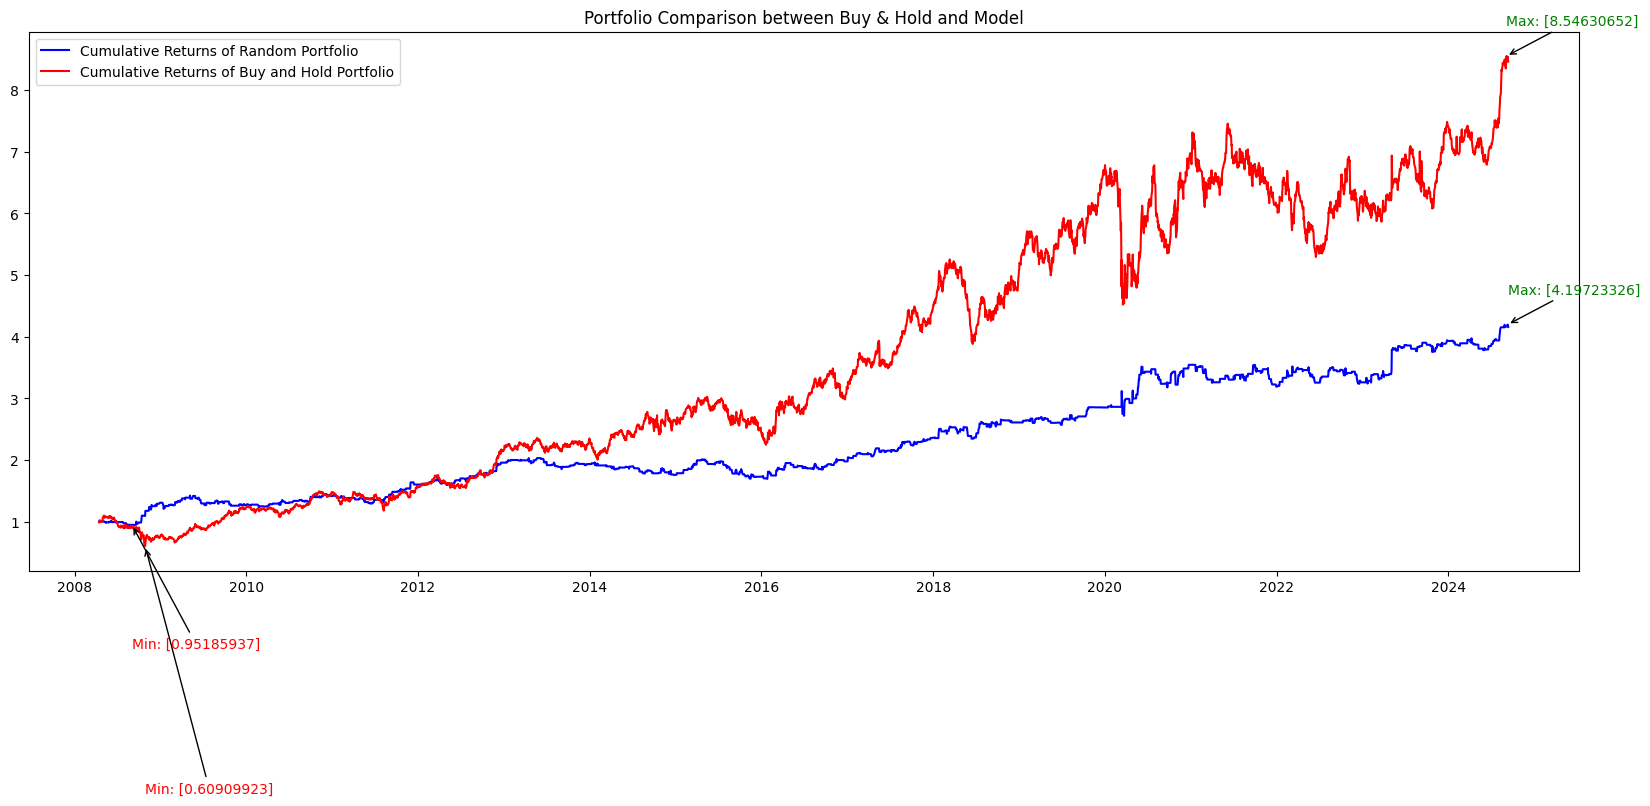

In [130]:
best_results_rg_1, cuml_perf_rg_1, max_sharpe_rg_1 = find_best_experiment(results_rg_1)

plot_two_returns_series(
    cuml_perf_rg_1, 
    buy_and_hold1,
    "Cumulative Returns of Random Portfolio", 
    "Cumulative Returns of Buy and Hold Portfolio", 
    daily_returns.index
)

# Análise dos Resultados

In [131]:
def get_sharpe_series_from_results(experiments):
    sharpes = []

    for experiment in experiments:
        _, exp_portfolio_returns = compute_cumulative_returns_pred(
            experiment["abev3"][1],
            experiment["bbdc3"][1],
            experiment["itsa3"][1],
            experiment["itub3"][1],
            experiment["wege3"][1]
        )

        sharpe = compute_sharpe_ratio(exp_portfolio_returns)
        sharpes.append(sharpe)
        
    
    return sharpes

In [132]:
lstm_sharpes_1 = get_sharpe_series_from_results(results_lstm_1)
gru_sharpes_1 = get_sharpe_series_from_results(results_gru_1)
rf_sharpes_1 = get_sharpe_series_from_results(results_rf_1)
rnn_sharpes_1 = get_sharpe_series_from_results(results_rnn_1)
rg_sharpes_1 = get_sharpe_series_from_results(results_rg_1)

In [133]:
def plot_distribution_and_stddev(all_data, metric, models = ["LSTM", "GRU", "RNN", "RF", "RG"]):

    fig, axes = plt.subplots(1, 2, figsize=(40, 15))

    labels = [f"{models[i]}" for i in range(len(all_data))]

    axes[0].boxplot(
        all_data, 
        labels=labels
    )
    axes[0].set_title(f'Boxplot of {metric}')

    bars = axes[1].bar(
        labels,
        [
            np.array(model).std() for model in all_data
        ], 
        color='skyblue'
    )
    for bar in bars:
        height = bar.get_height()
        axes[1].text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:.4f}',
            ha='center', va='bottom'
        )
    axes[1].set_title(f'Standard Deviations of {metric}')

    plt.tight_layout()
    plt.show()

In [134]:
def print_statistics_table_for_series(all_data, models = ["LSTM", "GRU", "RNN", "RF", "RG"]):
    table = PrettyTable(["model", "mean", "median", "max", "min", "stddev", "full range"])

    for series, model in zip(all_data, models):
        table.add_row([
            model,
            np.array(series).mean(),
            np.median(np.array(series)),
            np.array(series).max(),
            np.array(series).min(),
            np.array(series).std(),
            np.array(series).max() - np.array(series).min()
        ])
    
    print(table)

### Distribuição de Sharpe Ratios

C:\Users\luisc\AppData\Local\Temp\ipykernel_49416\3368430161.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(


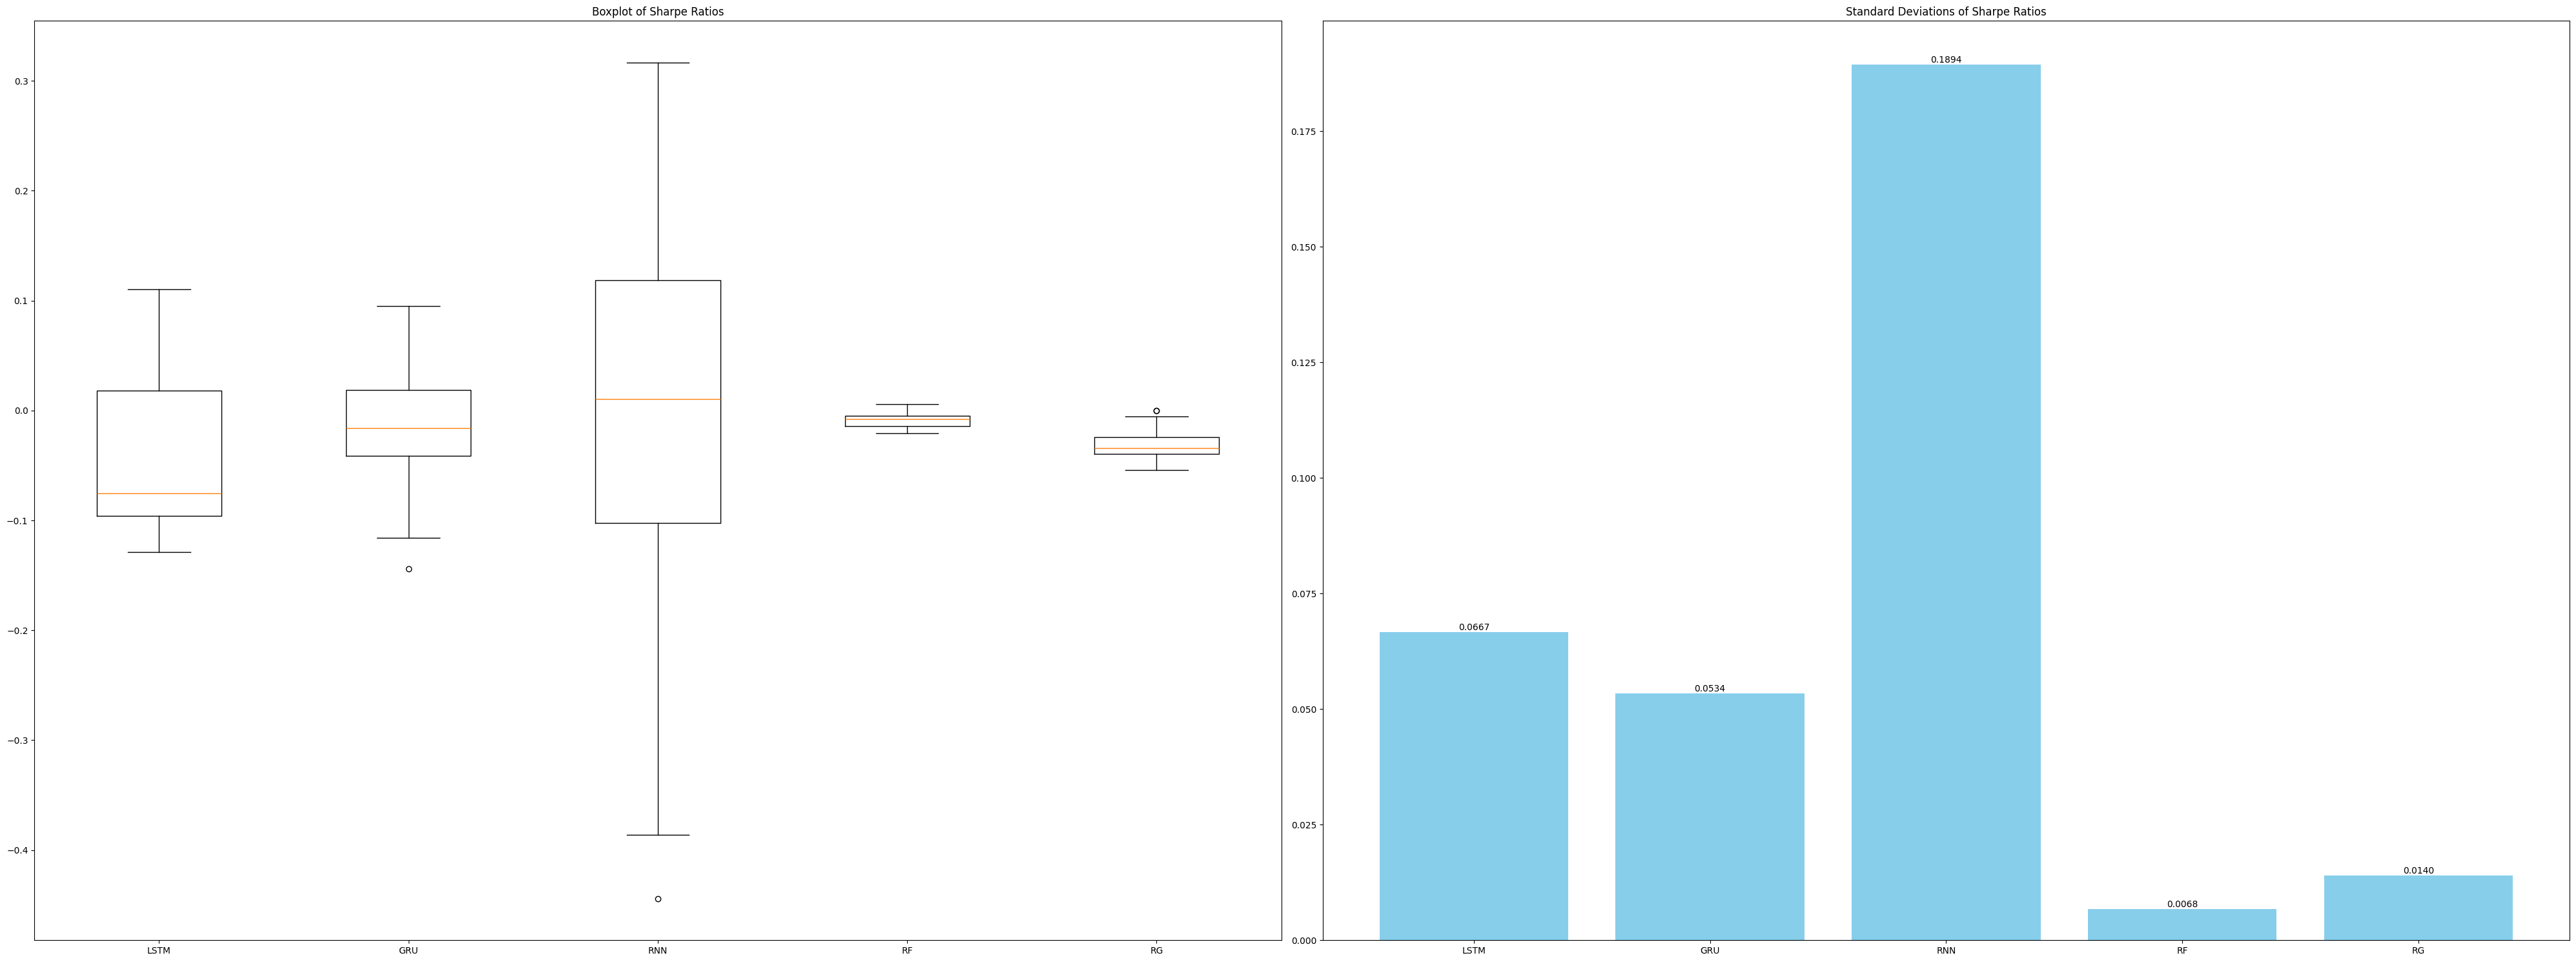

In [135]:
plot_distribution_and_stddev([           
    lstm_sharpes_1,
    gru_sharpes_1,
    rnn_sharpes_1,
    rf_sharpes_1,
    rg_sharpes_1
],
"Sharpe Ratios"
)

In [136]:
print_statistics_table_for_series([
    lstm_sharpes_1,
    gru_sharpes_1,
    rnn_sharpes_1,
    rf_sharpes_1,
    rg_sharpes_1
])

+-------+-----------------------+-----------------------+-------------------------+-----------------------+----------------------+----------------------+
| model |          mean         |         median        |           max           |          min          |        stddev        |      full range      |
+-------+-----------------------+-----------------------+-------------------------+-----------------------+----------------------+----------------------+
|  LSTM |  -0.04480780893197118 |  -0.07540024642901955 |   0.11022945621521726   |  -0.12850228707472136 | 0.06667376128662075  | 0.23873174328993862  |
|  GRU  |  -0.01855541107607259 | -0.016147594889215647 |   0.09523692350595893   |  -0.14412044654119785 | 0.05339968330787894  |  0.2393573700471568  |
|  RNN  | -0.015517665512663164 |  0.010629069174025651 |   0.31650609125571694   |  -0.44396073739812797 | 0.18942776101452605  |  0.760466828653845   |
|   RF  | -0.008742830606606978 | -0.008007975848525814 |   0.00590072726827

In [137]:
buy_and_hold_sharpe

np.float64(0.017230075011876338)

Inicialmente, destaca-se o fato de todas as medianas serem negativas, ou seja, pelo menos 50% dos dados estão negativos. Isso já é um indicativo de que os modelos, pelo menos metade das vezes, fazem com que o capital investido seja diminuido com o tempo, um indicativo de que eles na maioria das vezes não conseguem aprender os padrões nos dados para prover resultados positivos. Apesar disso, analisando o range de sharpe ratios, é evidente que a RNN simples tem uma incerteza bem maior, dado o desvio padrão mais que o dobro do segundo maior desvio padrão da RNN. Observa-se também, através do boxplot, que a RNN simples apresenta vários outliers que se estendem além de todos os outros resultados. O próximo maior desvio padrão é da LSTM, que tem uma complexidade maior que a RNN simples, e pode ter sido melhor capaz de aprender as dependências de longo prazo nos dados. Em seguida, a GRU, que estaria entre a LSTM e a RNN simples em complexidade, tem um desvio padrão menor que os outros dois modelos, mas sem alcançar resultados tão altos na máxima quanto a RNN simples e a LSTM. Por fim, o Random Forest apresenta o menor desvio padrão, indicando uma certeza mais contida apesar da aleatoriedade, com o detrimento de não alcançar resultados máximos tão positivos quanto os outros modelos.

[0.9641627]
[1.]


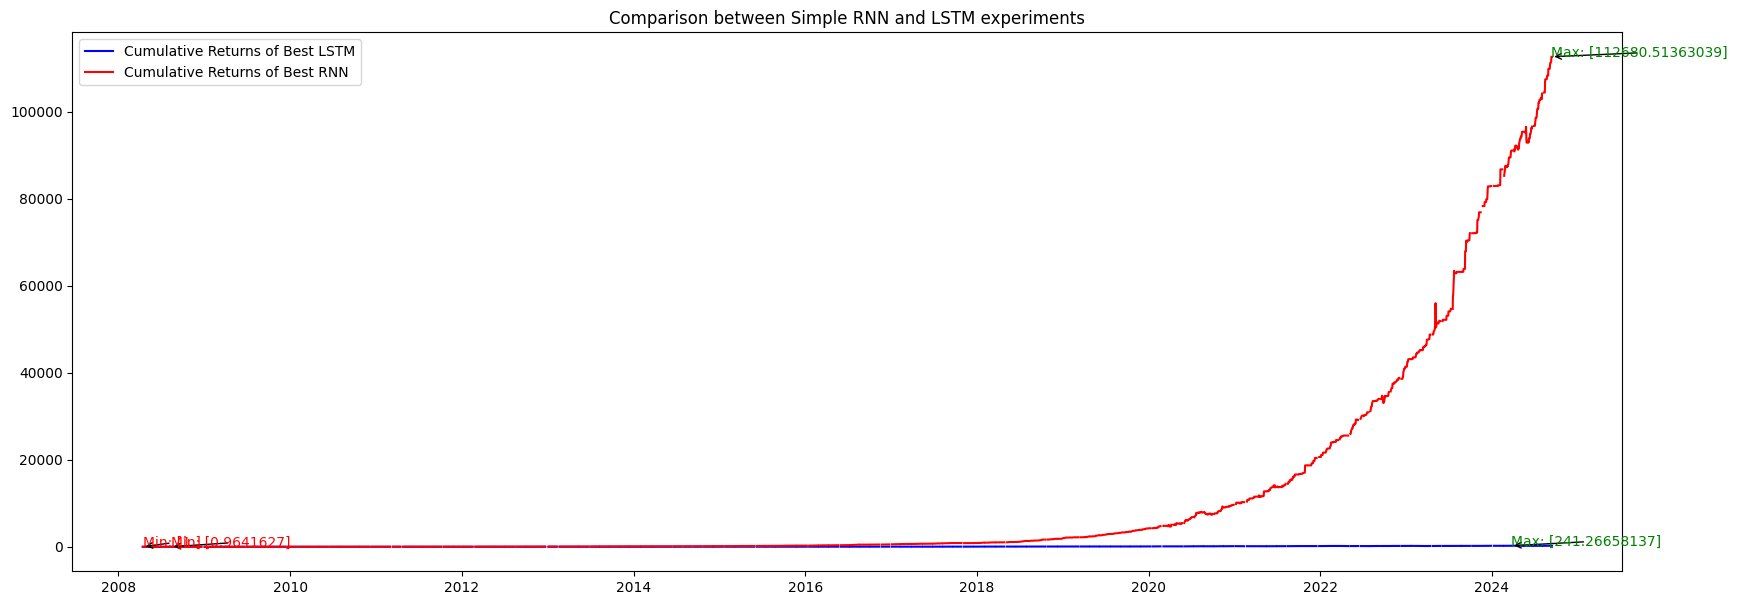

In [138]:
plot_two_returns_series(
    cuml_perf_lstm_01, 
    cuml_perf_rnn_1,
    "Cumulative Returns of Best LSTM", 
    "Cumulative Returns of Best RNN", 
    daily_returns.index,
    "Comparison between Simple RNN and LSTM experiments"
)

[0.76877428]
[1.]


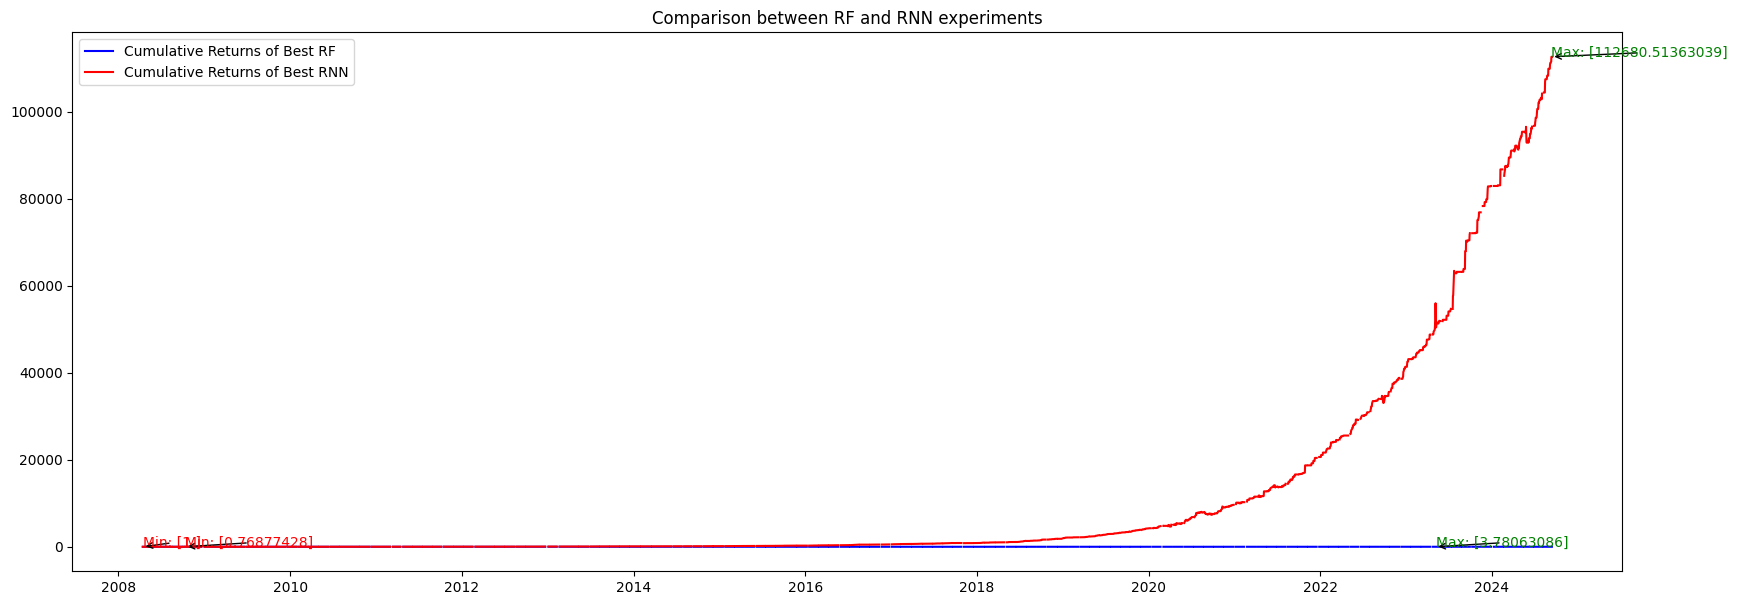

In [139]:
plot_two_returns_series(
    cuml_perf_rf_1,
    cuml_perf_rnn_1,
    "Cumulative Returns of Best RF", 
    "Cumulative Returns of Best RNN", 
    daily_returns.index,
    "Comparison between RF and RNN experiments"
)

O melhor experimento da RNN, o maior outlier, multiplica o valor investido em 6149x, enquanto o melhor Random Forest multiplica o valor investido em apenas 5x, menos ainda do que o Buy and Hold, de aproximadamente 8x

### Distribuição das acurácias

In [140]:
def get_metric_distribution_from_results(results, metric):
    metric_series = []
    for result in results:
        metric_sum = result["abev3"][0][metric] + result["bbdc3"][0][metric] + result["itub3"][0][metric] + result["itsa3"][0][metric] + result["wege3"][0][metric]
        metric_series.append(metric_sum / 5)

    return metric_series

In [141]:
lstm_accs_1 = get_metric_distribution_from_results(results_lstm_1, "accuracy")
gru_accs_1 = get_metric_distribution_from_results(results_gru_1, "accuracy")
rnn_accs_1 = get_metric_distribution_from_results(results_rnn_1, "accuracy")
rf_accs_1 = get_metric_distribution_from_results(results_rf_1, "accuracy")
rg_accs_1 = get_metric_distribution_from_results(results_rg_1, "accuracy")

C:\Users\luisc\AppData\Local\Temp\ipykernel_49416\3368430161.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(


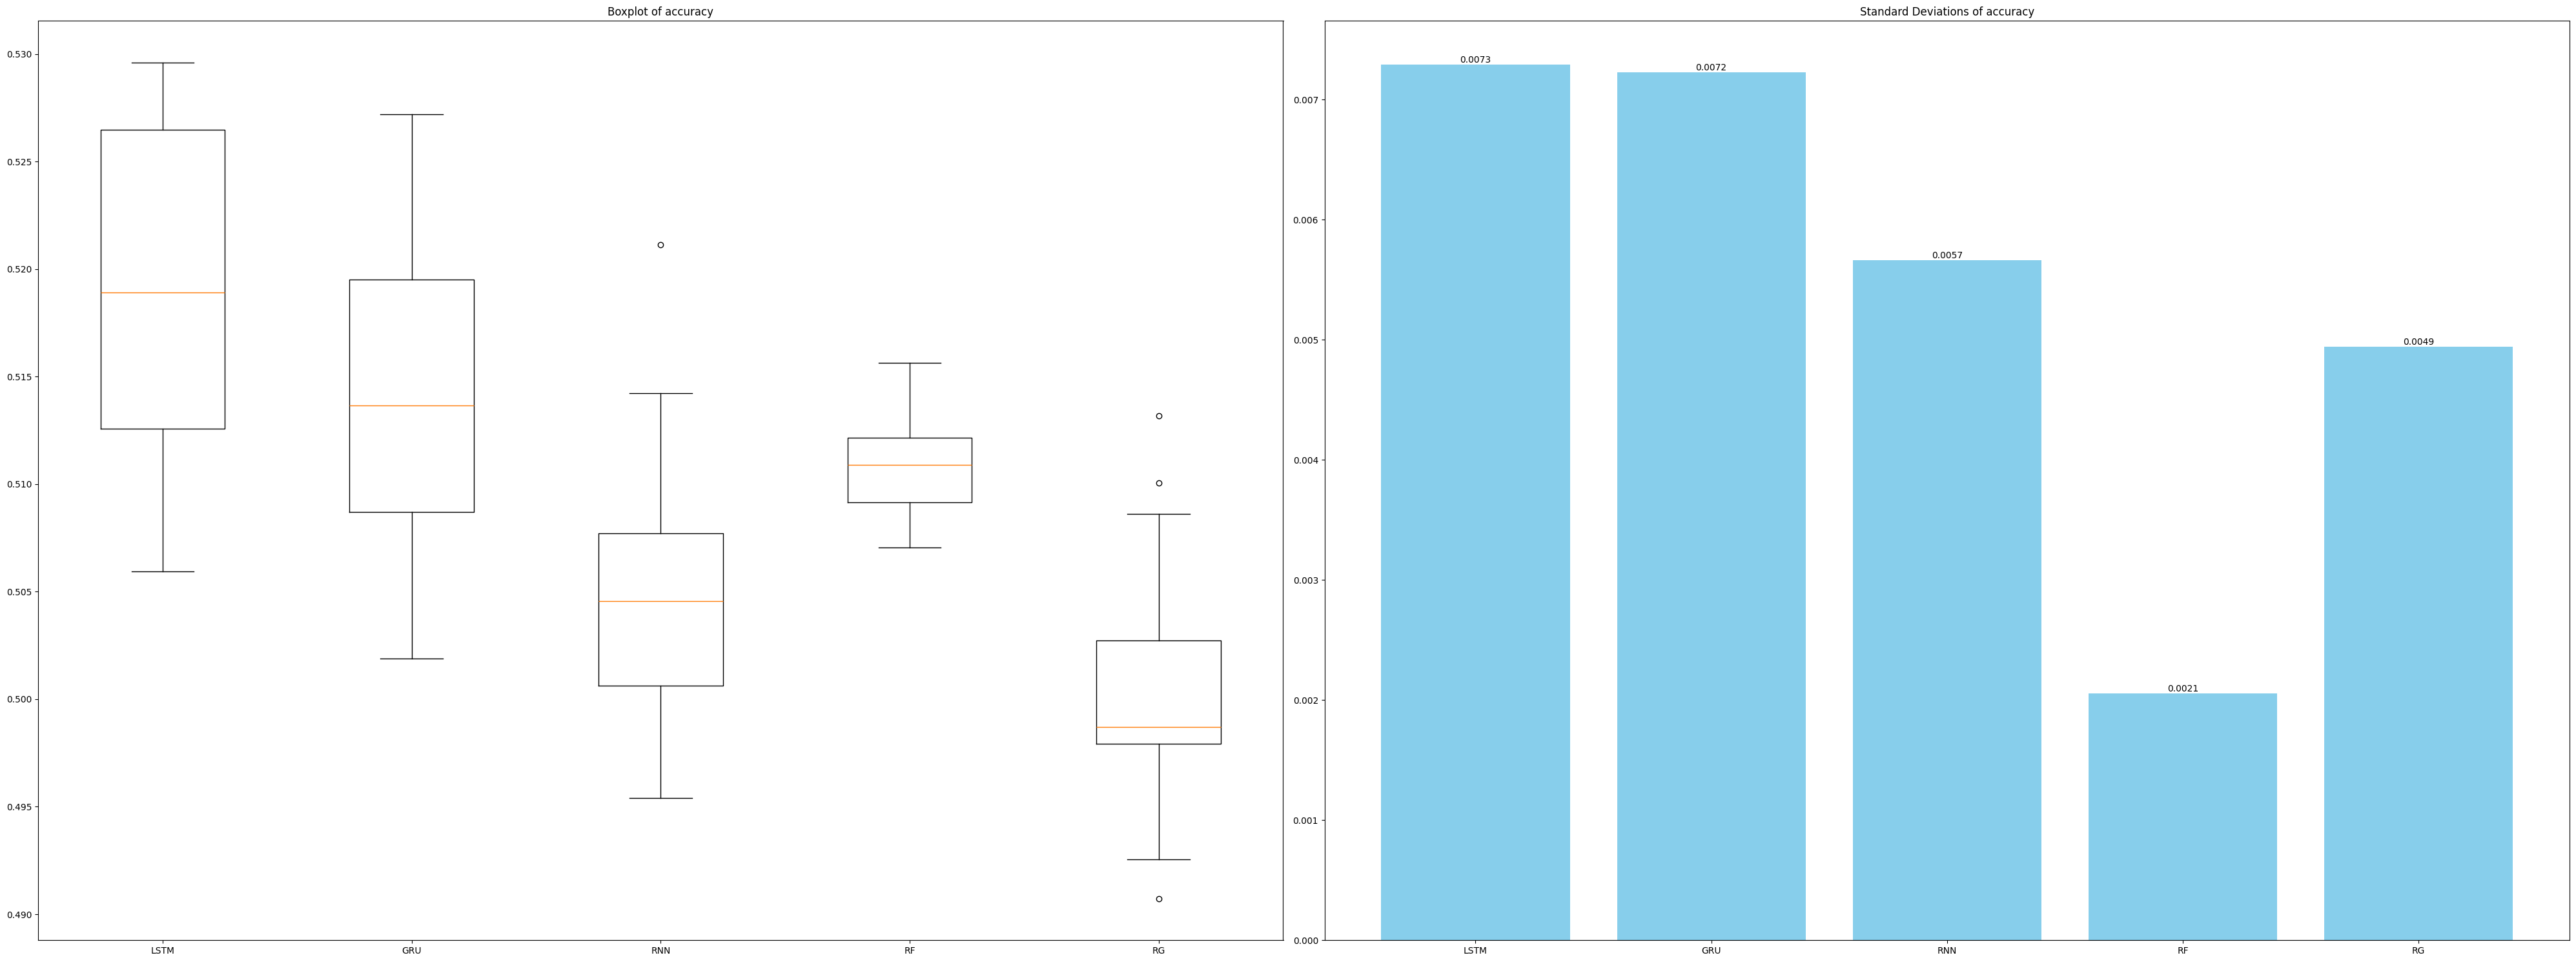

In [142]:
plot_distribution_and_stddev([
    lstm_accs_1,
    gru_accs_1,
    rnn_accs_1,
    rf_accs_1,
    rg_accs_1
], "accuracy")

In [143]:
print_statistics_table_for_series([
    lstm_accs_1,
    gru_accs_1,
    rnn_accs_1,
    rf_accs_1,
    rg_accs_1
])

+-------+--------------------+---------------------+--------------------+---------------------+-----------------------+----------------------+
| model |        mean        |        median       |        max         |         min         |         stddev        |      full range      |
+-------+--------------------+---------------------+--------------------+---------------------+-----------------------+----------------------+
|  LSTM | 0.5193126475781601 |  0.5189168195824534 | 0.5295939133746494 |  0.5059439462659696 | 0.0072917378851763155 | 0.023649967108679837 |
|  GRU  | 0.5135000496255006 |  0.513651161582938  | 0.5271821486687671 |  0.5018844649101547 |  0.007226810035246179 | 0.02529768375861241  |
|  RNN  | 0.5047331440639823 |  0.5045605892739675 | 0.5211229789149325 | 0.49541152234878644 |  0.005663275621381338 | 0.025711456566146096 |
|   RF  | 0.5108930662788953 |  0.5108848457570198 | 0.5156501748433334 |  0.5070612471003704 |  0.00205677870583299  | 0.008588927742963048 |

Em média, as acurácias revolvem ao redor de 50%, não melhor nem pior do que adivinhação aleatória, e com um range não muito alto, nunca passando da máxima dos 53% de acurácia. Novamente, o Random Forest apresenta o menor desvio padrão, apresentando mais consistência frente a aleatoriedade. Aqui, diferente dos sharpe ratios, o maior desvio padrão é da LSTM, mostrando que essa arquitetura tem uma variação maior na corretude, e apesar disso, tem uma máxima e uma mínima menores do que na RNN simples, que atinge o maior valor de acurácia

### Distribuição dos F1 Scores

In [144]:
lstm_f1_1 = get_metric_distribution_from_results(results_lstm_1, "f1")
gru_f1_1 = get_metric_distribution_from_results(results_gru_1, "f1")
rnn_f1_1 = get_metric_distribution_from_results(results_rnn_1, "f1")
rf_f1_1 = get_metric_distribution_from_results(results_rf_1, "f1")
rg_f1_1 = get_metric_distribution_from_results(results_rg_1, "f1")

C:\Users\luisc\AppData\Local\Temp\ipykernel_49416\3368430161.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(


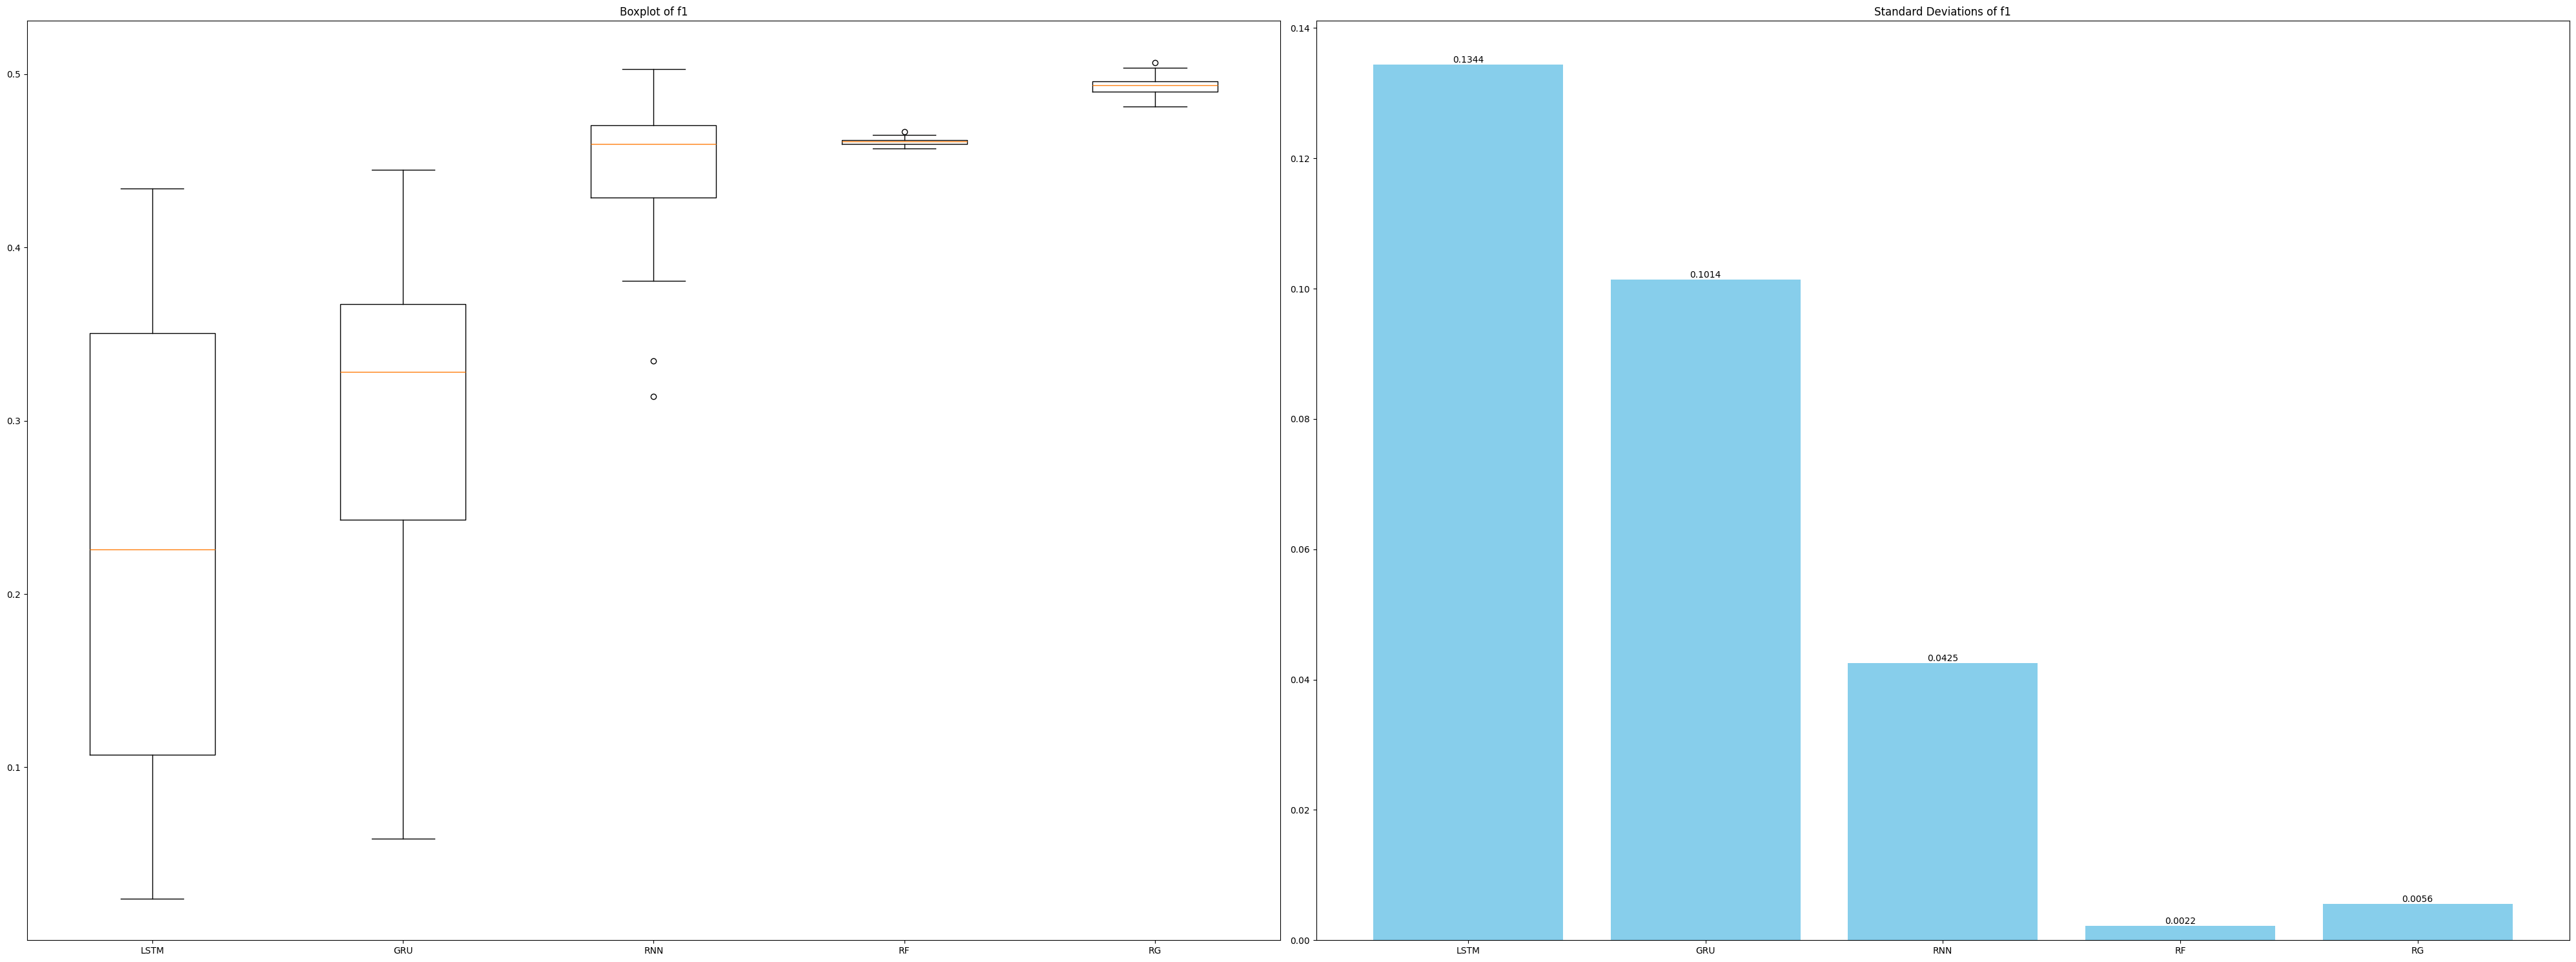

In [145]:
plot_distribution_and_stddev([
    lstm_f1_1,
    gru_f1_1,
    rnn_f1_1,
    rf_f1_1,
    rg_f1_1
], "f1")

In [146]:
print_statistics_table_for_series([
    lstm_f1_1,
    gru_f1_1,
    rnn_f1_1,
    rf_f1_1,
    rg_f1_1
])

+-------+--------------------+---------------------+--------------------+---------------------+-----------------------+----------------------+
| model |        mean        |        median       |        max         |         min         |         stddev        |      full range      |
+-------+--------------------+---------------------+--------------------+---------------------+-----------------------+----------------------+
|  LSTM | 0.2304752964165771 | 0.22577887667232366 | 0.4340619604122001 | 0.02430719937226182 |   0.1343690317312852  | 0.40975476103993824  |
|  GRU  | 0.3052929725258136 |  0.3282448723746073 | 0.4447161335106401 | 0.05880362946567832 |  0.10143530564550098  |  0.3859125040449618  |
|  RNN  | 0.4429920557806029 | 0.45963965977304044 | 0.5028085915924686 | 0.31419656459008916 |  0.042491975885535764 | 0.18861202700237945  |
|   RF  | 0.4609963748321544 | 0.46128374414203976 | 0.4668992539358989 | 0.45713307249945173 | 0.0022305020528309246 | 0.009766181436447141 |

In [147]:
lstm_auc_1 = get_metric_distribution_from_results(results_lstm_1, "auc")
gru_auc_1 = get_metric_distribution_from_results(results_gru_1, "auc")
rnn_auc_1 = get_metric_distribution_from_results(results_rnn_1, "auc")
rf_auc_1 = get_metric_distribution_from_results(results_rf_1, "auc")
rg_auc_1 = get_metric_distribution_from_results(results_rg_1, "auc")

### Distribuição da ROC AUC

C:\Users\luisc\AppData\Local\Temp\ipykernel_49416\3368430161.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(


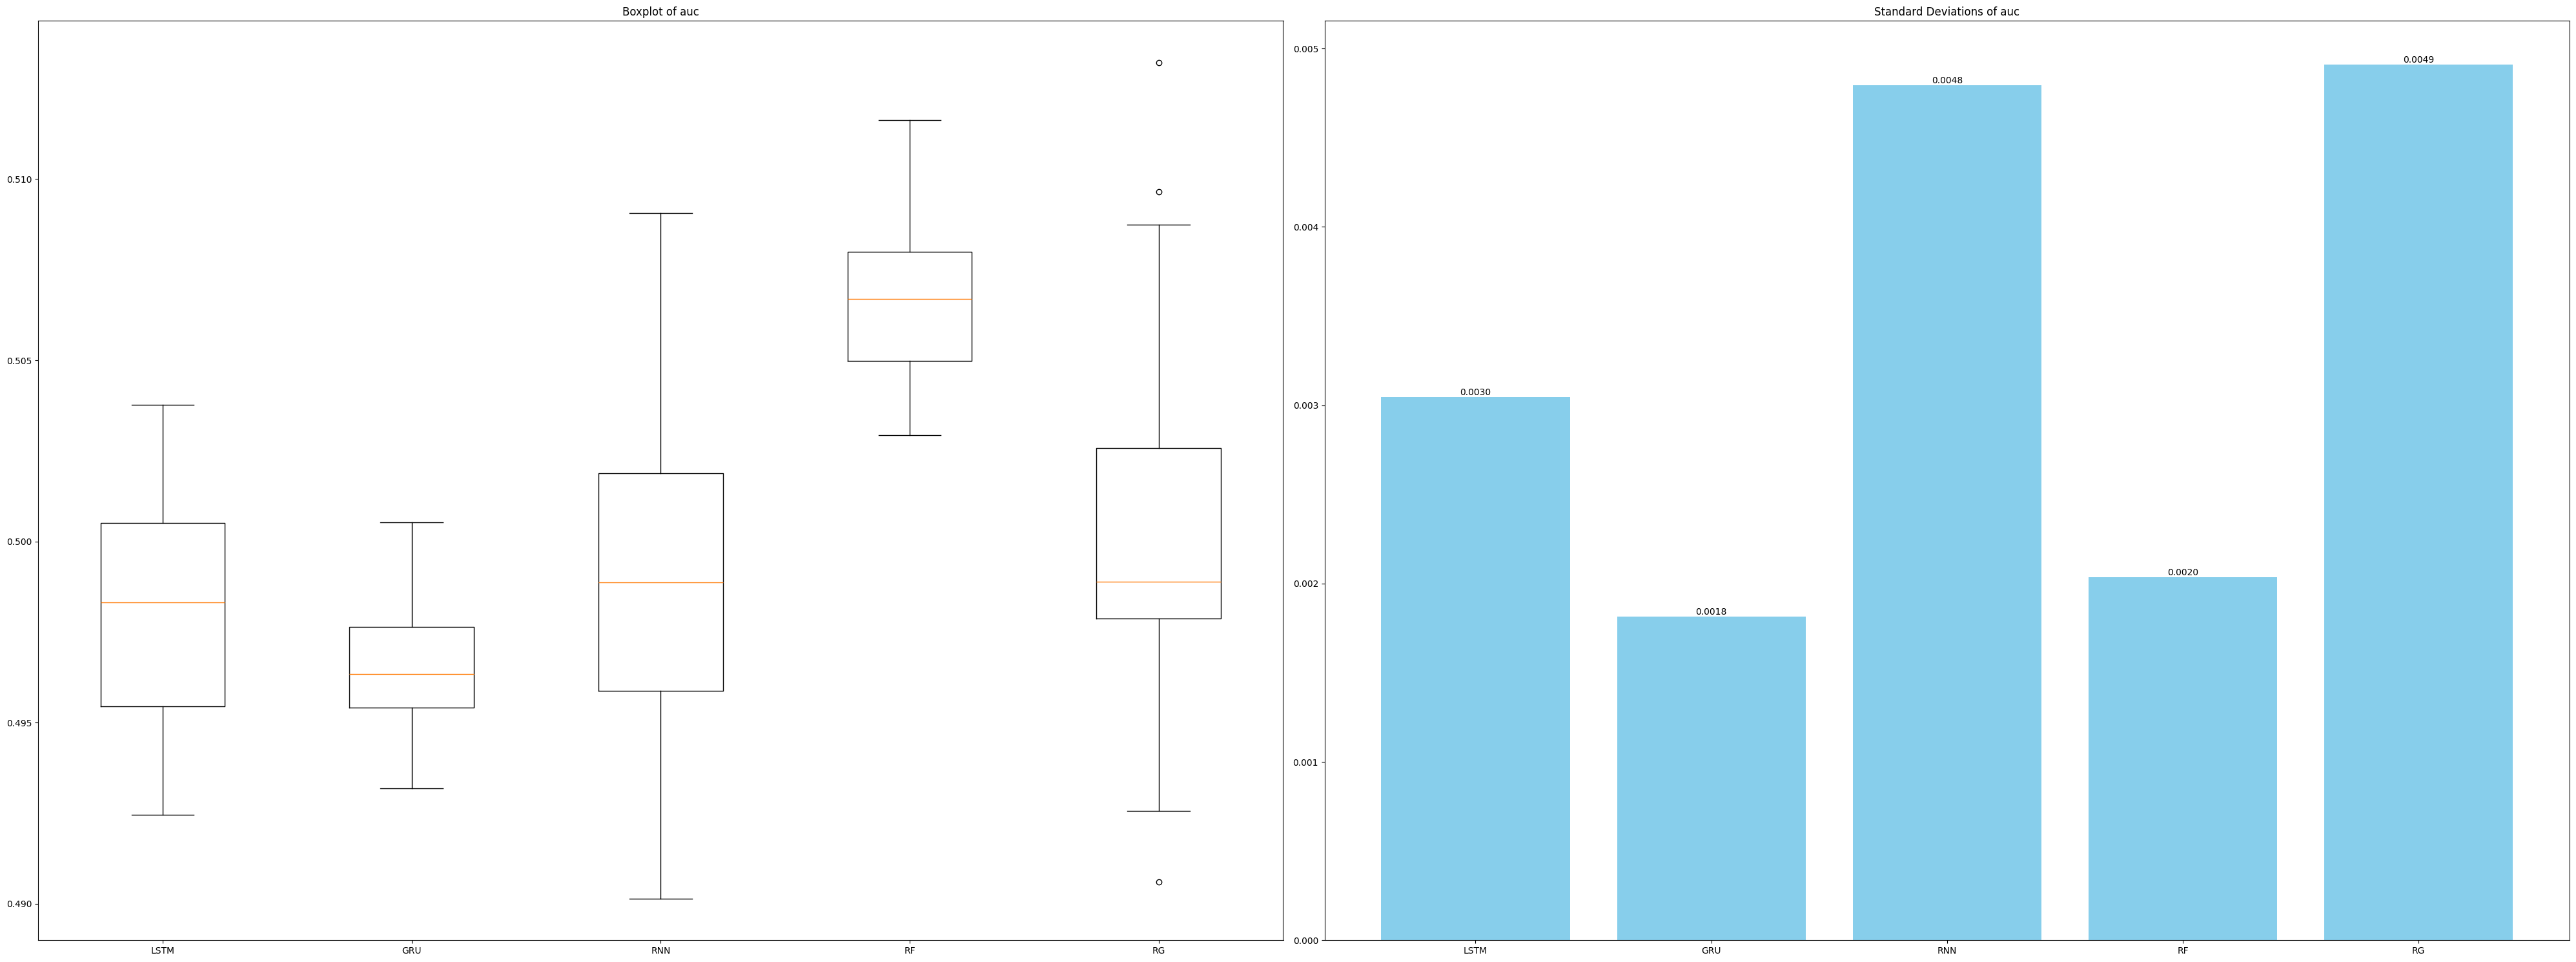

In [148]:
plot_distribution_and_stddev([
    lstm_auc_1,
    gru_auc_1,
    rnn_auc_1,
    rf_auc_1,
    rg_auc_1
], "auc")

In [149]:
print_statistics_table_for_series([
    lstm_auc_1,
    gru_auc_1,
    rnn_auc_1,
    rf_auc_1,
    rg_auc_1
])

+-------+---------------------+--------------------+--------------------+---------------------+-----------------------+----------------------+
| model |         mean        |       median       |        max         |         min         |         stddev        |      full range      |
+-------+---------------------+--------------------+--------------------+---------------------+-----------------------+----------------------+
|  LSTM |  0.498050176208374  | 0.4983210145733189 | 0.5037663970932673 | 0.49245468093120576 |  0.003043883642701798 | 0.011311716162061558 |
|  GRU  | 0.49658801263219826 | 0.4963331810305932 | 0.5005288643162584 |  0.4931783253654144 |  0.001814728911118302 | 0.007350538950844032 |
|  RNN  | 0.49960981068476806 | 0.4988652651845241 | 0.5090711496949588 |  0.4901460513795433 |  0.00479262739912644  |  0.0189250983154155  |
|   RF  |  0.5067263940146883 | 0.5067026221853725 | 0.5116239901147079 |  0.5029297448362484 | 0.0020338330865032742 | 0.008694245278459523 |

As medianas dos F1 scores estão localizadas todas abaixo de 0.5, a uma distância da acurácia. Isso pode ser indicativo de um tradeoff significativo entre precisao e recall em pelo menos metade dos casos. Em alguns casos, como na LSTM, o F1 score chega tão baixo quanto 0.05. A Random Forest, mais uma vez, se mantém consistente com o menor desvio padrão, e a RNN Simples apresenta novamente vários outliers, mas não supera a máxima da LSTM nem da GRU

### Análise de tempo de treinamento

In [150]:
lstm_time_1 = get_metric_distribution_from_results(results_lstm_1, "dataset_fit_predict_time")
gru_time_1 = get_metric_distribution_from_results(results_gru_1, "dataset_fit_predict_time")
rnn_time_1 = get_metric_distribution_from_results(results_rnn_1, "dataset_fit_predict_time")
rf_time_1 = get_metric_distribution_from_results(results_rf_1, "dataset_fit_predict_time")

C:\Users\luisc\AppData\Local\Temp\ipykernel_49416\3368430161.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(


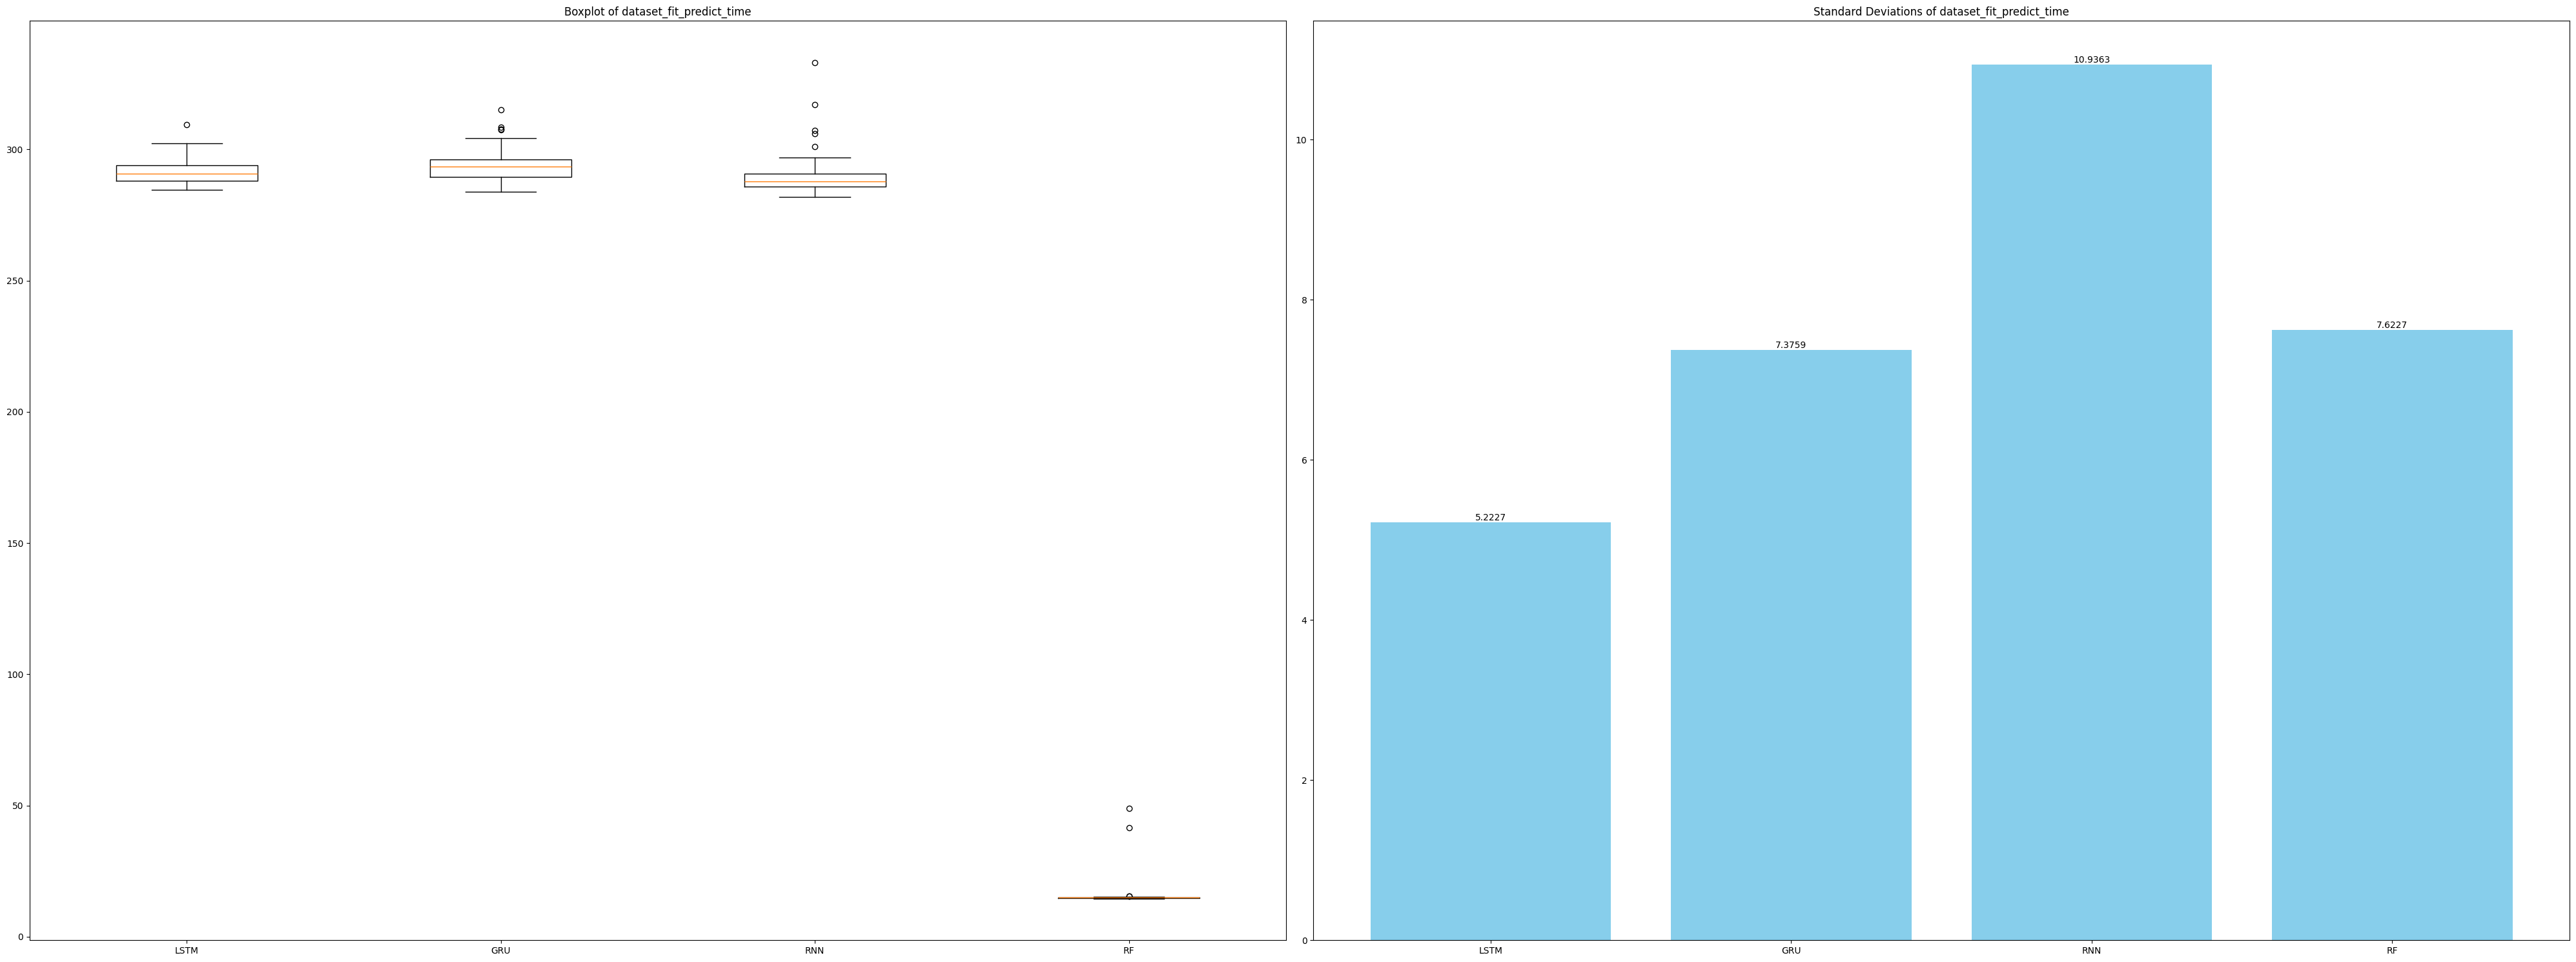

In [151]:
plot_distribution_and_stddev([
    lstm_time_1,
    gru_time_1,
    rnn_time_1,
    rf_time_1
], "dataset_fit_predict_time")

### Correlação entre Sharpes e acurácias; Sharpes e F1; Acc e F1

In [152]:
sharpes_accs_pairs = [
    (lstm_sharpes_1, lstm_accs_1),
    (gru_sharpes_1, gru_accs_1),
    (rnn_sharpes_1, rnn_accs_1),
    (rf_sharpes_1, rf_accs_1)
]

sharpes_f1s_pairs = [
    (lstm_sharpes_1, lstm_f1_1),
    (gru_sharpes_1, gru_f1_1),
    (rnn_sharpes_1, rnn_f1_1),
    (rf_sharpes_1, rf_f1_1)
]

accs_f1s_pairs = [
    (lstm_accs_1, lstm_f1_1),
    (gru_accs_1, gru_f1_1),
    (rnn_accs_1, rnn_f1_1),
    (rf_accs_1, rf_f1_1)
]

model_list = ["lstm 1", "gru 1", "rnn 1", "rf 1"]

TODO: para analise de correlação abaixo, incluir heatmap

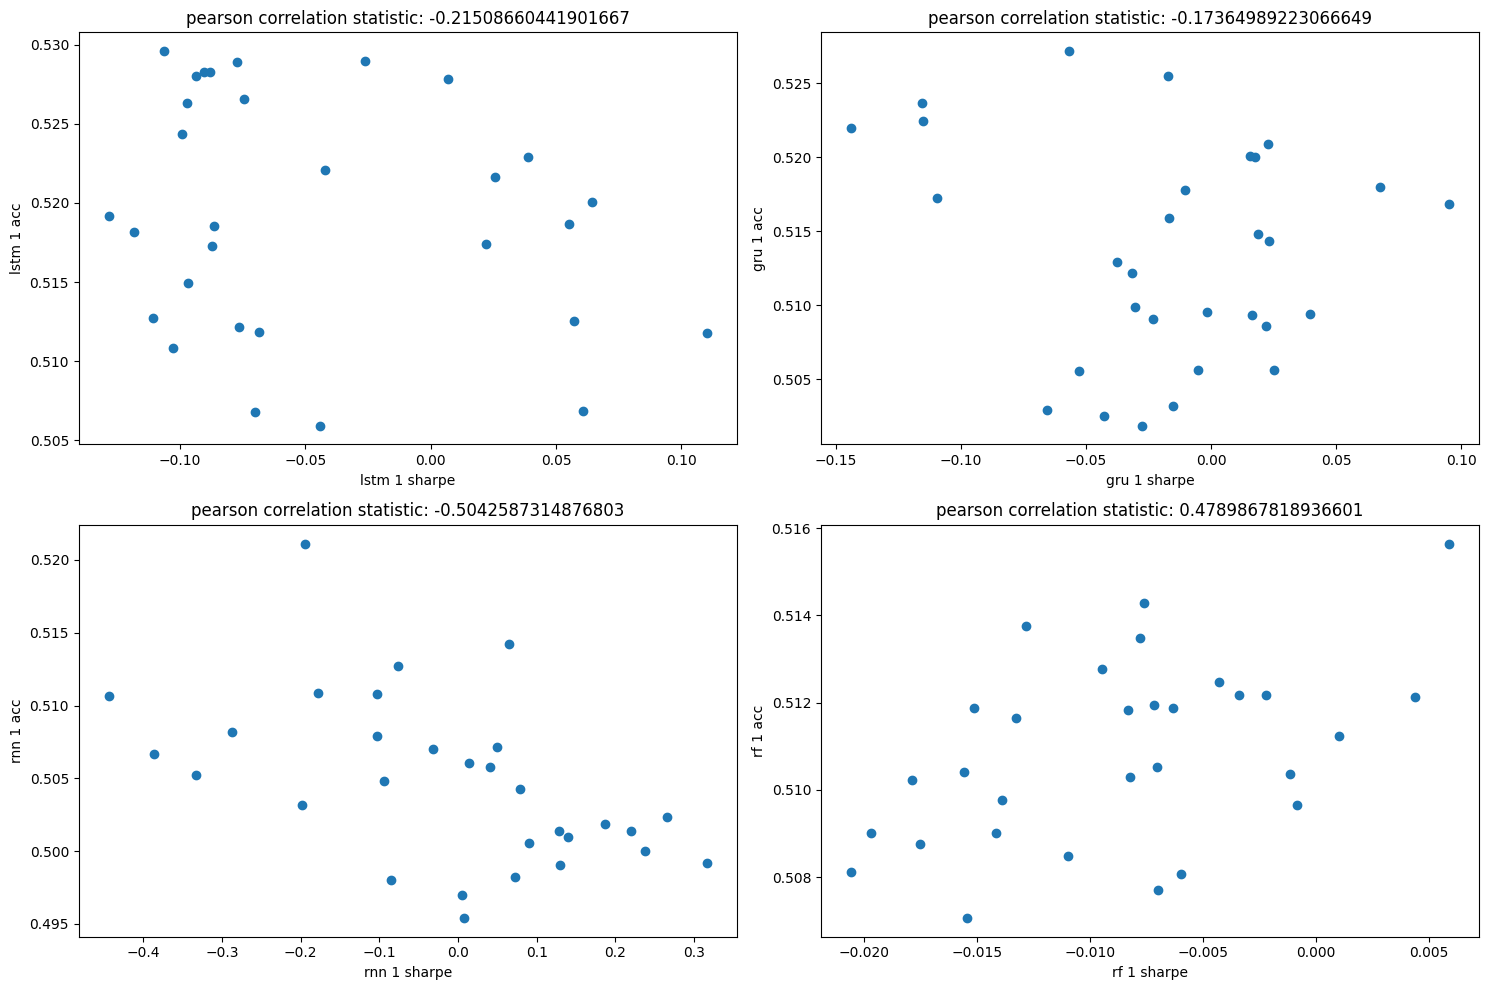

In [153]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes = axes.flatten()

for i, ax in enumerate(axes):
    x, y = sharpes_accs_pairs[i]
    ax.scatter(x, y)
    ax.set_title(f"pearson correlation statistic: {pearsonr(x, y).statistic}")
    ax.set_xlabel(f"{model_list[i]} sharpe")
    ax.set_ylabel(f"{model_list[i]} acc")

plt.tight_layout()
plt.show()

Aqui é evidente que não há muita correlação entre o sharpe e as acurácias nos modelos. A maior correlação é de 0.55 no caso da GRU, mas no geral, não se pode afirmar que uma acurácia maior de classificação leva a um sharpe ratio maior também. Pode-se teorizar que pra esse tipo de problema, com essa base de dados e esses modelos, a melhor performance por vias de sharpe ratio não é atingida por um modelo com métricas mais satisfatórias, e a boa performance pode ser puramente pelo acaso, ou acertar as classificações certas nas instâncias certas.

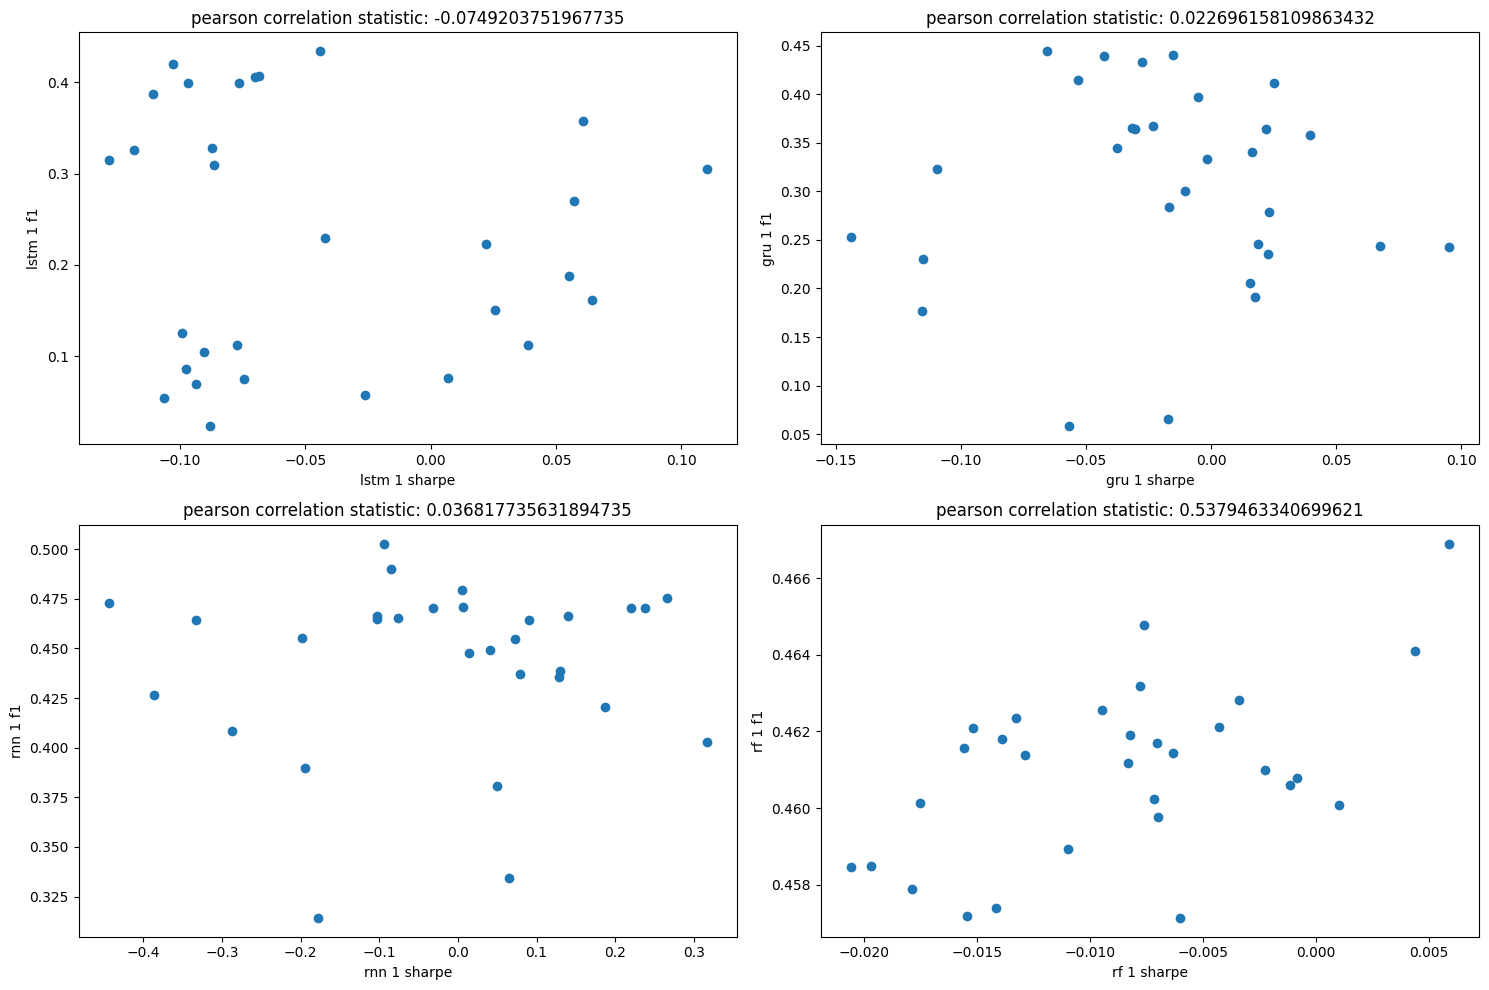

In [154]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes = axes.flatten()

for i, ax in enumerate(axes):
    x, y = sharpes_f1s_pairs[i]
    ax.scatter(x, y)
    ax.set_title(f"pearson correlation statistic: {pearsonr(x, y).statistic}")
    ax.set_xlabel(f"{model_list[i]} sharpe")
    ax.set_ylabel(f"{model_list[i]} f1")

plt.tight_layout()
plt.show()

A mesma observação feita sobre a correlação entre as acurácias e o sharpe ratio pode ser feita sobre o F1 Score

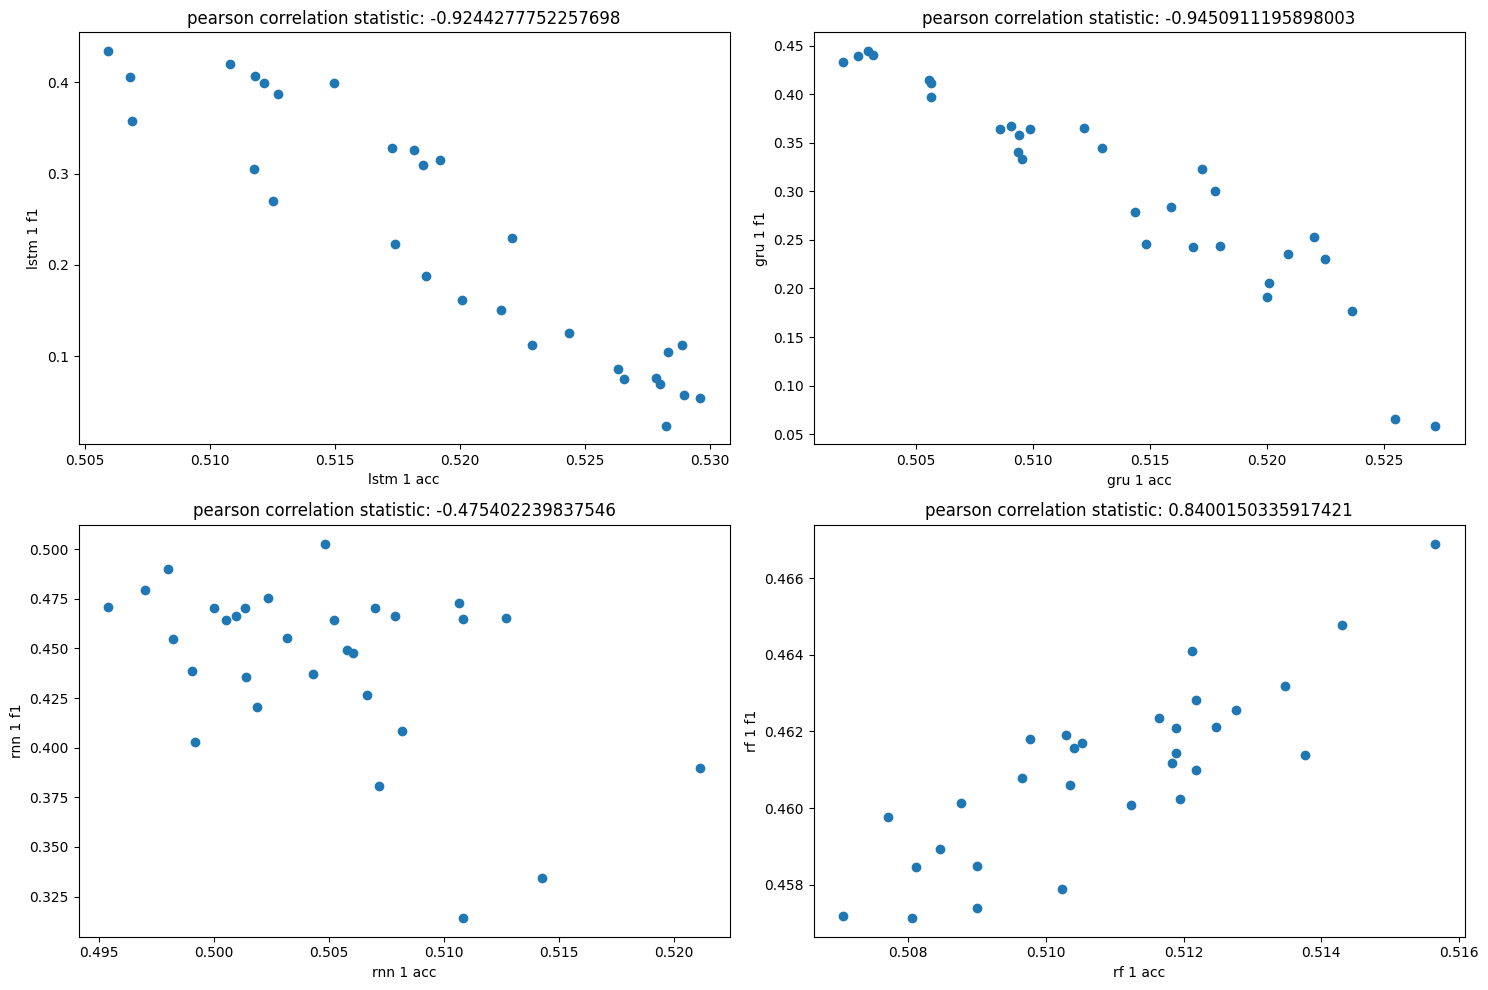

In [155]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes = axes.flatten()

for i, ax in enumerate(axes):
    x, y = accs_f1s_pairs[i]
    ax.scatter(x, y)
    ax.set_title(f"pearson correlation statistic: {pearsonr(x, y).statistic}")
    ax.set_xlabel(f"{model_list[i]} acc")
    ax.set_ylabel(f"{model_list[i]} f1")

plt.tight_layout()
plt.show()

Também não necessarimente há uma correlação entre F1 e Acurácia, exceto pela Random Forest, que apresenta uma correlação mais forte entre as métricas, corroborando com a observação da "certeza", desviando bem menos nos seus resultados mas não apresentando uma performance muito boa

### Addendum

Shapiro-Wilk Statistic: 0.8670602847205287
P-Value: 0.0014419630011376363
H0 rejected for an alpha of 0.05, distribution can't be said Normal
Shapiro-Wilk Statistic: 0.9590348753784003
P-Value: 0.2926064098160541
Fail to reject H0 for an alpha of 0.05, possibly normal distribution
Shapiro-Wilk Statistic: 0.9724702151047961
P-Value: 0.6087382161780766
Fail to reject H0 for an alpha of 0.05, possibly normal distribution
Shapiro-Wilk Statistic: 0.9760574921056243
P-Value: 0.7138650793878526
Fail to reject H0 for an alpha of 0.05, possibly normal distribution


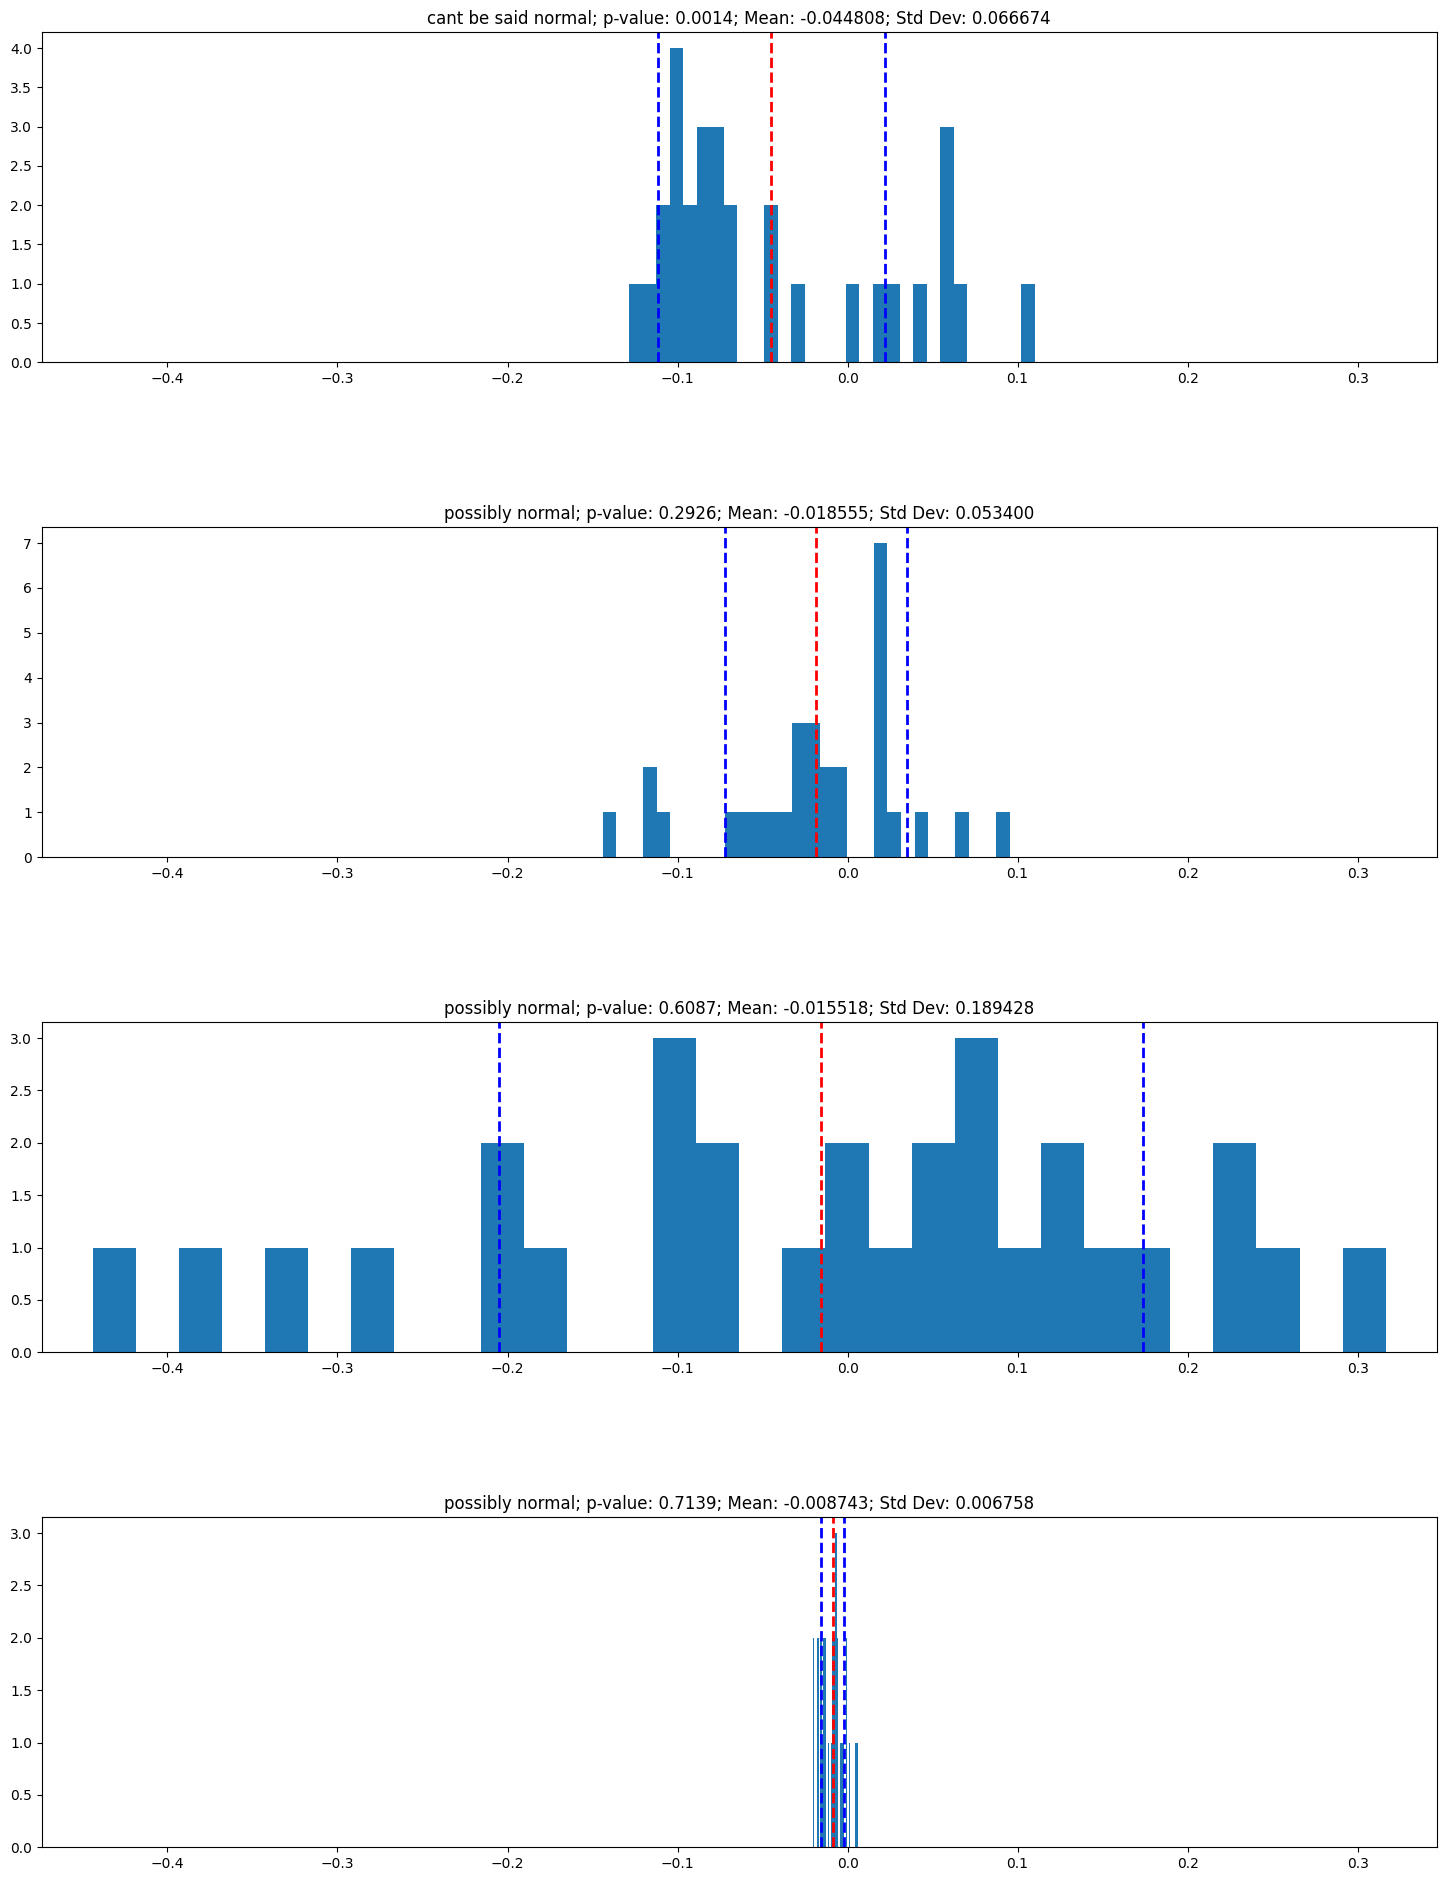

In [156]:
all_data = np.concatenate([lstm_sharpes_1, gru_sharpes_1, rnn_sharpes_1, rf_sharpes_1])
global_min = np.min(all_data)
global_max = np.max(all_data)

plt.figure(figsize=(18, 30))
for i, metrics in enumerate([lstm_sharpes_1, gru_sharpes_1, rnn_sharpes_1, rf_sharpes_1]):

    _, p_value = shapiro_wilk_gaussian_test(metrics)
    # p_value = 0
    mean = np.array(metrics).mean()
    std_dev = np.array(metrics).std()

    plt.subplot(5, 1, i+1)
    plt.xlim(global_min - 0.03, global_max + 0.03)
    plt.axis(True)
    plt.hist(metrics, bins=len(metrics))
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
    plt.axvline(mean + std_dev, color='blue', linestyle='dashed', linewidth=2, label=f'Mean + 1 Std Dev: {mean + std_dev:.2f}')
    plt.axvline(mean - std_dev, color='blue', linestyle='dashed', linewidth=2, label=f'Mean - 1 Std Dev: {mean - std_dev:.2f}')
    plt.title(f"{'cant be said normal' if p_value < 0.05 else 'possibly normal'}; p-value: {p_value:.4f}; Mean: {mean:.6f}; Std Dev: {std_dev:.6f}")
    plt.subplots_adjust(wspace=0.2, hspace=0.5)

Shapiro-Wilk Statistic: 0.9327538595821371
P-Value: 0.05813488567994317
Fail to reject H0 for an alpha of 0.05, possibly normal distribution
Shapiro-Wilk Statistic: 0.9601511847512989
P-Value: 0.3125416802393625
Fail to reject H0 for an alpha of 0.05, possibly normal distribution
Shapiro-Wilk Statistic: 0.9605003911835033
P-Value: 0.3190136106836357
Fail to reject H0 for an alpha of 0.05, possibly normal distribution
Shapiro-Wilk Statistic: 0.9795665078358722
P-Value: 0.8139116006502258
Fail to reject H0 for an alpha of 0.05, possibly normal distribution


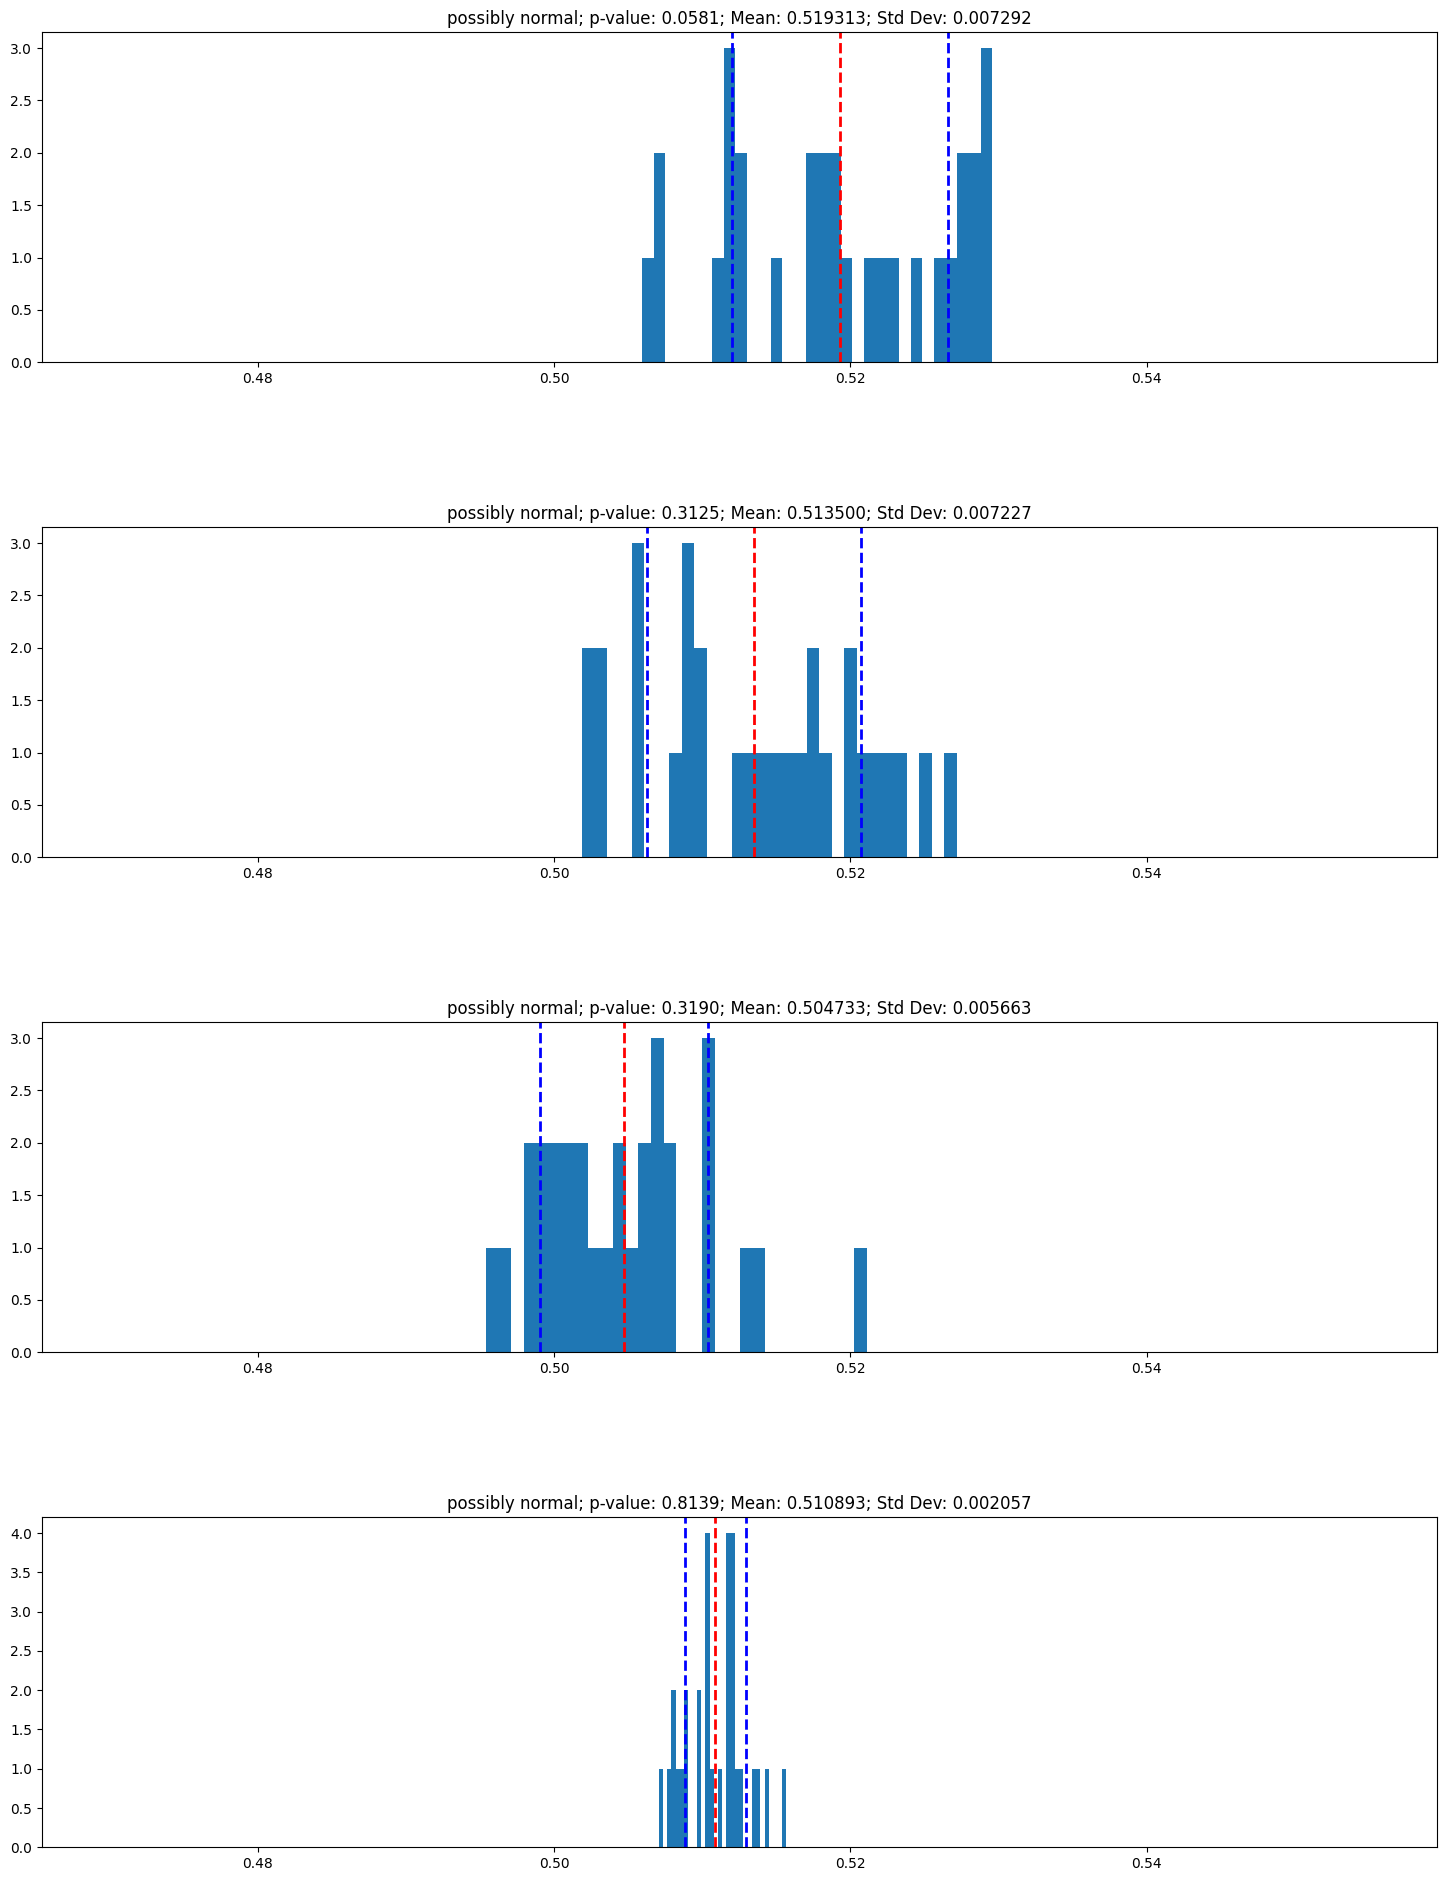

In [157]:
all_data = np.concatenate([lstm_accs_1, gru_accs_1, rnn_accs_1, rf_accs_1])
global_min = np.min(all_data)
global_max = np.max(all_data)

plt.figure(figsize=(18, 30))
for i, metrics in enumerate([lstm_accs_1, gru_accs_1, rnn_accs_1, rf_accs_1]):

    _, p_value = shapiro_wilk_gaussian_test(metrics)
    # p_value = 0
    mean = np.array(metrics).mean()
    std_dev = np.array(metrics).std()

    plt.subplot(5, 1, i+1)
    plt.xlim(global_min - 0.03, global_max + 0.03)
    plt.axis(True)
    plt.hist(metrics, bins=len(metrics))
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
    plt.axvline(mean + std_dev, color='blue', linestyle='dashed', linewidth=2, label=f'Mean + 1 Std Dev: {mean + std_dev:.2f}')
    plt.axvline(mean - std_dev, color='blue', linestyle='dashed', linewidth=2, label=f'Mean - 1 Std Dev: {mean - std_dev:.2f}')
    plt.title(f"{'cant be said normal' if p_value < 0.05 else 'possibly normal'}; p-value: {p_value:.4f}; Mean: {mean:.6f}; Std Dev: {std_dev:.6f}")
    plt.subplots_adjust(wspace=0.2, hspace=0.5)

In [158]:
def two_sample_komolgorov_smirnov(sample1, sample2):
    stat, p_value = ks_2samp(sample1, sample2)

    print(f"KS Statistic: {stat}")
    print(f"P-value: {p_value}")

    alpha = 0.05
    if p_value < alpha:
        print("Reject the null hypothesis: The two samples come from different distributions.")
    else:
        print("Fail to reject the null hypothesis: The two samples may come from the same distribution.")
    print("\n")

    return stat, p_value

In [159]:
from itertools import combinations

def pairwise_hypothesis_tests(results, models = ["lstm", "gru", "rnn", "rf"]):
    """
    Perform pairwise hypothesis tests for a list of metric series.

    Parameters:
    - series_list (list of lists or numpy arrays): A list containing metric series (e.g., 4 series from model trainings).
    - test_function (callable): A hypothesis test function that takes two series as input and returns a p-value.

    Returns:
    - results (dict): A dictionary with keys as tuple pairs of indices (i, j) representing tested series
                      and values as the corresponding p-values.
    """
    num_series = len(results)

    table = {}
    for model, result in zip(models, results):
        table[model] = result

    for i, j in combinations(models, 2):
        series_1 = table[i]
        series_2 = table[j]
        
        print(f"{i} and {j}")
        two_sample_komolgorov_smirnov(series_1, series_2)

In [160]:
pairwise_hypothesis_tests([lstm_sharpes_1, gru_sharpes_1, rnn_sharpes_1, rf_sharpes_1])

lstm and gru
KS Statistic: 0.4666666666666667
P-value: 0.0025300622362698397
Reject the null hypothesis: The two samples come from different distributions.


lstm and rnn
KS Statistic: 0.36666666666666664
P-value: 0.034580084963334506
Reject the null hypothesis: The two samples come from different distributions.


lstm and rf
KS Statistic: 0.7
P-value: 2.5000118318420276e-07
Reject the null hypothesis: The two samples come from different distributions.


gru and rnn
KS Statistic: 0.4
P-value: 0.015643390496754332
Reject the null hypothesis: The two samples come from different distributions.


gru and rf
KS Statistic: 0.43333333333333335
P-value: 0.006548396368058784
Reject the null hypothesis: The two samples come from different distributions.


rnn and rf
KS Statistic: 0.5333333333333333
P-value: 0.0002933405491362055
Reject the null hypothesis: The two samples come from different distributions.




TODO: 
- Rever testes estatísticos na análise exploratória
- Rever montagem do Dataframe
- Consertar scaling em TODOS os modelos OK
- Rever coleta dos resultados -> incluir AUC OK
- Reduzir de 180 pra 60 exp, 500 epochs pra 200, 2 e 4 unidades NN OK
- analise exploratoria dos resultados
    - visualizar confusion matrix?
- formulação de hipoteses sobre os dados
    - analise da potencia e tamanho do efeito antes e depois do fato
- melhorar TODOS os gráficos